In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from math import log
import zipfile
import os
from pathlib import Path
import keras.utils as image
from sklearn.utils import shuffle
import random
import warnings
from PIL import Image
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import cm
import matplotlib.pyplot as plt
random.seed(42)

In [ ]:
#with google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = "/content/drive/MyDrive/Fall'22/BBM409/ass-4/Vegetable Images/train"
test =  "/content/drive/MyDrive/Fall'22/BBM409/ass-4/Vegetable Images/test"
validation = "/content/drive/MyDrive/Fall'22/BBM409/ass-4/Vegetable Images/validation"

In [ ]:
def image_pros(path):
  X_ = []
  Y_ = []
  p = Path(path)
  dirs = p.glob("*")

  counter=0
  for i in dirs:
    label=str(i).split("/")[-1]
    count=0
      
    for j in i.glob("*.jpg"):
      img = image.load_img(j, color_mode = "grayscale" ,target_size=(60,60))
      img_array = image.img_to_array(img)
      X_.append(img_array.flatten())
      Y_.append([0 for i in range(15)])
      Y_[-1][counter] = 1
      count +=1
    
    counter +=1
  return X_, Y_


X_train, Y_train = image_pros(train)
X_test, Y_test = image_pros(test)
X_val, Y_val = image_pros(validation)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [ ]:
#Shuffle our data
X_train, Y_train = shuffle(X_train, Y_train,random_state=42)

#Normalisation
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

In [ ]:
class Neural_Network:

  def __init__(self, hiden_layers, node_sizes, LR, batch_size, activ_func, epoch):
    self.hiden_layers = hiden_layers
    self.node_sizes = node_sizes
    self.LR = LR
    self.batch_size = batch_size
    self.activ_func = activ_func
    self.activ_outputs=0
    self.epoch = epoch

    weight_matrices = []
    biases = []

    for i in range(hiden_layers + 1):
      weight_matrices.append(np.random.randn(node_sizes[i+1], node_sizes[i])*0.1)
      biases.append(np.zeros((node_sizes[i+1],1)))

    self.weight_matrices = weight_matrices
    self.biases = biases


  def train(self, X_train, Y_train, X_val, Y_val, early_stopping):
    
    for i in range(self.epoch): # Epoch

      j= 0
      while j + self.batch_size < len(X_train):
        
        self.forward(X_train[j:j+self.batch_size])
        self.backward(X_train[j:j+self.batch_size], Y_train[j:j+self.batch_size])
        j += self.batch_size

      
      Y_predict = self.forward(X_train)
      

      a_out=np.argmax(Y_predict,0)
      y_out=np.argmax(Y_train.T,0)
      acc=np.mean(y_out==a_out)*100
      train_cost = self.compute_loss(Y_train.T, Y_predict)  #cost
      

      Y_predict = self.forward(X_val)
      
      a_out=np.argmax(Y_predict,0)
      y_val_out=np.argmax(Y_val.T,0)
      acc2=np.mean(y_val_out==a_out)*100

      val_cost = self.compute_loss(Y_val.T, Y_predict)   # cost

      
      
      print("Epoch {}: training cost = {}, validation cost = {}".format(i+1 ,train_cost, val_cost))
      print("Train Accuracy:",acc,"Validation Accuracy:",acc2)

      if early_stopping and i % 5 == 0 and val_cost > train_cost:
        break
  
  def predict(self, X_test):
    return self.forward(X_test)
        

  def compute_loss(self, Y, Y_predict):
    
    # np.ma.masked_where(Y_predict <= 0, Y_predict
    
    m=Y.shape[1]
    cost=-(1/m)*np.sum(Y*np.log(Y_predict))

    cost=np.squeeze(cost)

    return cost

  def forward(self, x):
    activ_outputs = [[] for i in range(len(self.weight_matrices) + 1)]
    activ_outputs[0] = x.T

    for i in range(len(self.weight_matrices)):
      self.z = np.dot(self.weight_matrices[i], activ_outputs[i]) + self.biases[i]     
      activation_func = self.activ_func[i]
      activ_outputs[i+1] = eval("self." + activation_func + "()")

    self.activ_outputs=activ_outputs

    return activ_outputs[-1]

  def backward(self, x, y):

    m = x.shape[0]

    cache = self.weight_matrices
    cache_bias = self.biases

    delta = self.activ_outputs[-1] - y.T
    wn = (1/m) * np.dot(delta, self.activ_outputs[-2].T)
    bn = (1/m) * (np.sum(delta, axis=1,keepdims=True))


    cache[-1] -= self.LR * wn
    cache_bias[-1] -= self.LR * bn

    

    for i in range(len(self.weight_matrices)-1, 0, -1):
      self.out = self.activ_outputs[i]
      activ_func = self.activ_func[i-1]

      delta = np.dot(self.weight_matrices[i].T, delta) * eval("self.derivative_{}{}".format(activ_func, "()" ))
      wn = (1/m) *(np.dot(delta, self.activ_outputs[i-1].T))
      bn = (1/m) *(np.sum(delta, axis=1,keepdims=True))

      cache[i-1] -= self.LR * wn
      cache_bias[i-1] -= self.LR * bn

    self.weight_matrices = cache
    self.biases = cache_bias

  def relu(self):
    return np.maximum(0, self.z)


  def softmax(self):
    
    expZ = np.exp(self.z)
    return expZ/(np.sum(expZ, 0))

  def sigmoid(self):
    warnings.filterwarnings('ignore')
    return np.divide(1, np.add(1, np.exp(-self.z)))

  def tanh(self):
    # t=(np.exp(self.z)-np.exp(-self.z))/(np.exp(self.z)+np.exp(-self.z))
    # return t
    return np.tanh(self.z)

  def derivative_relu(self):

    y = np.zeros_like(self.out)
    y[self.out> 0] = 1

    return y

  def derivative_tanh(self):
    return (1 - np.power(self.out, 2))

  def derivative_sigmoid(self):
    return (1 - np.power(self.out, 2))

  def confusion_m(self, x, y):
    pred = self.predict(x)

    a_out=np.argmax(pred,0)
    y_out=np.argmax(y.T,0)

    acc=np.mean(y_out==a_out)*100

    confusion_matrix = metrics.confusion_matrix(y_out, a_out)
    
    print(classification_report(y_out, a_out, digits=3))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [
    'Bean',
    'Bitter_Gourd',
    'Bottle_Gourd',
    'Brinjal',
    'Broccoli',
    'Cabbage',
    'Capsicum',
    'Carrot',
    'Cauliflower',
    'Cucumber',
    'Papaya',
    'Potato',
    'Pumpkin',
    'Radish',
    'Tomato'])

    fig, ax = plt.subplots(figsize=(18,18))
    cm_display.plot(ax=ax) 
    plt.show()


  def visualize_weights(self,n):
    display_labels = [
        'Bean',
        'Bitter_Gourd',
        'Bottle_Gourd',
        'Brinjal',
        'Broccoli',
        'Cabbage',
        'Capsicum',
        'Carrot',
        'Cauliflower',
        'Cucumber',
        'Papaya',
        'Potato',
        'Pumpkin',
        'Radish',
        'Tomato']
    counter = 0
    for i in self.weight_matrices[-1]:
      array =  i.reshape(n,n)
      array -= array.min()
      array *= 255.0/ array.max()
    
      im = Image.fromarray(array)
      plt.figure(figsize = (5,5))
      print(display_labels[counter])
      counter +=1
      plt.imshow(im)
      plt.show()

  def save_mode(self):
    np.save("weight_matrix", self.weight_matrices[-1])

# Tests of 2 Hiden Layer Neural Network

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =16, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.662361329534262, validation cost = 2.723717903402622
Train Accuracy: 11.290751829673985 Validation Accuracy: 7.566666666666666
Epoch 2: training cost = 2.63468119697993, validation cost = 2.731003335041836
Train Accuracy: 14.810379241516966 Validation Accuracy: 7.000000000000001
Epoch 3: training cost = 2.6126016422350054, validation cost = 2.7395476053169827
Train Accuracy: 17.252162341982704 Validation Accuracy: 7.066666666666667
Epoch 4: training cost = 2.590524014075464, validation cost = 2.752160435293695
Train Accuracy: 18.795741849634066 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = 2.5689897544475464, validation cost = 2.7701441629542187
Train Accuracy: 19.454424484364605 Validation Accuracy: 6.7
Epoch 6: training cost = 2.5514655993207103, validation cost = 2.790318445587266
Train Accuracy: 19.44111776447106 Validation Accuracy: 6.466666666666667
Epoch 7: training cost = 2.538452854988111, validation cost = 2.8088770606116147
Train 

              precision    recall  f1-score   support

           0      0.014     0.005     0.007       200
           1      0.024     0.045     0.031       200
           2      0.045     0.035     0.039       200
           3      0.032     0.025     0.028       200
           4      0.084     0.060     0.070       200
           5      0.046     0.060     0.052       200
           6      0.046     0.060     0.052       200
           7      0.011     0.005     0.007       200
           8      0.116     0.075     0.091       200
           9      0.012     0.005     0.007       200
          10      0.100     0.025     0.040       200
          11      0.123     0.680     0.208       200
          12      0.182     0.010     0.019       200
          13      0.026     0.005     0.008       200
          14      0.016     0.005     0.008       200

    accuracy                          0.073      3000
   macro avg      0.058     0.073     0.045      3000
weighted avg      0.058   

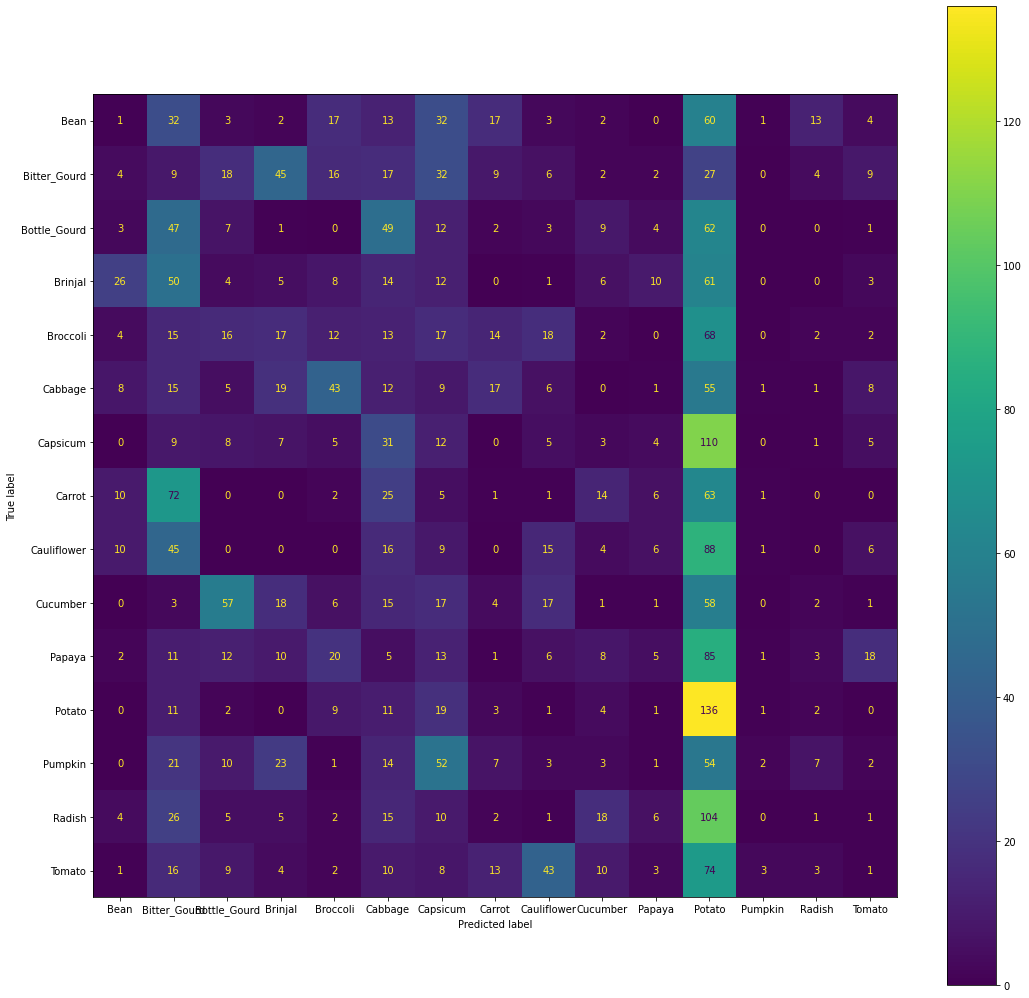

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


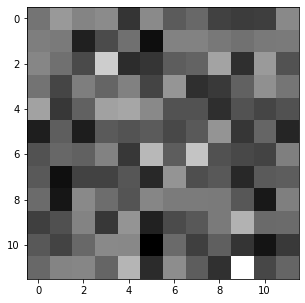

Bitter_Gourd


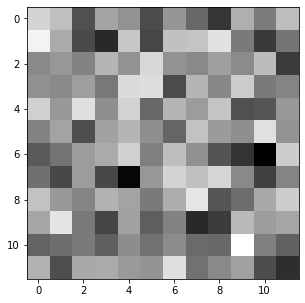

Bottle_Gourd


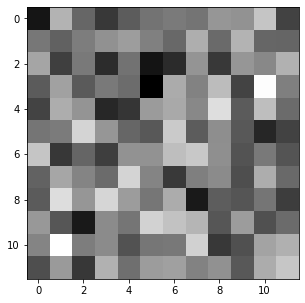

Brinjal


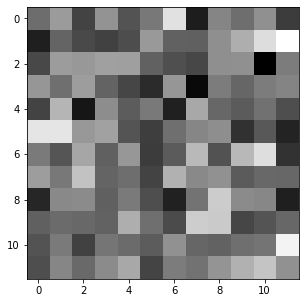

Broccoli


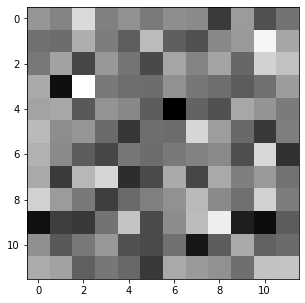

Cabbage


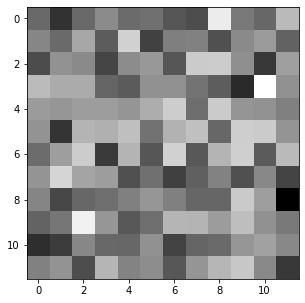

Capsicum


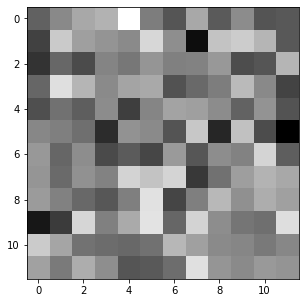

Carrot


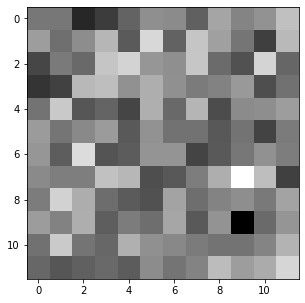

Cauliflower


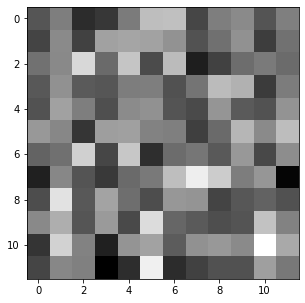

Cucumber


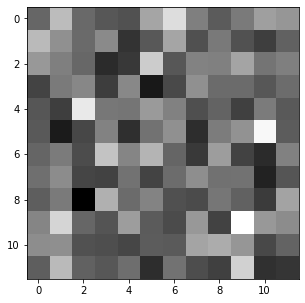

Papaya


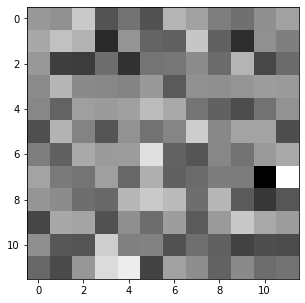

Potato


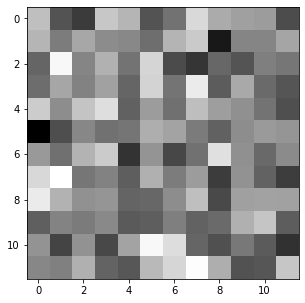

Pumpkin


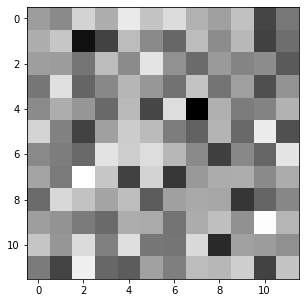

Radish


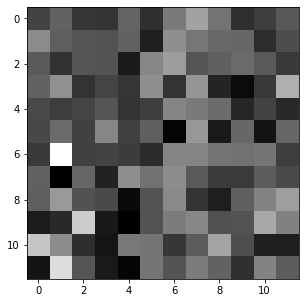

Tomato


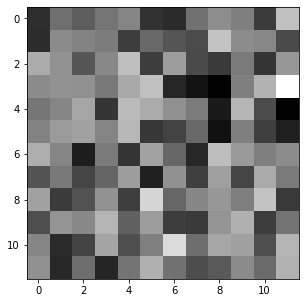

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =16, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

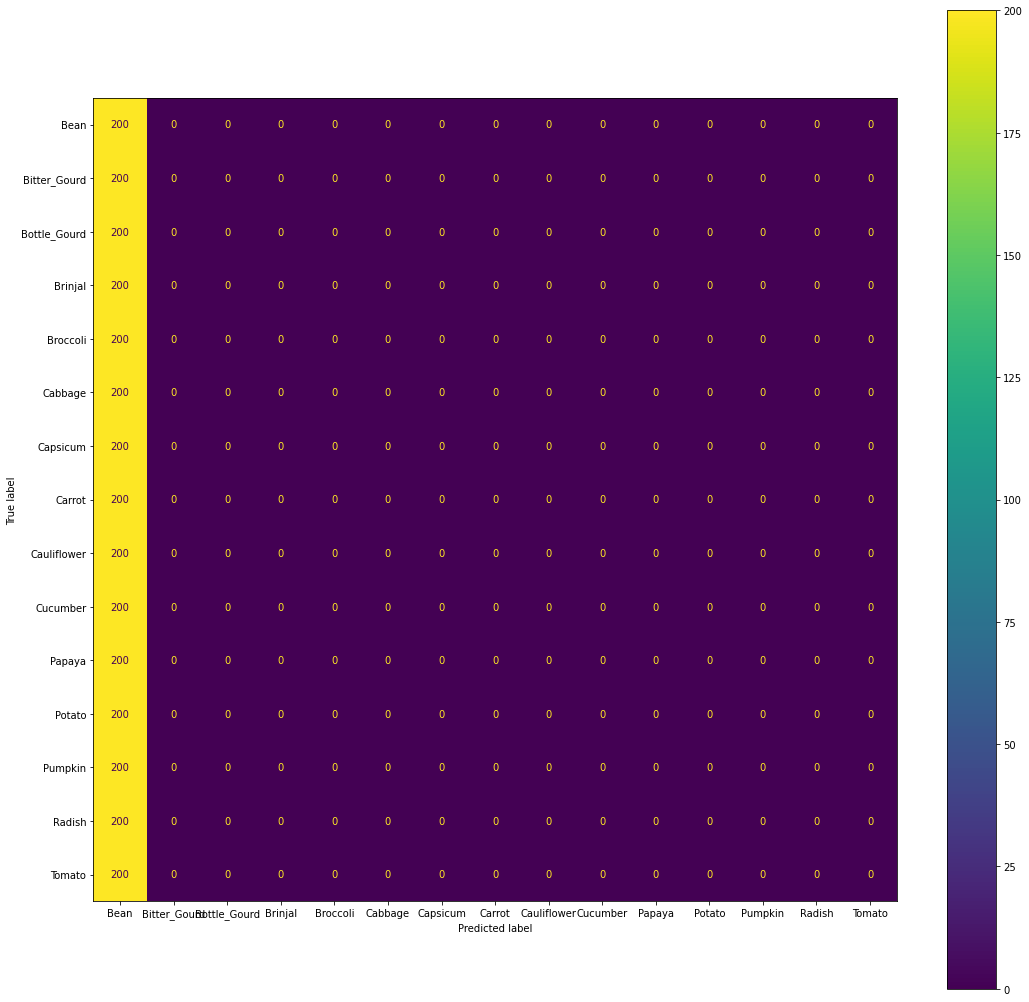

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


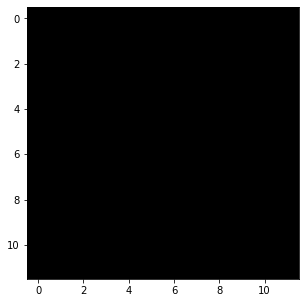

Bitter_Gourd


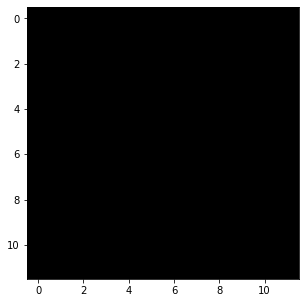

Bottle_Gourd


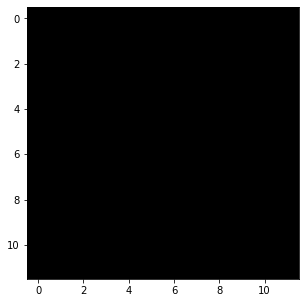

Brinjal


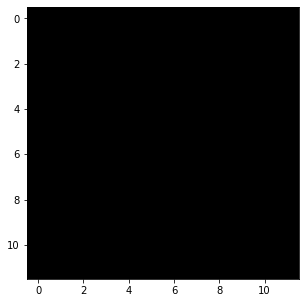

Broccoli


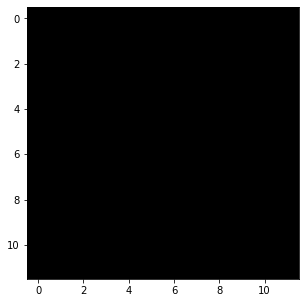

Cabbage


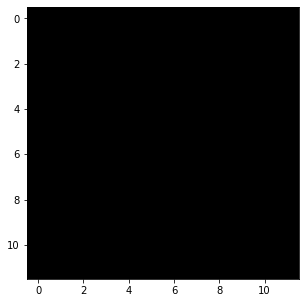

Capsicum


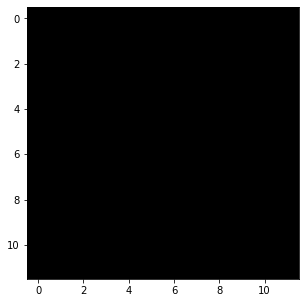

Carrot


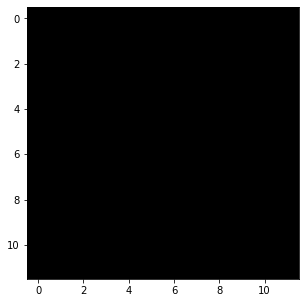

Cauliflower


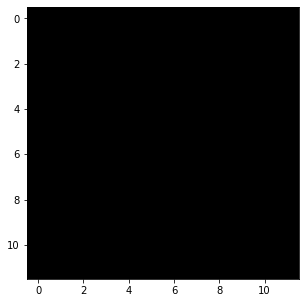

Cucumber


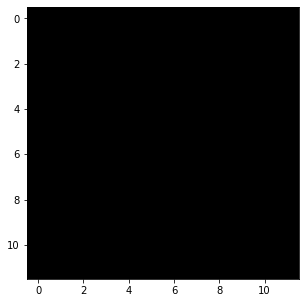

Papaya


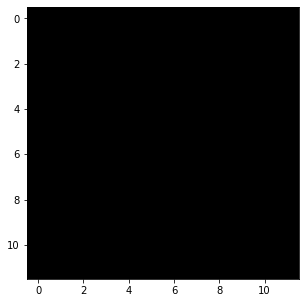

Potato


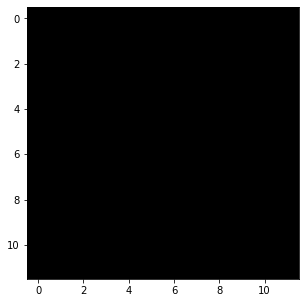

Pumpkin


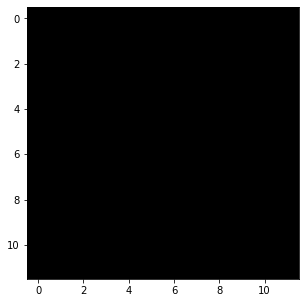

Radish


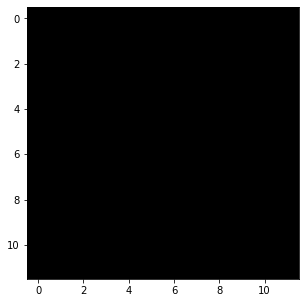

Tomato


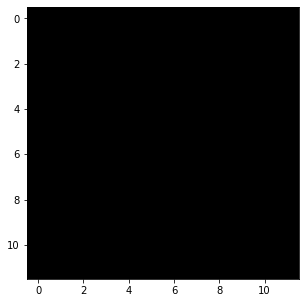

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =16, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.4050666865116246, validation cost = 2.9604742323252164
Train Accuracy: 24.165003326679972 Validation Accuracy: 7.8
Epoch 2: training cost = 2.2698893161797544, validation cost = 3.114146408805907
Train Accuracy: 29.59414504324684 Validation Accuracy: 7.466666666666668
Epoch 3: training cost = 2.172546360715359, validation cost = 3.2303136401106105
Train Accuracy: 32.721224218230205 Validation Accuracy: 7.1
Epoch 4: training cost = 2.090524886929494, validation cost = 3.3274629096784136
Train Accuracy: 34.930139720558884 Validation Accuracy: 7.3
Epoch 5: training cost = 2.0183402380894533, validation cost = 3.4144735752213284
Train Accuracy: 37.49168330006653 Validation Accuracy: 7.333333333333333
Epoch 6: training cost = 1.9524674728556506, validation cost = 3.4966911884920835
Train Accuracy: 39.5542248835662 Validation Accuracy: 7.333333333333333
Epoch 7: training cost = 1.8909286717083575, validation cost = 3.57615711068656
Train Accuracy: 41.56353958749168

              precision    recall  f1-score   support

           0      0.060     0.080     0.068       200
           1      0.021     0.030     0.025       200
           2      0.051     0.055     0.053       200
           3      0.019     0.015     0.017       200
           4      0.033     0.025     0.028       200
           5      0.038     0.040     0.039       200
           6      0.035     0.045     0.039       200
           7      0.033     0.040     0.036       200
           8      0.022     0.015     0.018       200
           9      0.021     0.015     0.017       200
          10      0.077     0.075     0.076       200
          11      0.405     0.520     0.455       200
          12      0.029     0.020     0.024       200
          13      0.032     0.025     0.028       200
          14      0.029     0.025     0.027       200

    accuracy                          0.068      3000
   macro avg      0.060     0.068     0.063      3000
weighted avg      0.060   

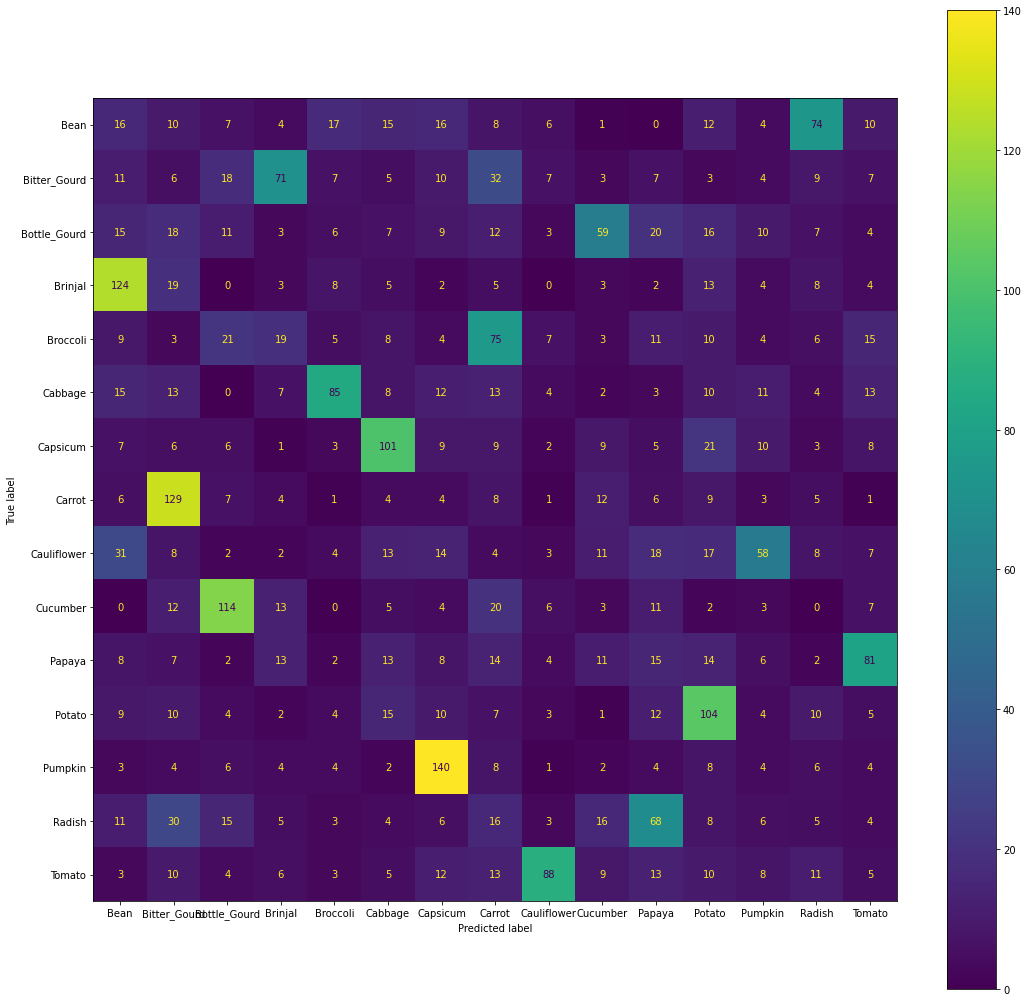

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


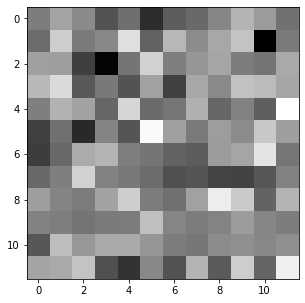

Bitter_Gourd


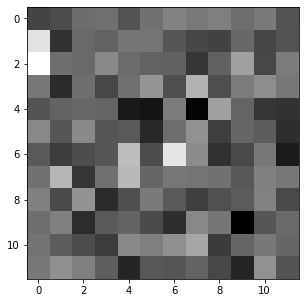

Bottle_Gourd


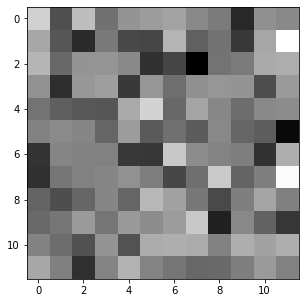

Brinjal


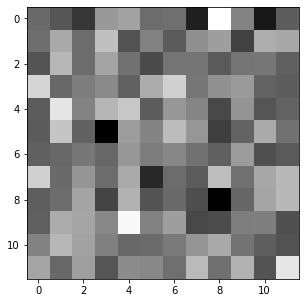

Broccoli


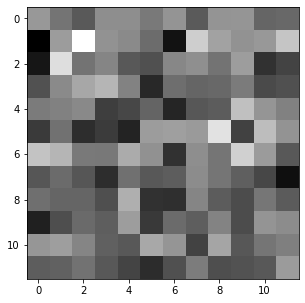

Cabbage


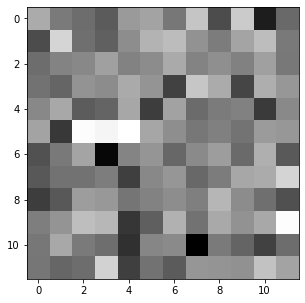

Capsicum


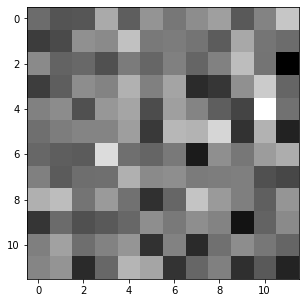

Carrot


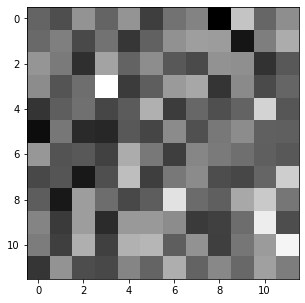

Cauliflower


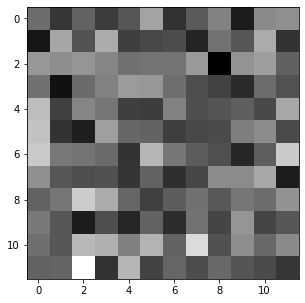

Cucumber


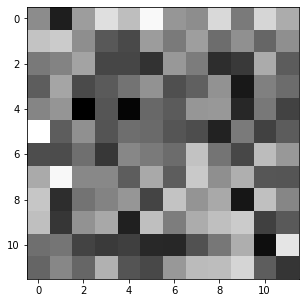

Papaya


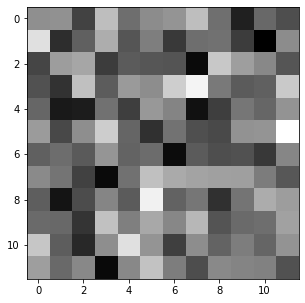

Potato


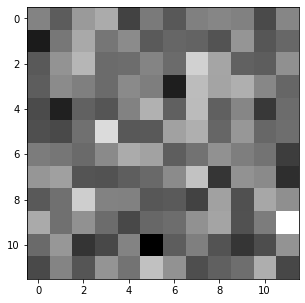

Pumpkin


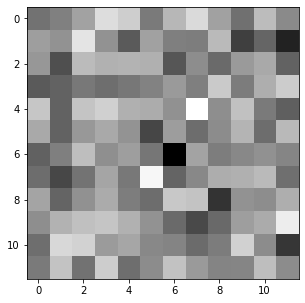

Radish


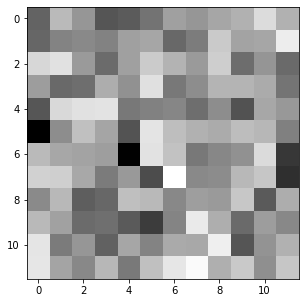

Tomato


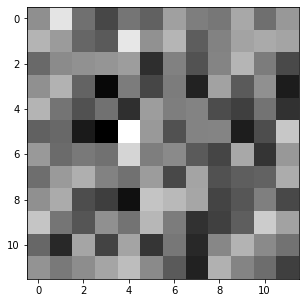

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =32, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6803935849445457, validation cost = 2.715021107732318
Train Accuracy: 9.780439121756487 Validation Accuracy: 8.200000000000001
Epoch 2: training cost = 2.6655284865367155, validation cost = 2.7192675706568092
Train Accuracy: 11.716566866267465 Validation Accuracy: 8.1
Epoch 3: training cost = 2.6519168398621855, validation cost = 2.722420131565901
Train Accuracy: 13.419827012641383 Validation Accuracy: 8.066666666666666
Epoch 4: training cost = 2.6401769876835686, validation cost = 2.724184482550327
Train Accuracy: 15.276114437791085 Validation Accuracy: 7.733333333333333
Epoch 5: training cost = 2.6297888619058143, validation cost = 2.7266911169805375
Train Accuracy: 16.26746506986028 Validation Accuracy: 7.633333333333334
Epoch 6: training cost = 2.620898719861672, validation cost = 2.7290278494981495
Train Accuracy: 16.766467065868262 Validation Accuracy: 7.033333333333333
Epoch 7: training cost = 2.612665408409415, validation cost = 2.731933909091676
Trai

              precision    recall  f1-score   support

           0      0.050     0.015     0.023       200
           1      0.015     0.025     0.018       200
           2      0.051     0.055     0.053       200
           3      0.052     0.035     0.042       200
           4      0.055     0.130     0.077       200
           5      0.024     0.040     0.030       200
           6      0.081     0.200     0.115       200
           7      0.000     0.000     0.000       200
           8      0.194     0.140     0.163       200
           9      0.000     0.000     0.000       200
          10      0.086     0.030     0.044       200
          11      0.148     0.325     0.203       200
          12      0.031     0.010     0.015       200
          13      0.000     0.000     0.000       200
          14      0.041     0.025     0.031       200

    accuracy                          0.069      3000
   macro avg      0.055     0.069     0.054      3000
weighted avg      0.055   

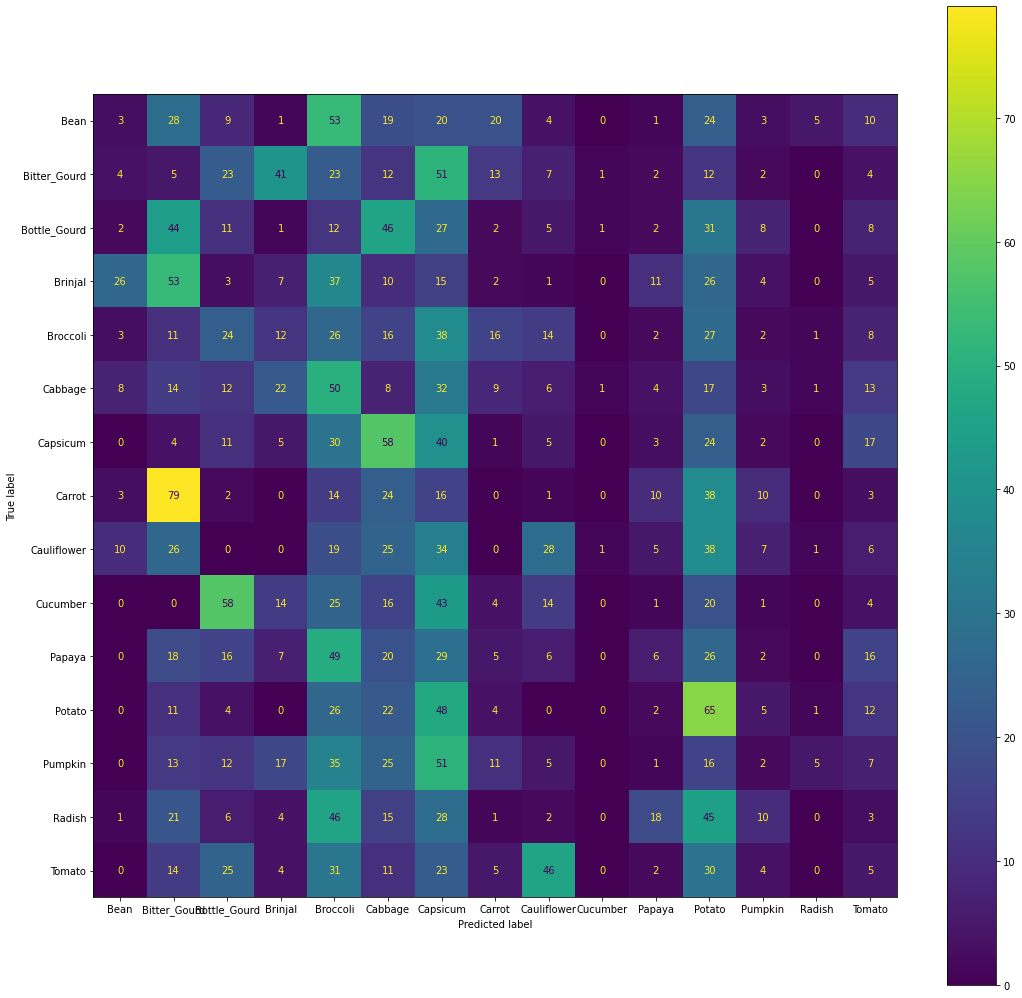

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


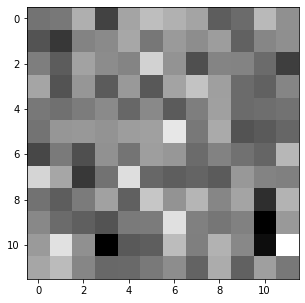

Bitter_Gourd


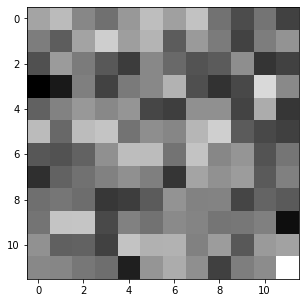

Bottle_Gourd


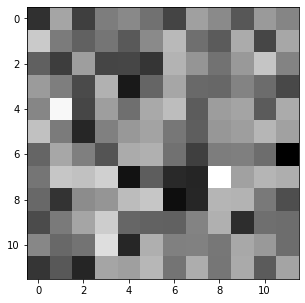

Brinjal


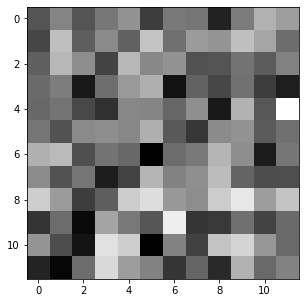

Broccoli


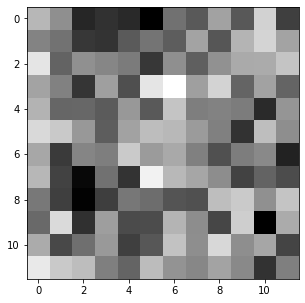

Cabbage


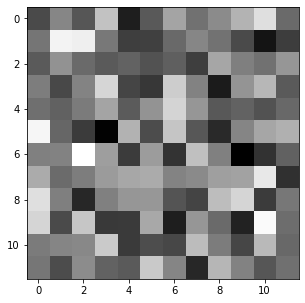

Capsicum


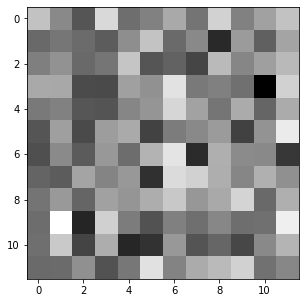

Carrot


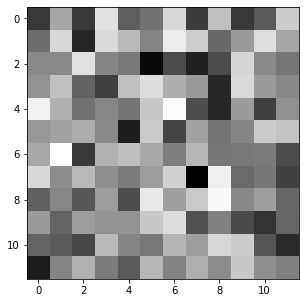

Cauliflower


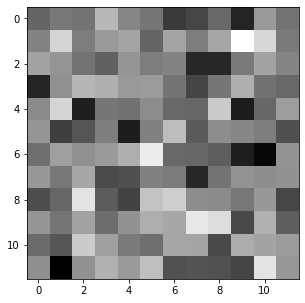

Cucumber


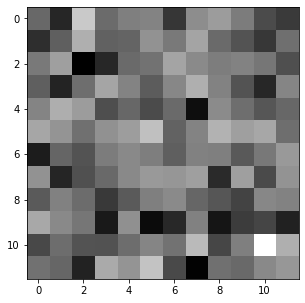

Papaya


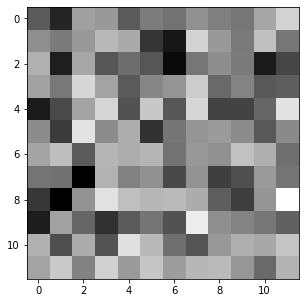

Potato


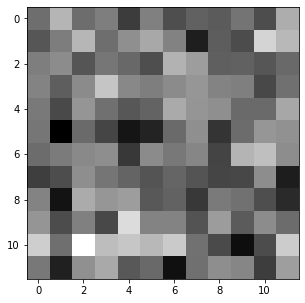

Pumpkin


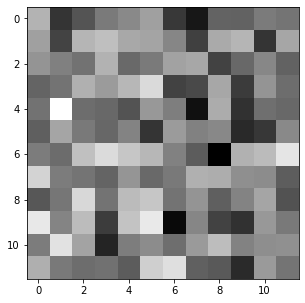

Radish


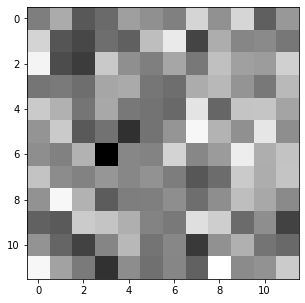

Tomato


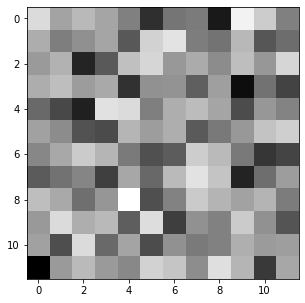

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =32, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 3.2508964796260376, validation cost = 3.891894017524652
Train Accuracy: 16.39387890884897 Validation Accuracy: 5.6000000000000005
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accur

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

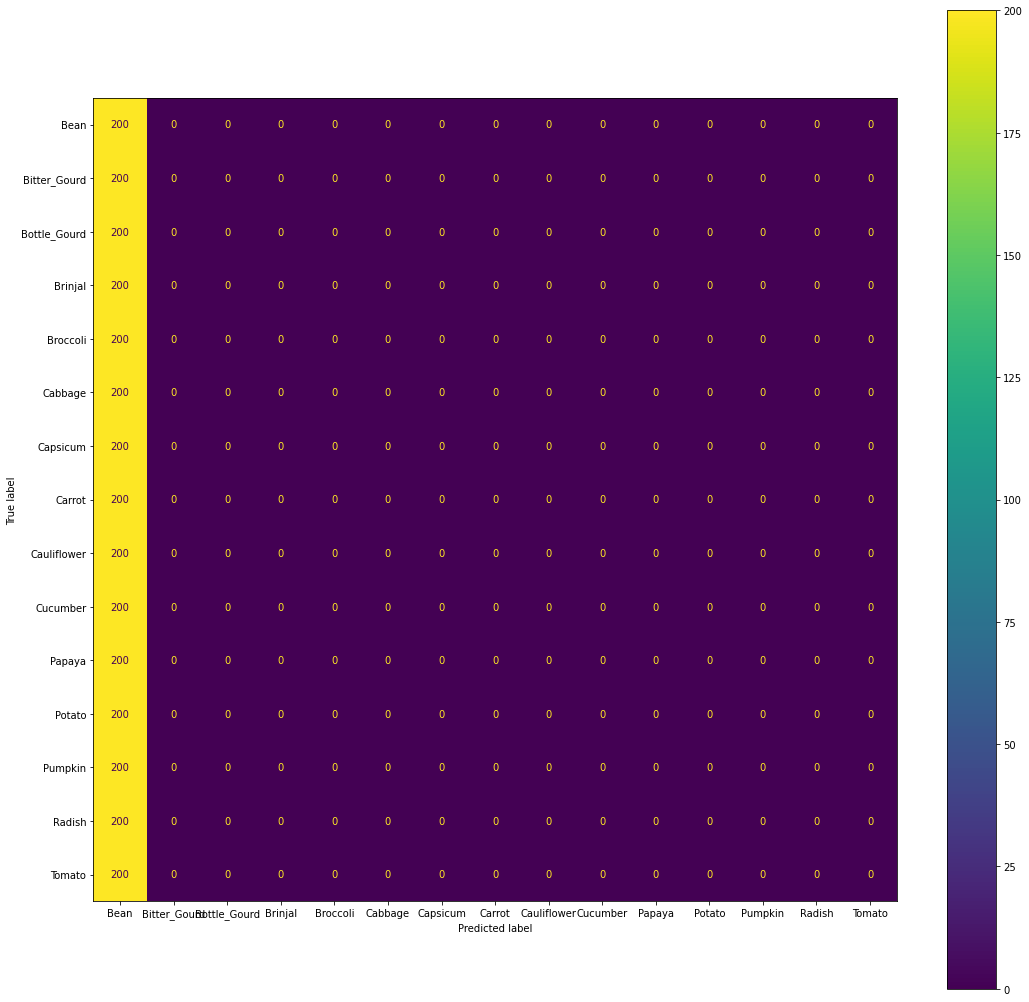

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


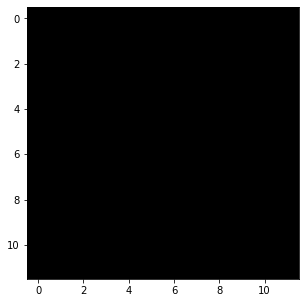

Bitter_Gourd


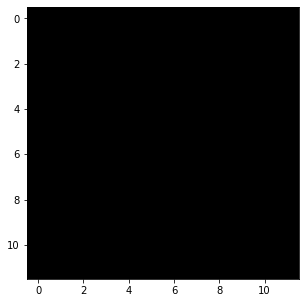

Bottle_Gourd


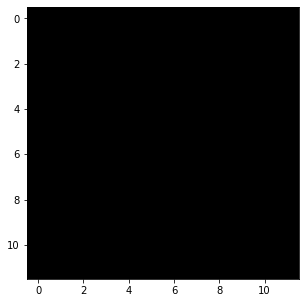

Brinjal


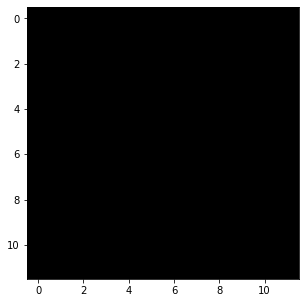

Broccoli


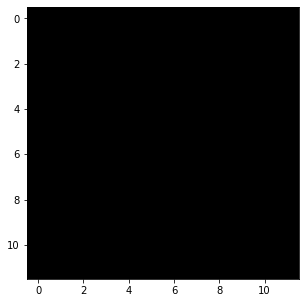

Cabbage


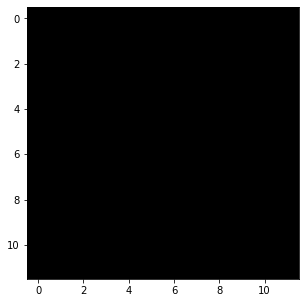

Capsicum


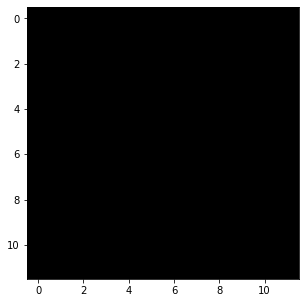

Carrot


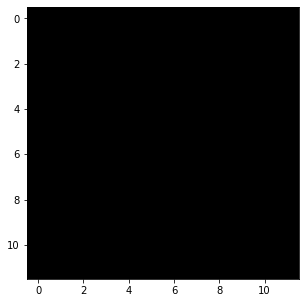

Cauliflower


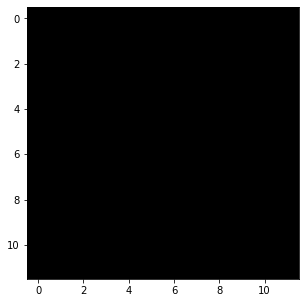

Cucumber


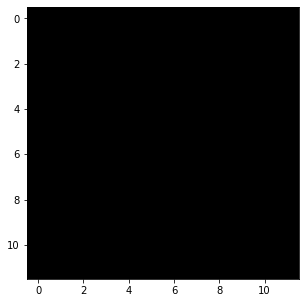

Papaya


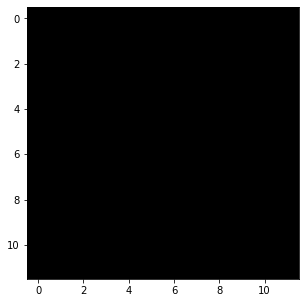

Potato


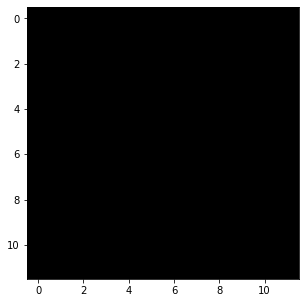

Pumpkin


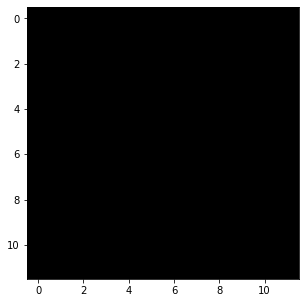

Radish


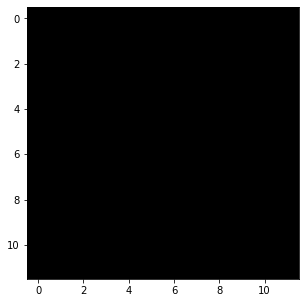

Tomato


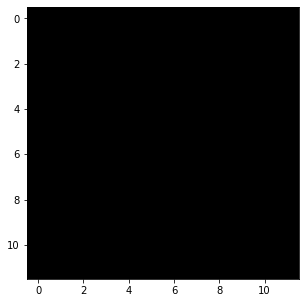

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =32, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.5037794915143734, validation cost = 2.857155925288961
Train Accuracy: 19.740518962075846 Validation Accuracy: 7.466666666666668
Epoch 2: training cost = 2.3940115323366595, validation cost = 2.937229401443168
Train Accuracy: 24.37125748502994 Validation Accuracy: 7.5
Epoch 3: training cost = 2.3219463684393737, validation cost = 3.016598970048717
Train Accuracy: 27.39188290086494 Validation Accuracy: 6.966666666666667
Epoch 4: training cost = 2.2645416257391986, validation cost = 3.0851040385491415
Train Accuracy: 29.647371922821026 Validation Accuracy: 7.133333333333333
Epoch 5: training cost = 2.2152413132272875, validation cost = 3.143895940766795
Train Accuracy: 31.463739188290084 Validation Accuracy: 7.233333333333333
Epoch 6: training cost = 2.170636184787012, validation cost = 3.1968784606404697
Train Accuracy: 33.020625415835 Validation Accuracy: 7.2666666666666675
Epoch 7: training cost = 2.129316381162162, validation cost = 3.2460519664741185
Train 

              precision    recall  f1-score   support

           0      0.032     0.030     0.031       200
           1      0.018     0.030     0.022       200
           2      0.082     0.140     0.103       200
           3      0.046     0.035     0.040       200
           4      0.025     0.020     0.022       200
           5      0.042     0.050     0.046       200
           6      0.049     0.055     0.052       200
           7      0.031     0.030     0.030       200
           8      0.052     0.040     0.045       200
           9      0.033     0.020     0.025       200
          10      0.079     0.105     0.090       200
          11      0.395     0.460     0.425       200
          12      0.051     0.035     0.042       200
          13      0.019     0.010     0.013       200
          14      0.046     0.035     0.040       200

    accuracy                          0.073      3000
   macro avg      0.067     0.073     0.068      3000
weighted avg      0.067   

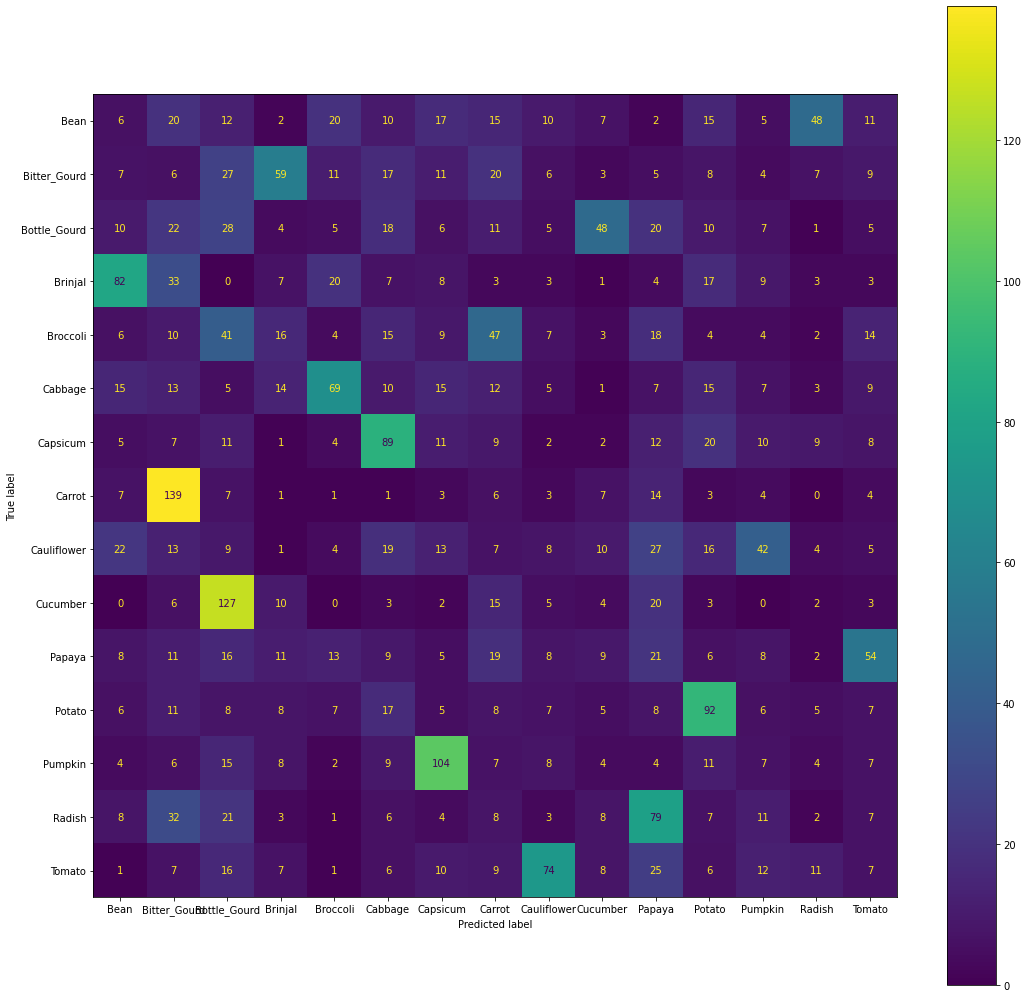

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


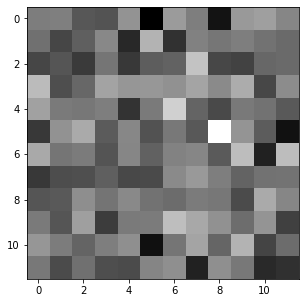

Bitter_Gourd


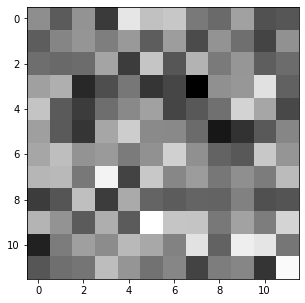

Bottle_Gourd


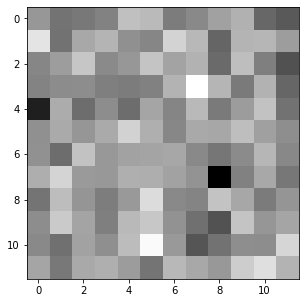

Brinjal


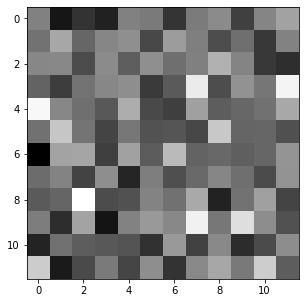

Broccoli


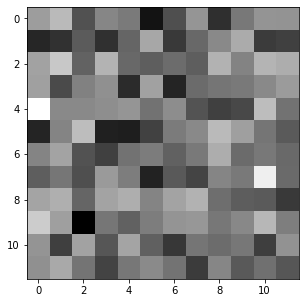

Cabbage


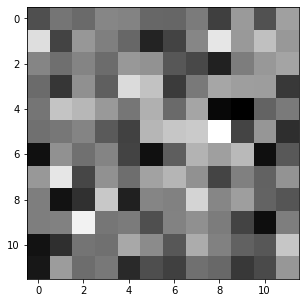

Capsicum


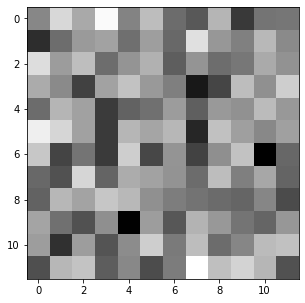

Carrot


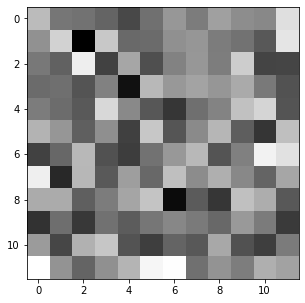

Cauliflower


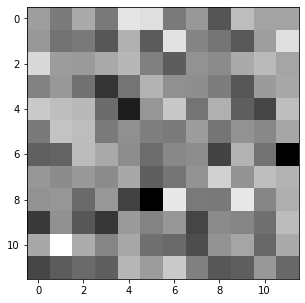

Cucumber


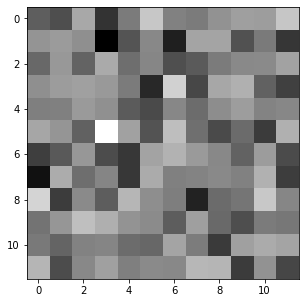

Papaya


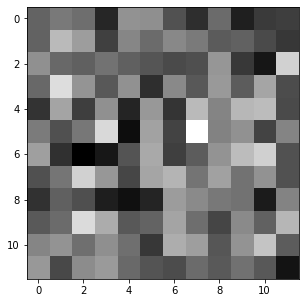

Potato


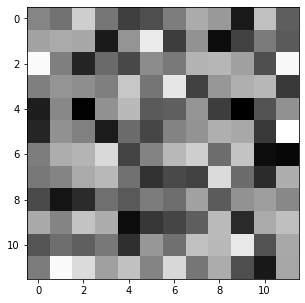

Pumpkin


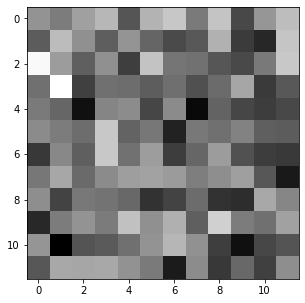

Radish


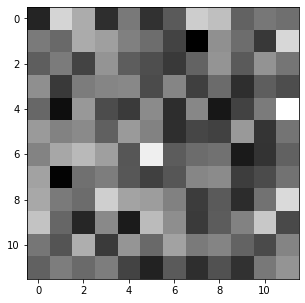

Tomato


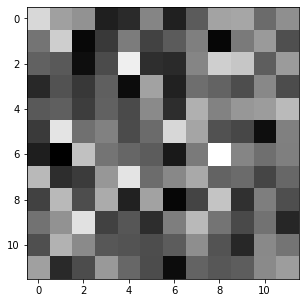

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =64, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.693599360735728, validation cost = 2.7093286576210436
Train Accuracy: 9.10179640718563 Validation Accuracy: 8.3
Epoch 2: training cost = 2.6800801162155126, validation cost = 2.7120411048267536
Train Accuracy: 11.457085828343313 Validation Accuracy: 8.9
Epoch 3: training cost = 2.669676029189635, validation cost = 2.7144828765877245
Train Accuracy: 14.058549567531603 Validation Accuracy: 8.633333333333333
Epoch 4: training cost = 2.6637008856114965, validation cost = 2.7168346121905826
Train Accuracy: 15.256154357950766 Validation Accuracy: 8.433333333333334
Epoch 5: training cost = 2.656493138813148, validation cost = 2.719065295551258
Train Accuracy: 15.815036593479705 Validation Accuracy: 8.1
Epoch 6: training cost = 2.649211825342047, validation cost = 2.7210739645054356
Train Accuracy: 16.274118429807054 Validation Accuracy: 7.8
Epoch 7: training cost = 2.641470719072067, validation cost = 2.72283218879213
Train Accuracy: 17.16566866267465 Validation Acc

              precision    recall  f1-score   support

           0      0.043     0.010     0.016       200
           1      0.033     0.050     0.040       200
           2      0.017     0.010     0.013       200
           3      0.045     0.055     0.049       200
           4      0.046     0.065     0.054       200
           5      0.036     0.045     0.040       200
           6      0.101     0.130     0.114       200
           7      0.052     0.065     0.058       200
           8      0.023     0.015     0.018       200
           9      0.000     0.000     0.000       200
          10      0.079     0.090     0.084       200
          11      0.184     0.255     0.214       200
          12      0.019     0.015     0.017       200
          13      0.045     0.045     0.045       200
          14      0.032     0.025     0.028       200

    accuracy                          0.058      3000
   macro avg      0.050     0.058     0.053      3000
weighted avg      0.050   

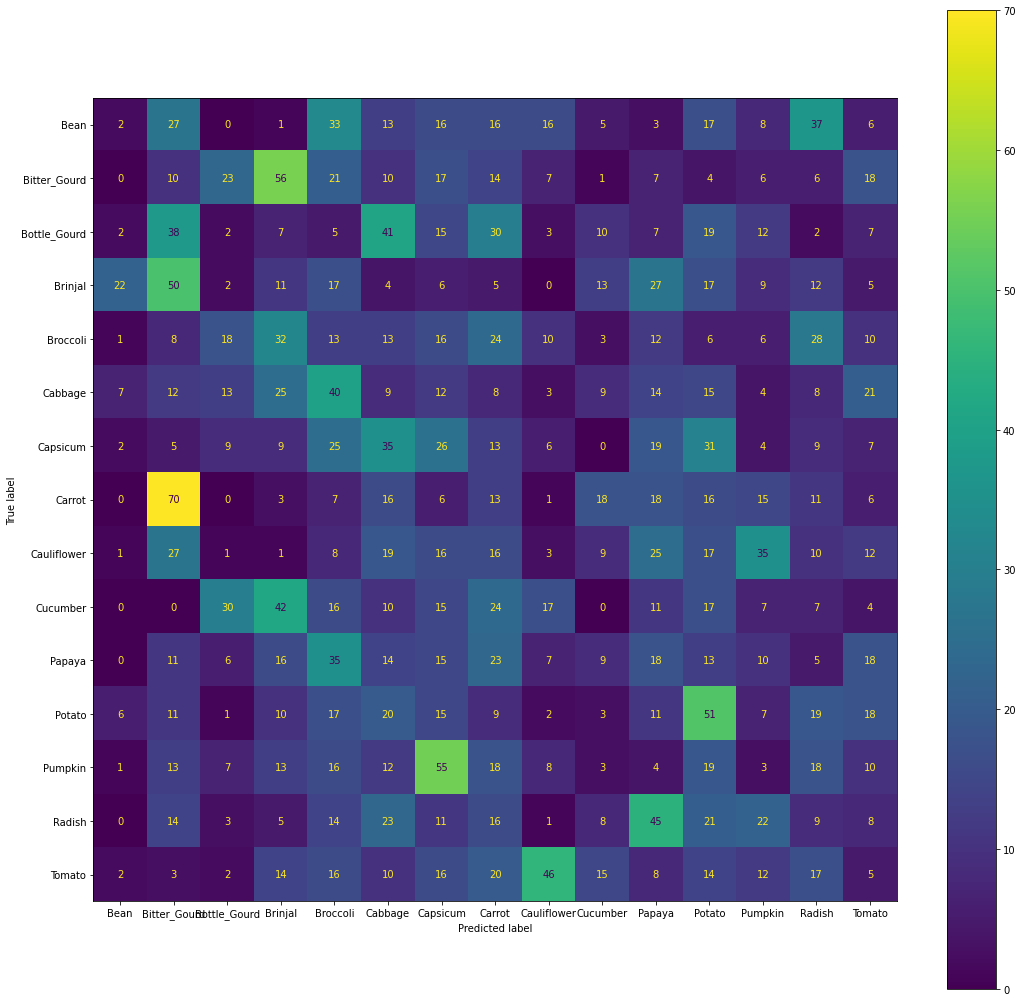

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


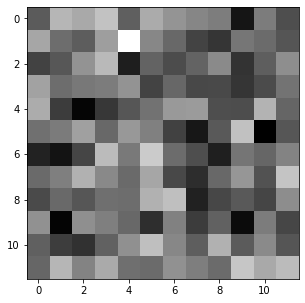

Bitter_Gourd


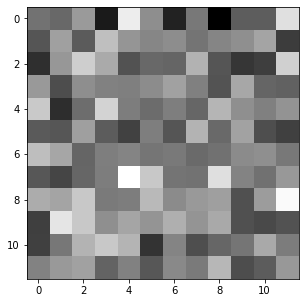

Bottle_Gourd


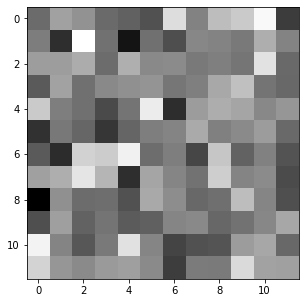

Brinjal


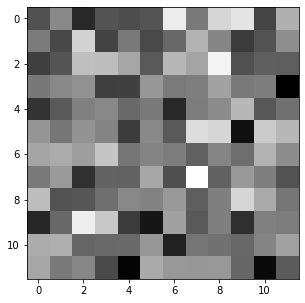

Broccoli


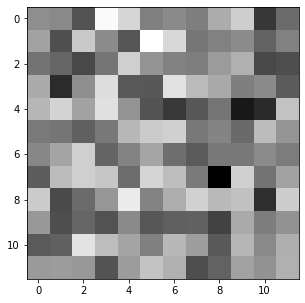

Cabbage


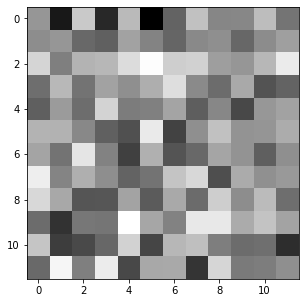

Capsicum


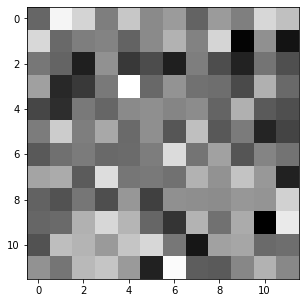

Carrot


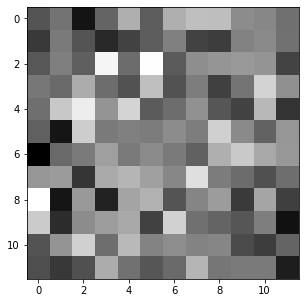

Cauliflower


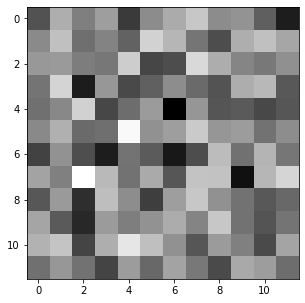

Cucumber


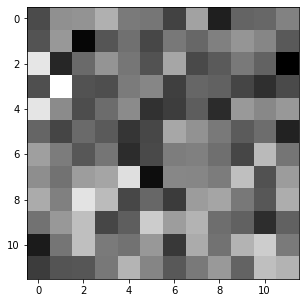

Papaya


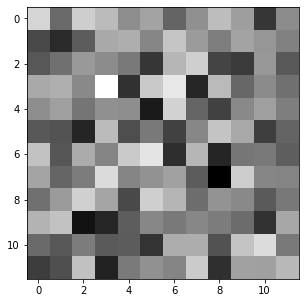

Potato


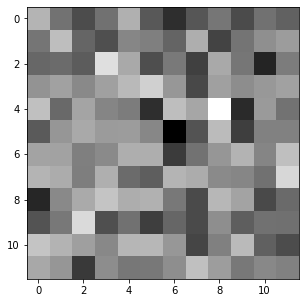

Pumpkin


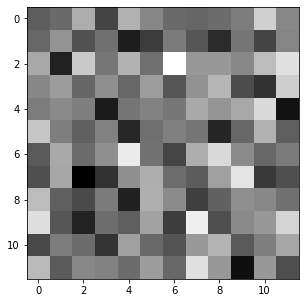

Radish


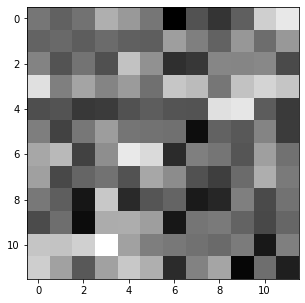

Tomato


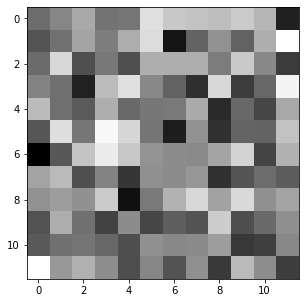

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =64, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.5868728348892596, validation cost = 3.018963158530893
Train Accuracy: 16.240851630073188 Validation Accuracy: 7.000000000000001
Epoch 2: training cost = 2.473335848170453, validation cost = 3.075806528747945
Train Accuracy: 20.652029274783764 Validation Accuracy: 7.366666666666667
Epoch 3: training cost = 2.407311958921643, validation cost = 3.1263364390256156
Train Accuracy: 22.821024617431803 Validation Accuracy: 6.566666666666666
Epoch 4: training cost = 2.364777979818083, validation cost = 3.1884473825130795
Train Accuracy: 23.912175648702593 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = 2.3513021181599867, validation cost = 3.264216617009069
Train Accuracy: 23.865602129075185 Validation Accuracy: 6.233333333333333
Epoch 6: training cost = 2.480036052998455, validation cost = 3.4724616546840363
Train Accuracy: 20.59880239520958 Validation Accuracy: 6.066666666666666
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

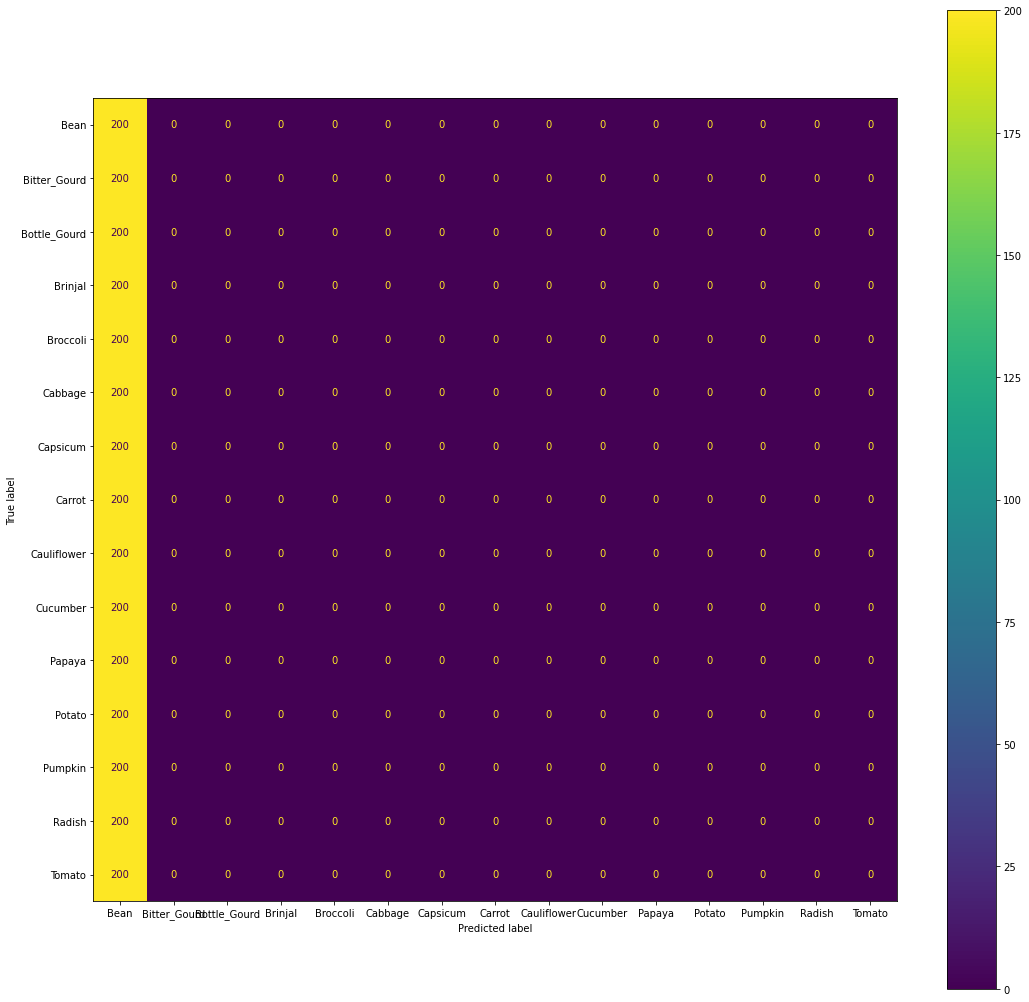

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


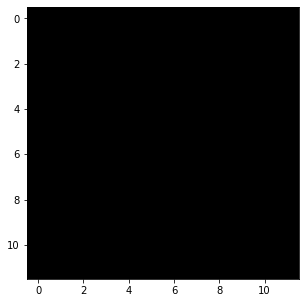

Bitter_Gourd


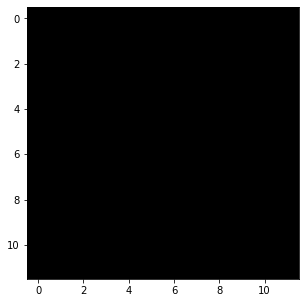

Bottle_Gourd


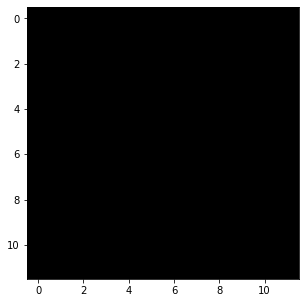

Brinjal


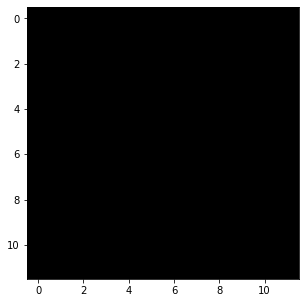

Broccoli


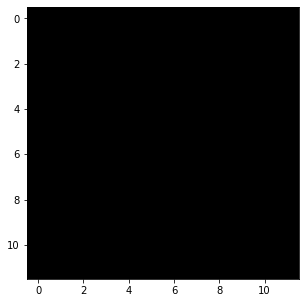

Cabbage


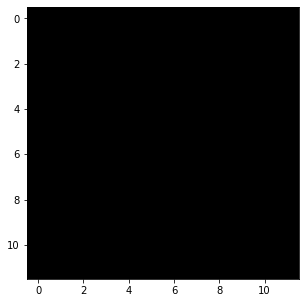

Capsicum


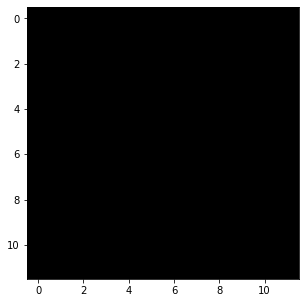

Carrot


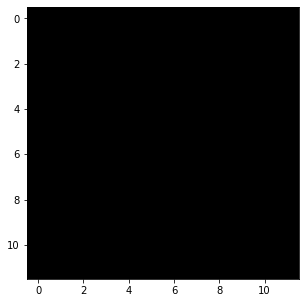

Cauliflower


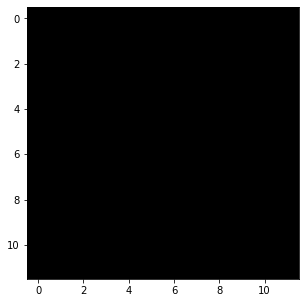

Cucumber


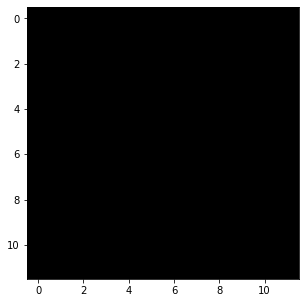

Papaya


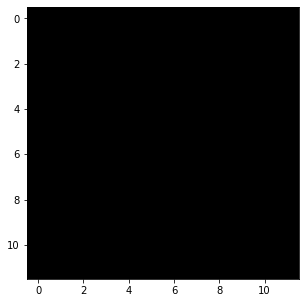

Potato


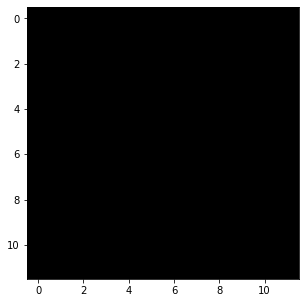

Pumpkin


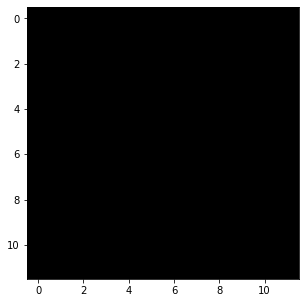

Radish


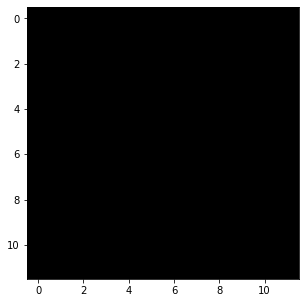

Tomato


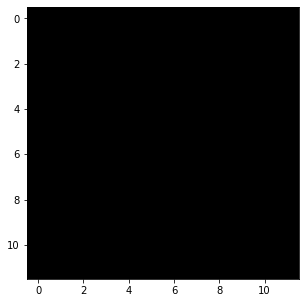

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =64, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.5783205612858735, validation cost = 2.8153514798230517
Train Accuracy: 16.347305389221557 Validation Accuracy: 10.166666666666666
Epoch 2: training cost = 2.4930109223265577, validation cost = 2.8573259645550837
Train Accuracy: 20.412508316699935 Validation Accuracy: 9.5
Epoch 3: training cost = 2.4328344893848275, validation cost = 2.9015720648158094
Train Accuracy: 23.446440452428476 Validation Accuracy: 9.266666666666666
Epoch 4: training cost = 2.3836484121484527, validation cost = 2.943615222741907
Train Accuracy: 25.535595475715233 Validation Accuracy: 9.033333333333333
Epoch 5: training cost = 2.3415939324033097, validation cost = 2.9842726691525083
Train Accuracy: 27.21224218230206 Validation Accuracy: 8.7
Epoch 6: training cost = 2.3049638523167935, validation cost = 3.0227749998128393
Train Accuracy: 28.729208250166334 Validation Accuracy: 8.366666666666667
Epoch 7: training cost = 2.2721629985780853, validation cost = 3.058835258306364
Train Accura

              precision    recall  f1-score   support

           0      0.059     0.065     0.062       200
           1      0.022     0.030     0.025       200
           2      0.063     0.090     0.074       200
           3      0.027     0.020     0.023       200
           4      0.036     0.035     0.035       200
           5      0.067     0.085     0.075       200
           6      0.041     0.040     0.041       200
           7      0.057     0.045     0.050       200
           8      0.054     0.045     0.049       200
           9      0.045     0.020     0.028       200
          10      0.078     0.110     0.091       200
          11      0.286     0.375     0.325       200
          12      0.044     0.035     0.039       200
          13      0.029     0.020     0.024       200
          14      0.058     0.050     0.054       200

    accuracy                          0.071      3000
   macro avg      0.064     0.071     0.066      3000
weighted avg      0.064   

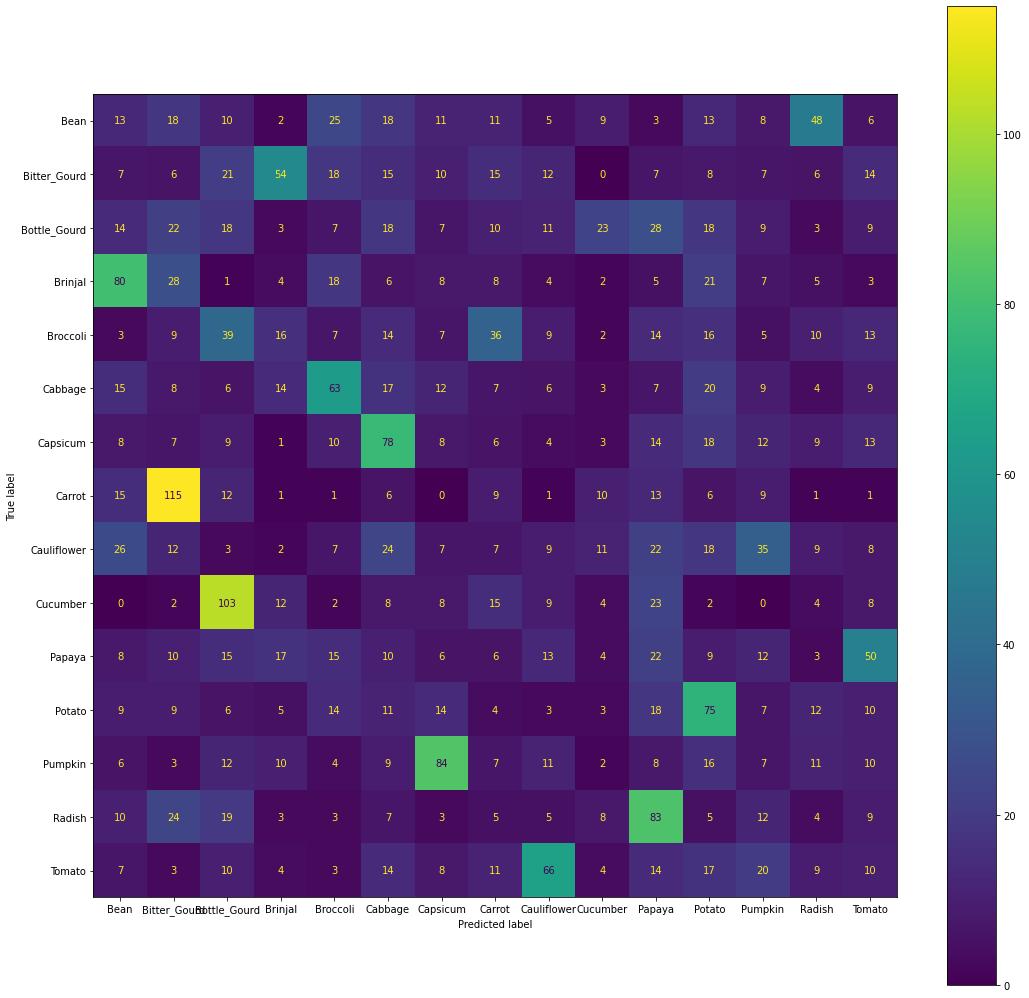

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


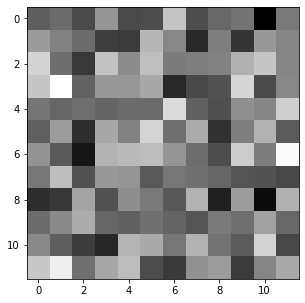

Bitter_Gourd


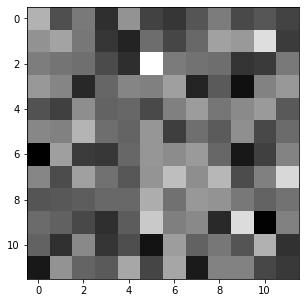

Bottle_Gourd


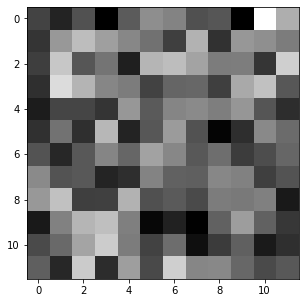

Brinjal


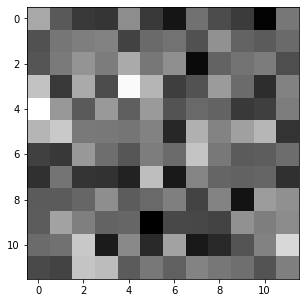

Broccoli


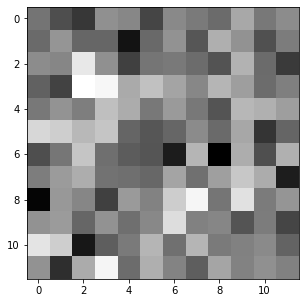

Cabbage


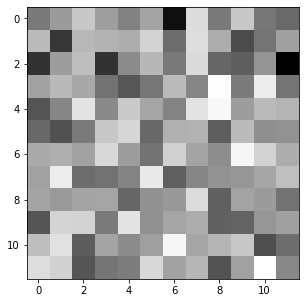

Capsicum


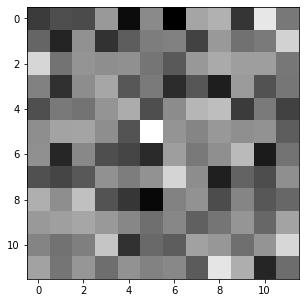

Carrot


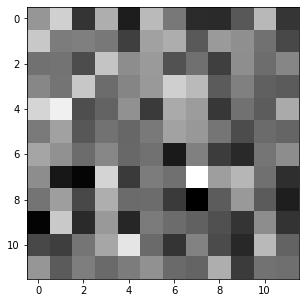

Cauliflower


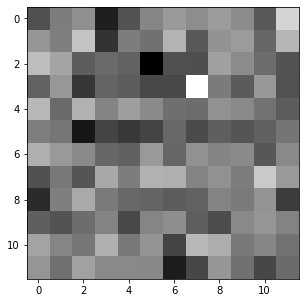

Cucumber


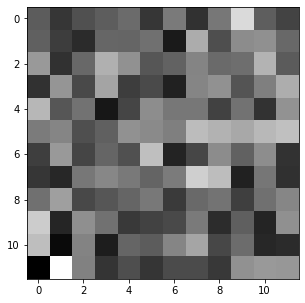

Papaya


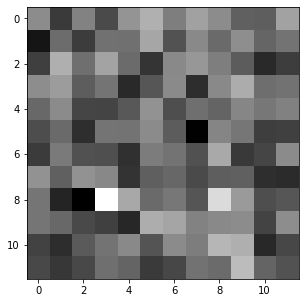

Potato


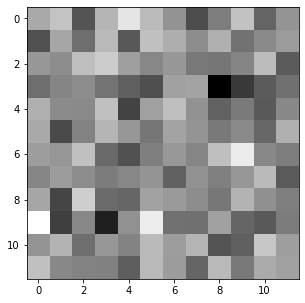

Pumpkin


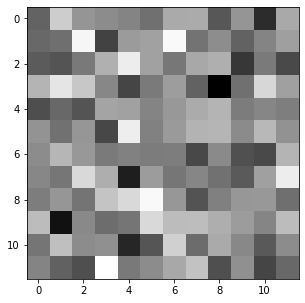

Radish


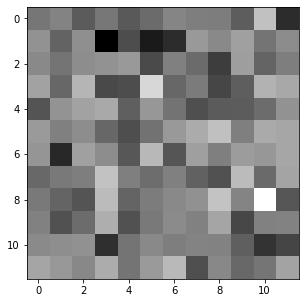

Tomato


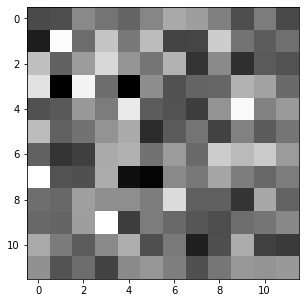

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =128, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =25)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6990906514302195, validation cost = 2.7092904356347116
Train Accuracy: 8.67598137059215 Validation Accuracy: 7.6
Epoch 2: training cost = 2.6889869545187897, validation cost = 2.7086497156047384
Train Accuracy: 10.671989354624085 Validation Accuracy: 7.7
Epoch 3: training cost = 2.6822293568161246, validation cost = 2.7081376731306404
Train Accuracy: 12.315369261477047 Validation Accuracy: 7.733333333333333
Epoch 4: training cost = 2.6772553711592573, validation cost = 2.7078094423413246
Train Accuracy: 13.81902860944777 Validation Accuracy: 7.8
Epoch 5: training cost = 2.6730458484299917, validation cost = 2.707672283248903
Train Accuracy: 15.023286759813706 Validation Accuracy: 7.966666666666667
Epoch 6: training cost = 2.66907839138932, validation cost = 2.7076864363229176
Train Accuracy: 15.854956753160346 Validation Accuracy: 7.8
Epoch 7: training cost = 2.664948467161205, validation cost = 2.7078007102842667
Train Accuracy: 16.4604125083167 Validation A

              precision    recall  f1-score   support

           0      0.022     0.015     0.018       200
           1      0.024     0.045     0.032       200
           2      0.064     0.055     0.059       200
           3      0.034     0.055     0.042       200
           4      0.056     0.120     0.077       200
           5      0.000     0.000     0.000       200
           6      0.086     0.140     0.107       200
           7      0.036     0.040     0.038       200
           8      0.025     0.020     0.022       200
           9      0.000     0.000     0.000       200
          10      0.103     0.065     0.080       200
          11      0.140     0.220     0.171       200
          12      0.043     0.040     0.041       200
          13      0.088     0.015     0.026       200
          14      0.050     0.025     0.033       200

    accuracy                          0.057      3000
   macro avg      0.051     0.057     0.050      3000
weighted avg      0.051   

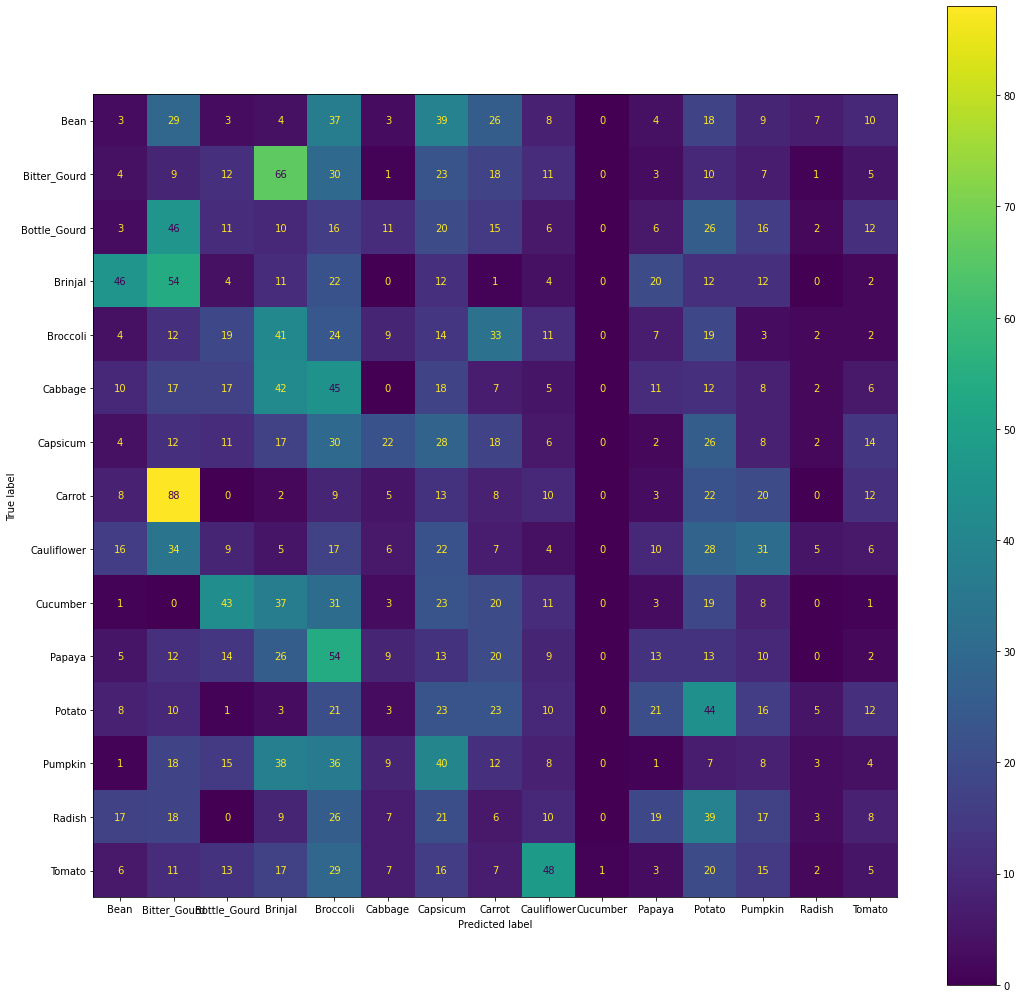

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


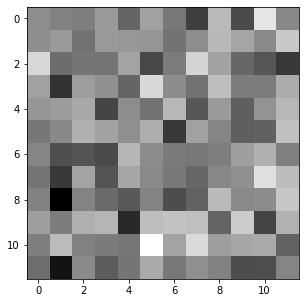

Bitter_Gourd


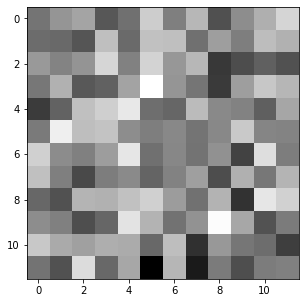

Bottle_Gourd


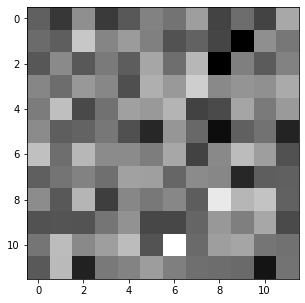

Brinjal


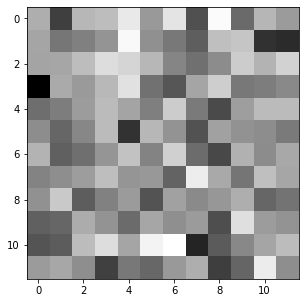

Broccoli


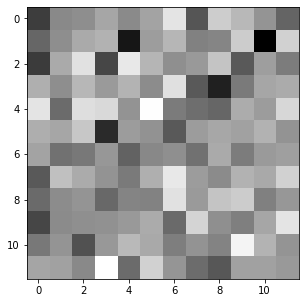

Cabbage


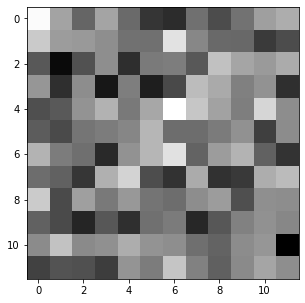

Capsicum


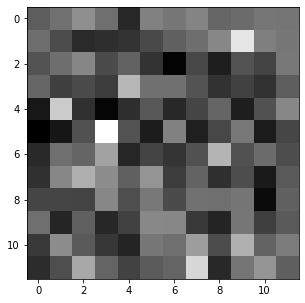

Carrot


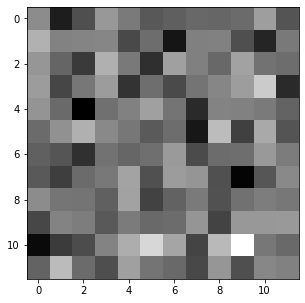

Cauliflower


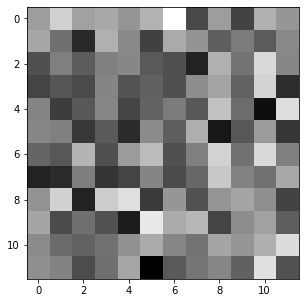

Cucumber


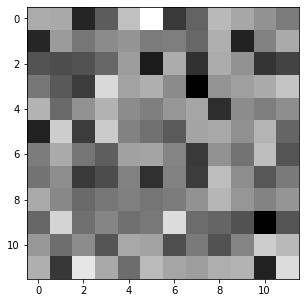

Papaya


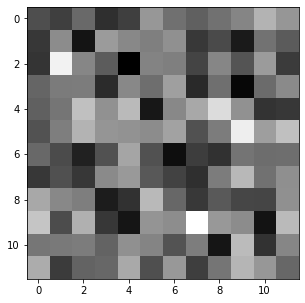

Potato


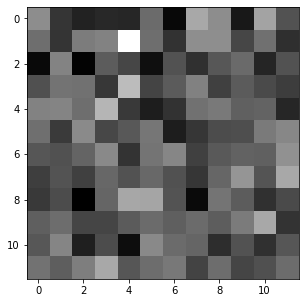

Pumpkin


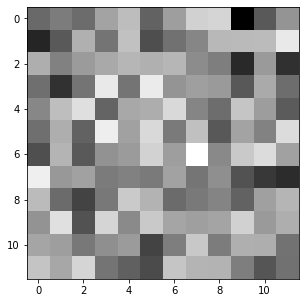

Radish


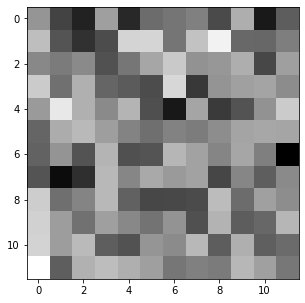

Tomato


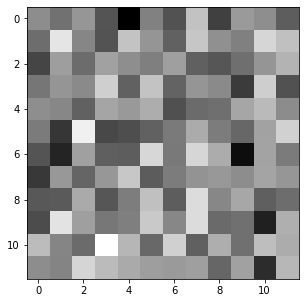

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =128, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.692394607674954, validation cost = 3.021570286894869
Train Accuracy: 12.994011976047904 Validation Accuracy: 6.0
Epoch 2: training cost = 2.5625328263939817, validation cost = 3.0284106233462853
Train Accuracy: 16.69328010645376 Validation Accuracy: 5.766666666666667
Epoch 3: training cost = 2.4892094666823614, validation cost = 3.049701480411232
Train Accuracy: 19.228210246174317 Validation Accuracy: 6.3
Epoch 4: training cost = 2.4377584574212965, validation cost = 3.0750146949146218
Train Accuracy: 20.991350632069196 Validation Accuracy: 6.333333333333334
Epoch 5: training cost = 2.3970193870492045, validation cost = 3.1061933148134315
Train Accuracy: 22.821024617431803 Validation Accuracy: 6.533333333333332
Epoch 6: training cost = 2.3631147155876007, validation cost = 3.1335237021747013
Train Accuracy: 24.35129740518962 Validation Accuracy: 6.466666666666667
Epoch 7: training cost = 2.33368559499905, validation cost = 3.1603172571929488
Train Accuracy: 2

              precision    recall  f1-score   support

           0      0.019     0.015     0.017       200
           1      0.000     0.000     0.000       200
           2      0.084     0.070     0.076       200
           3      0.027     0.020     0.023       200
           4      0.030     0.015     0.020       200
           5      0.055     0.090     0.068       200
           6      0.080     0.090     0.085       200
           7      0.045     0.125     0.067       200
           8      0.070     0.045     0.055       200
           9      0.016     0.010     0.012       200
          10      0.071     0.150     0.097       200
          11      0.364     0.260     0.303       200
          12      0.032     0.020     0.025       200
          13      0.050     0.030     0.037       200
          14      0.060     0.045     0.051       200

    accuracy                          0.066      3000
   macro avg      0.067     0.066     0.062      3000
weighted avg      0.067   

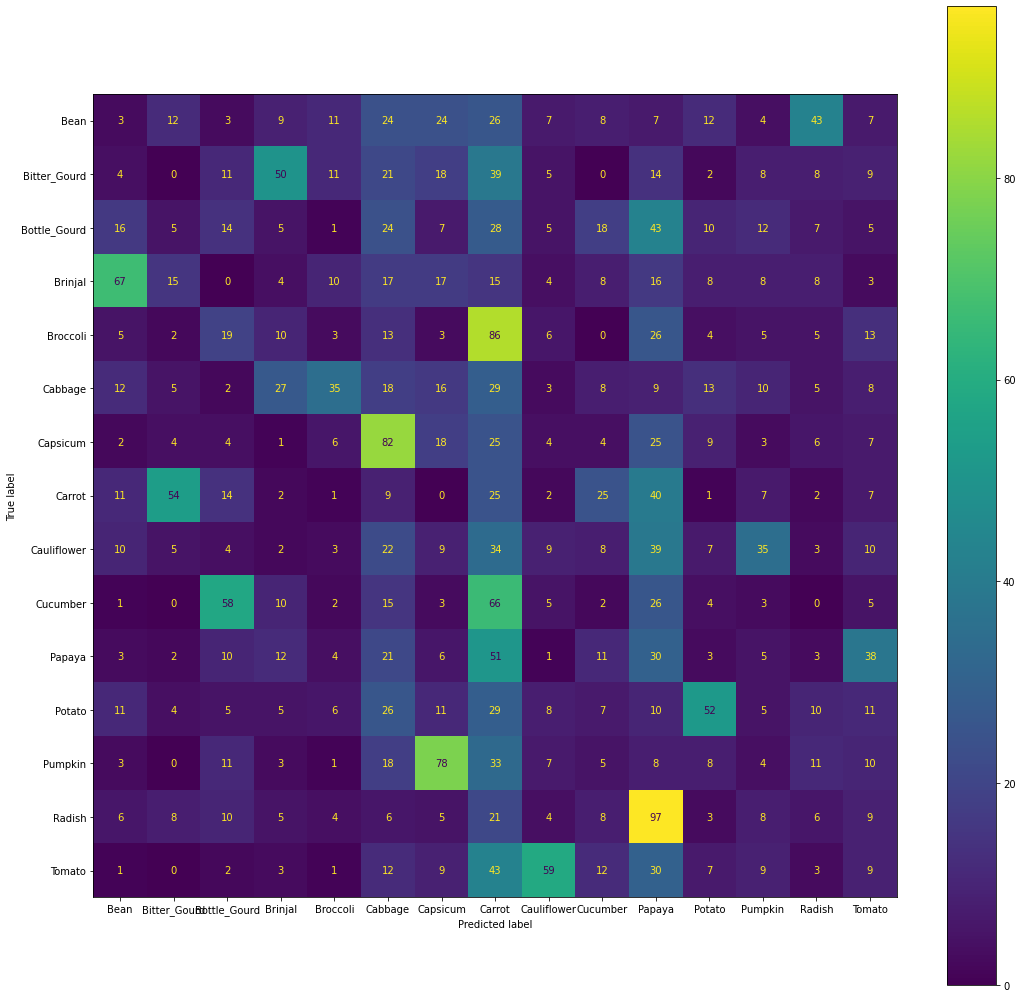

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


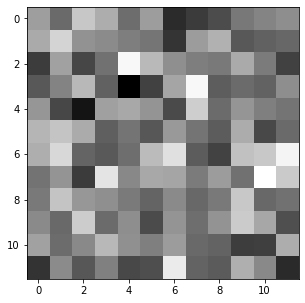

Bitter_Gourd


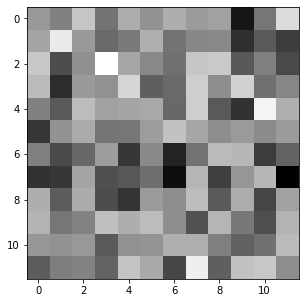

Bottle_Gourd


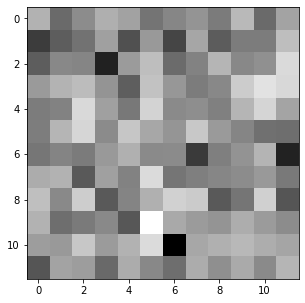

Brinjal


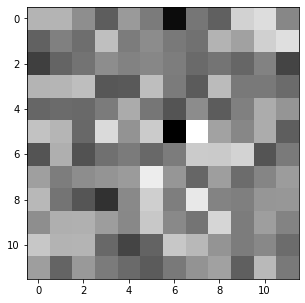

Broccoli


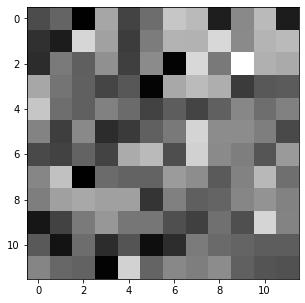

Cabbage


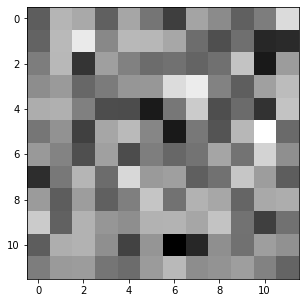

Capsicum


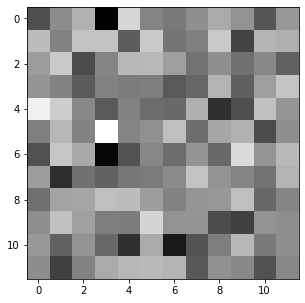

Carrot


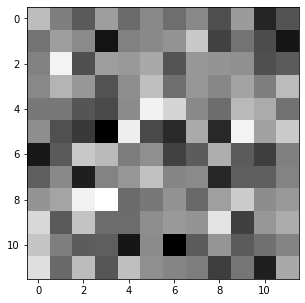

Cauliflower


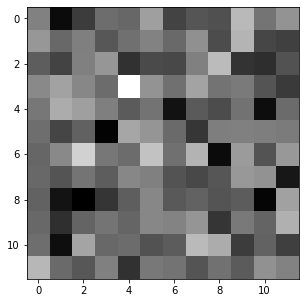

Cucumber


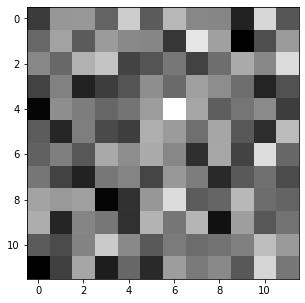

Papaya


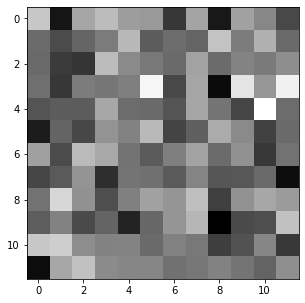

Potato


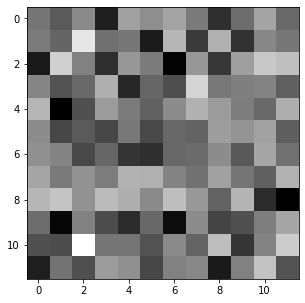

Pumpkin


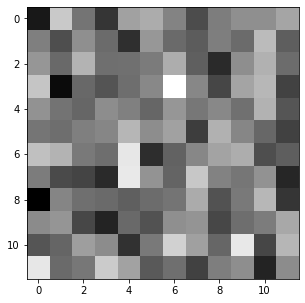

Radish


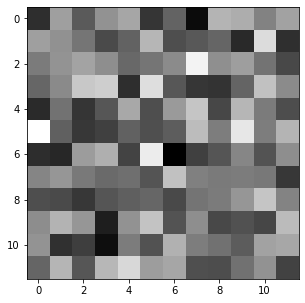

Tomato


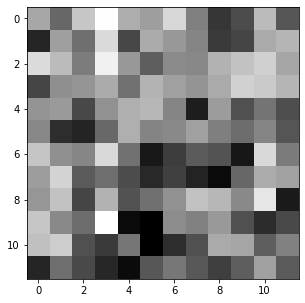

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.005, batch_size =128, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6751795059718226, validation cost = 2.835750218479136
Train Accuracy: 11.224218230206255 Validation Accuracy: 5.800000000000001
Epoch 2: training cost = 2.595756552960447, validation cost = 2.8364678487673203
Train Accuracy: 14.690618762475049 Validation Accuracy: 6.6000000000000005
Epoch 3: training cost = 2.5404385443419746, validation cost = 2.85361253225316
Train Accuracy: 17.578176979374586 Validation Accuracy: 6.9
Epoch 4: training cost = 2.4978588916197366, validation cost = 2.8756917562855016
Train Accuracy: 19.560878243512974 Validation Accuracy: 6.800000000000001
Epoch 5: training cost = 2.4626699028204015, validation cost = 2.89893665594169
Train Accuracy: 21.21091151031271 Validation Accuracy: 7.133333333333333
Epoch 6: training cost = 2.4323228798236385, validation cost = 2.922481218045882
Train Accuracy: 22.60146373918829 Validation Accuracy: 7.3999999999999995
Epoch 7: training cost = 2.405558720155326, validation cost = 2.9458671227607605
Trai

              precision    recall  f1-score   support

           0      0.048     0.045     0.047       200
           1      0.025     0.040     0.031       200
           2      0.076     0.090     0.082       200
           3      0.054     0.055     0.054       200
           4      0.033     0.030     0.031       200
           5      0.024     0.025     0.025       200
           6      0.057     0.060     0.059       200
           7      0.049     0.045     0.047       200
           8      0.066     0.065     0.065       200
           9      0.045     0.015     0.023       200
          10      0.073     0.115     0.089       200
          11      0.298     0.340     0.318       200
          12      0.068     0.060     0.064       200
          13      0.053     0.035     0.042       200
          14      0.063     0.050     0.056       200

    accuracy                          0.071      3000
   macro avg      0.069     0.071     0.069      3000
weighted avg      0.069   

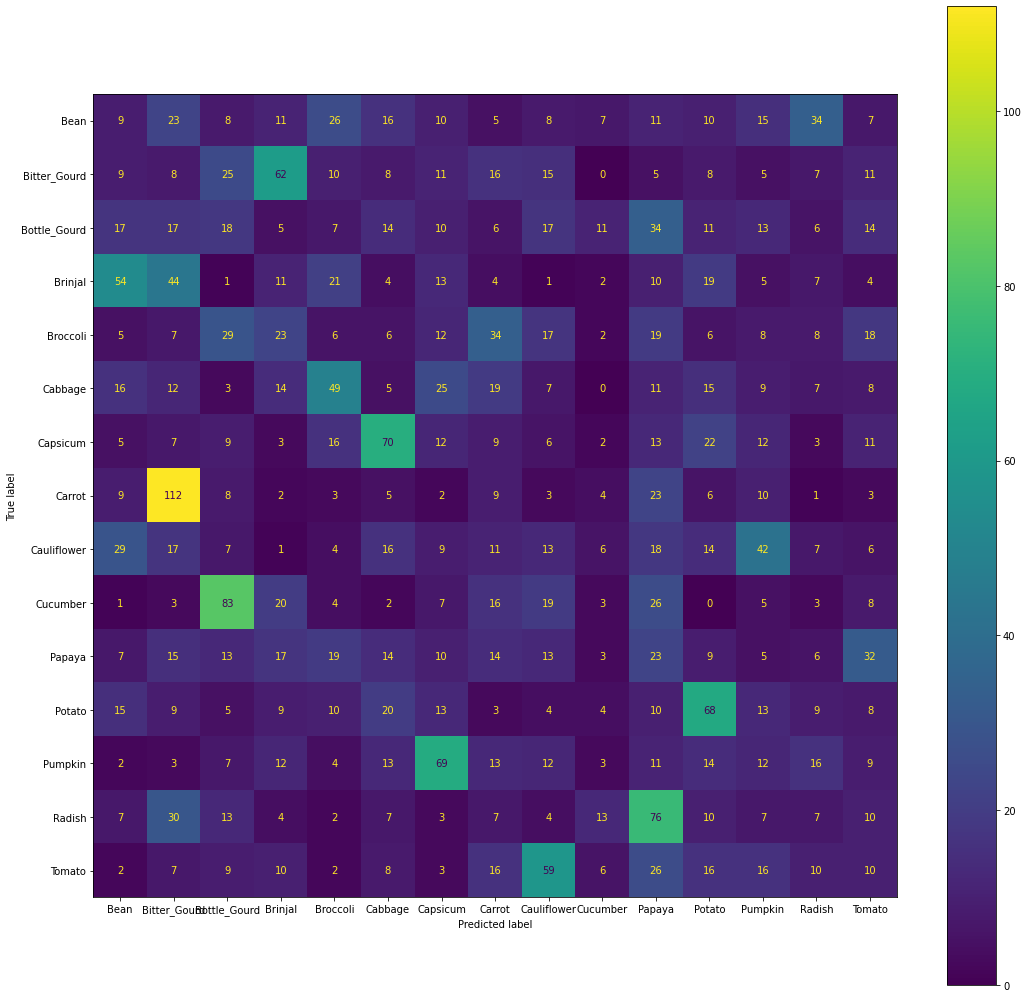

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


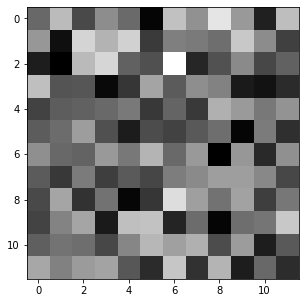

Bitter_Gourd


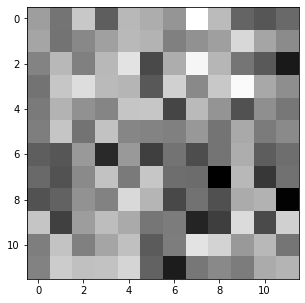

Bottle_Gourd


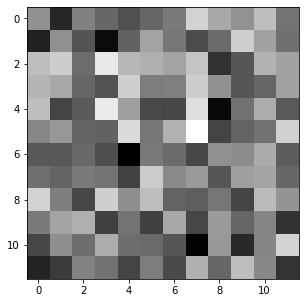

Brinjal


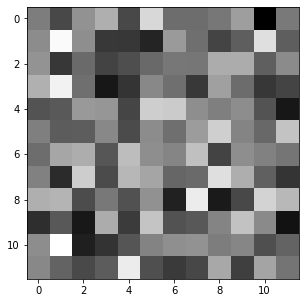

Broccoli


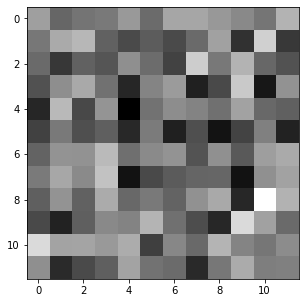

Cabbage


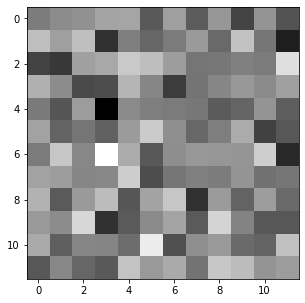

Capsicum


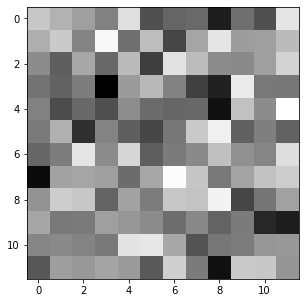

Carrot


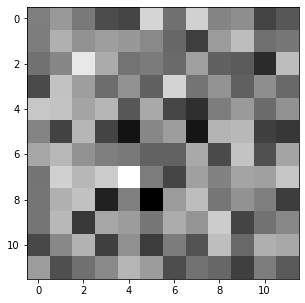

Cauliflower


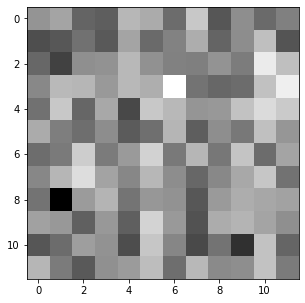

Cucumber


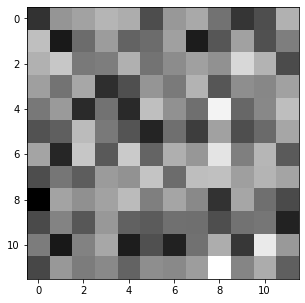

Papaya


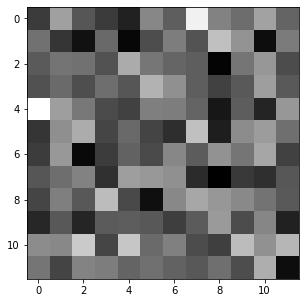

Potato


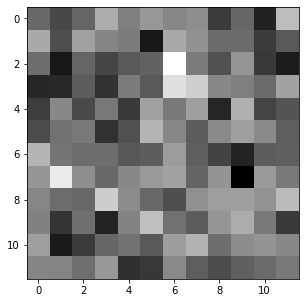

Pumpkin


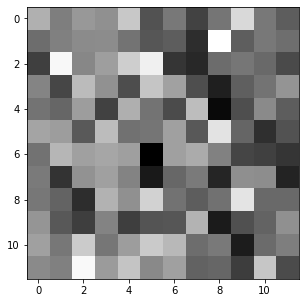

Radish


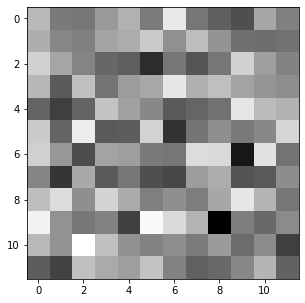

Tomato


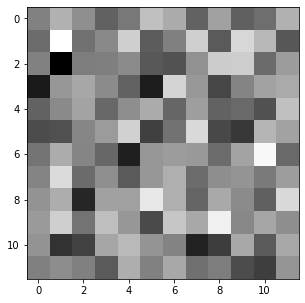

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =16, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6423734170104805, validation cost = 2.7379187156885334
Train Accuracy: 13.426480372588156 Validation Accuracy: 7.2666666666666675
Epoch 2: training cost = 2.604434597945905, validation cost = 2.7604170431082133
Train Accuracy: 15.442448436460413 Validation Accuracy: 6.033333333333333
Epoch 3: training cost = 2.573071425720322, validation cost = 2.79431751000344
Train Accuracy: 17.092481703260145 Validation Accuracy: 5.433333333333333
Epoch 4: training cost = 2.5448148835993245, validation cost = 2.8342844219589556
Train Accuracy: 18.349966733200265 Validation Accuracy: 5.733333333333333
Epoch 5: training cost = 2.5264904130691384, validation cost = 2.8637932061401346
Train Accuracy: 18.61610113107119 Validation Accuracy: 6.166666666666667
Epoch 6: training cost = 2.5171713999247007, validation cost = 2.878744292990928
Train Accuracy: 18.7624750499002 Validation Accuracy: 6.333333333333334
Epoch 7: training cost = 2.512025725096953, validation cost = 2.8875218

              precision    recall  f1-score   support

           0      0.050     0.030     0.038       200
           1      0.028     0.055     0.037       200
           2      0.006     0.005     0.006       200
           3      0.044     0.030     0.036       200
           4      0.079     0.105     0.090       200
           5      0.054     0.220     0.086       200
           6      0.017     0.005     0.008       200
           7      0.014     0.010     0.012       200
           8      0.032     0.015     0.020       200
           9      0.000     0.000     0.000       200
          10      0.156     0.025     0.043       200
          11      0.119     0.435     0.187       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.062      3000
   macro avg      0.040     0.062     0.037      3000
weighted avg      0.040   

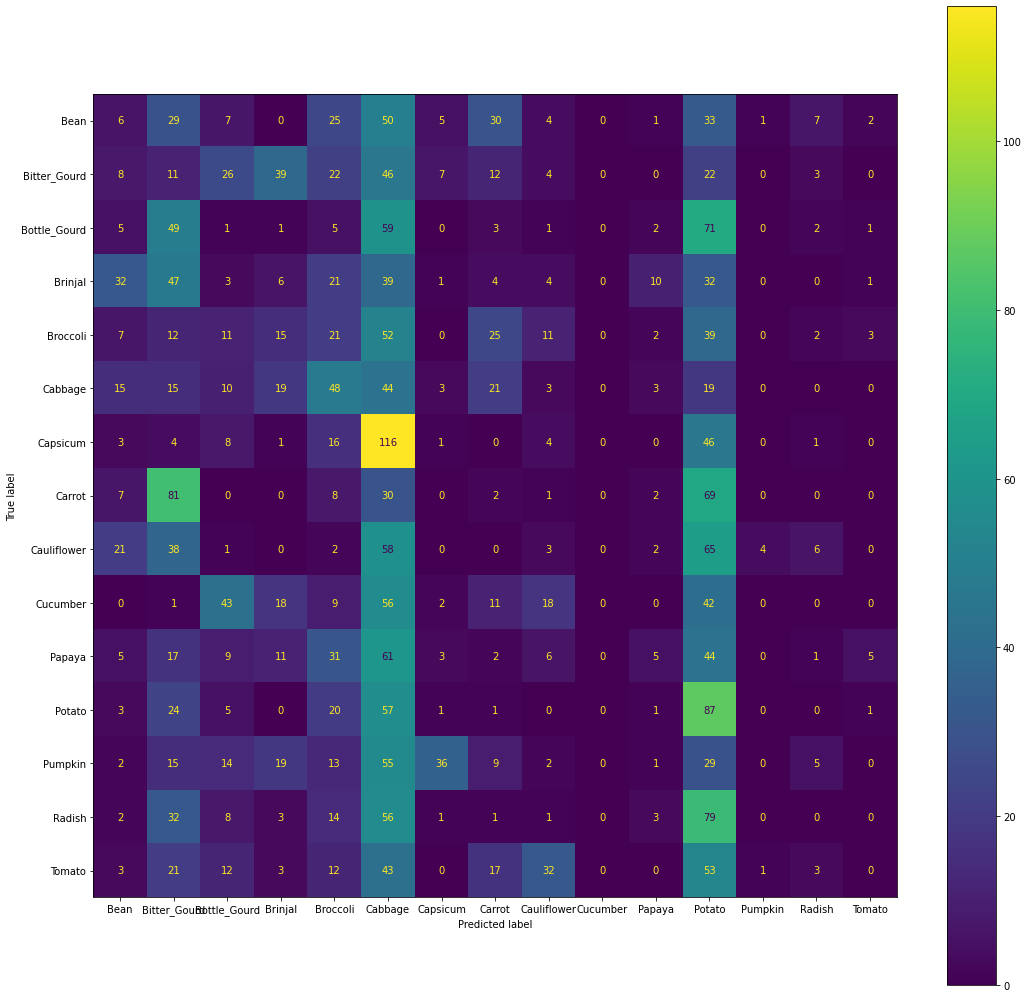

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


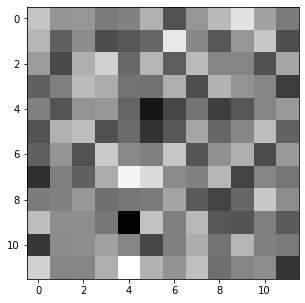

Bitter_Gourd


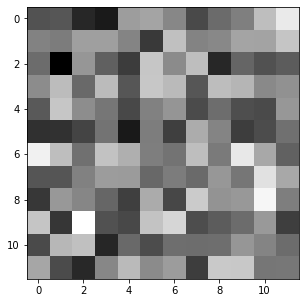

Bottle_Gourd


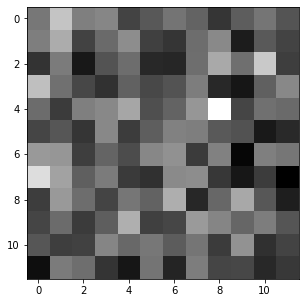

Brinjal


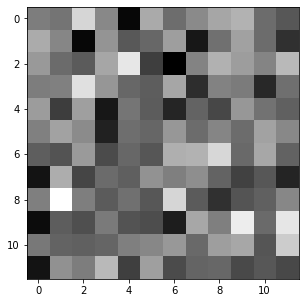

Broccoli


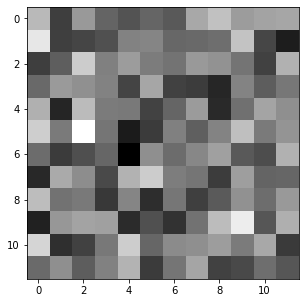

Cabbage


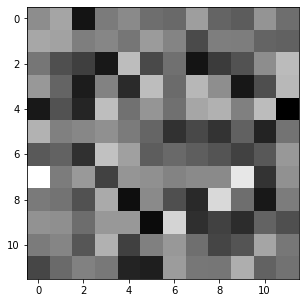

Capsicum


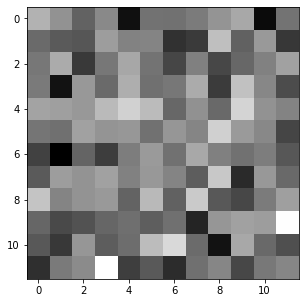

Carrot


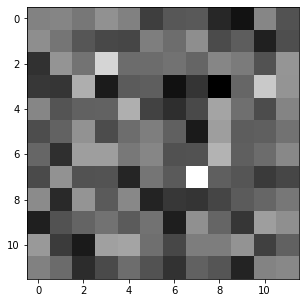

Cauliflower


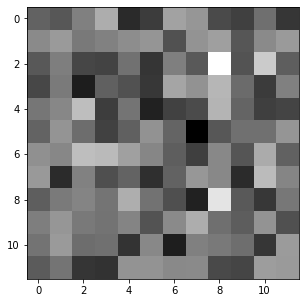

Cucumber


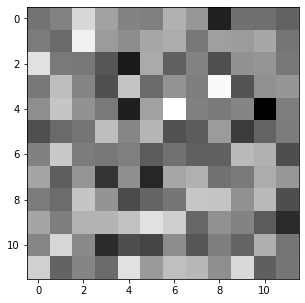

Papaya


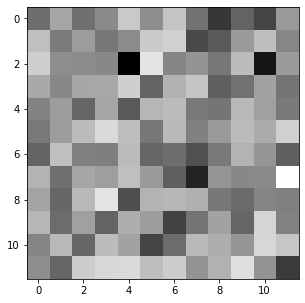

Potato


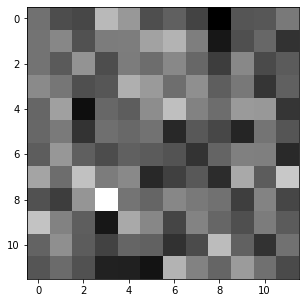

Pumpkin


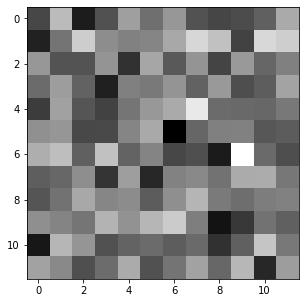

Radish


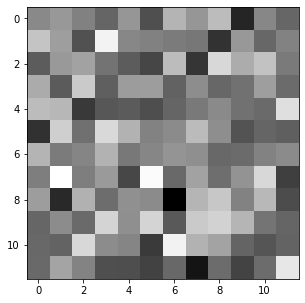

Tomato


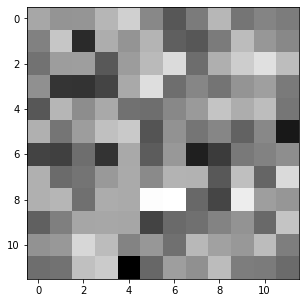

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =16, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

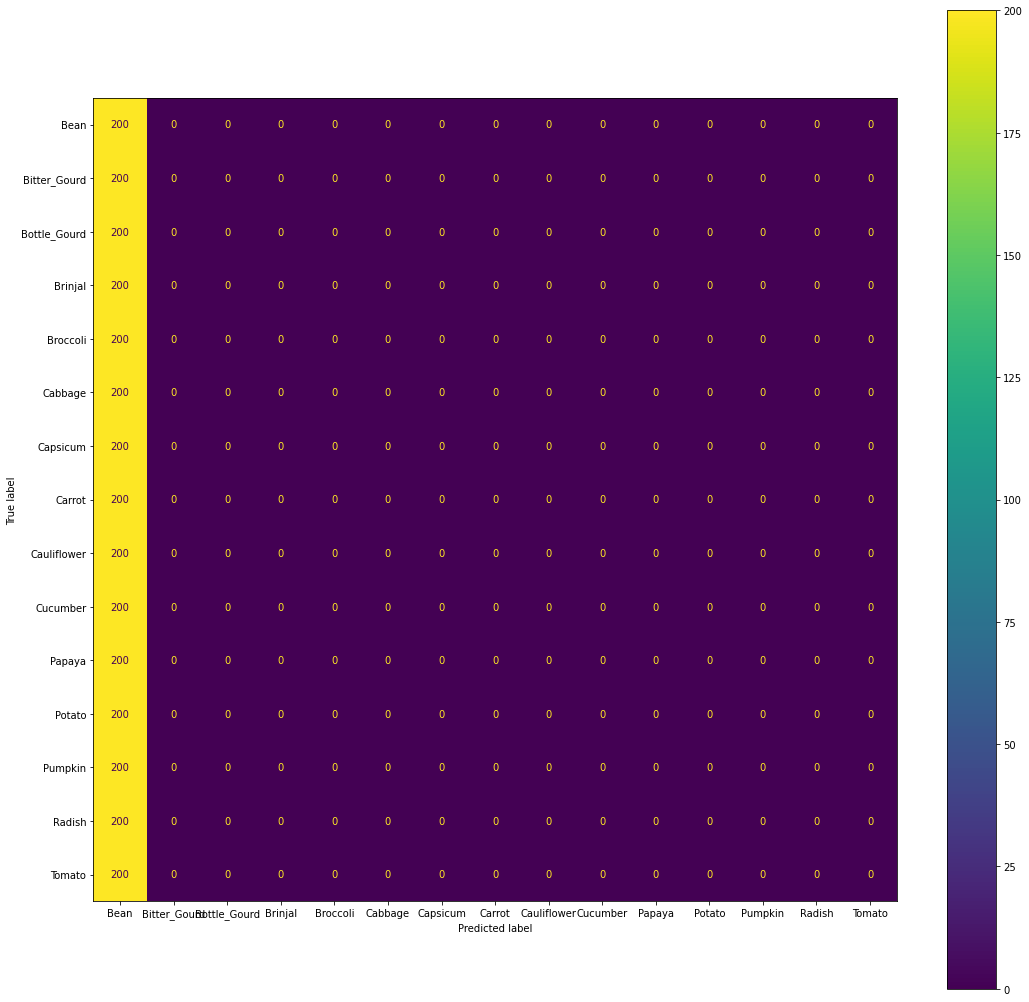

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


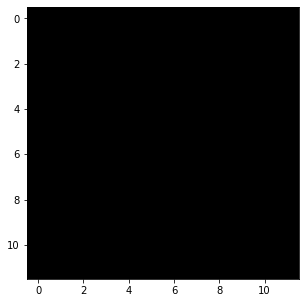

Bitter_Gourd


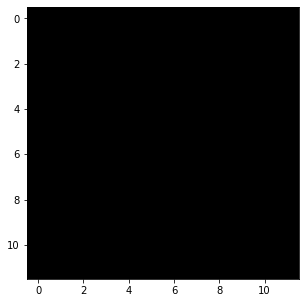

Bottle_Gourd


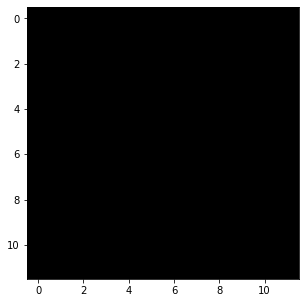

Brinjal


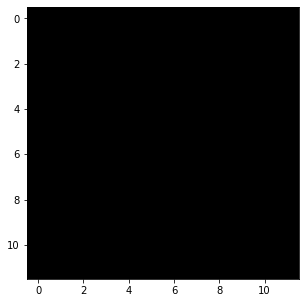

Broccoli


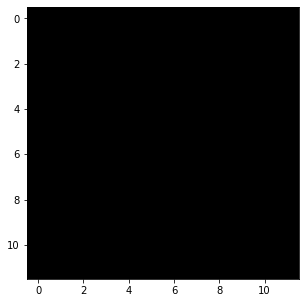

Cabbage


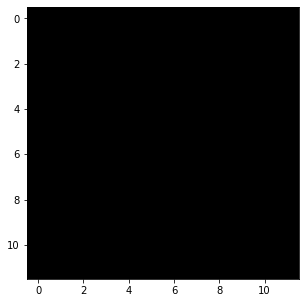

Capsicum


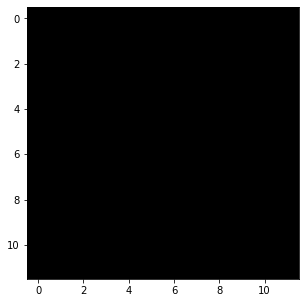

Carrot


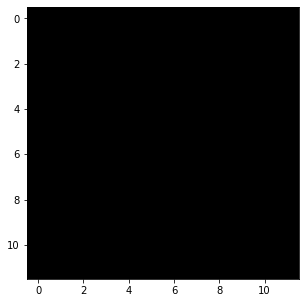

Cauliflower


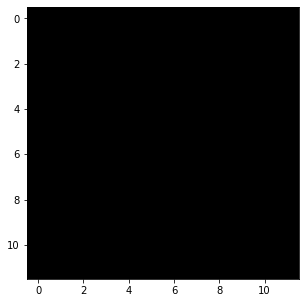

Cucumber


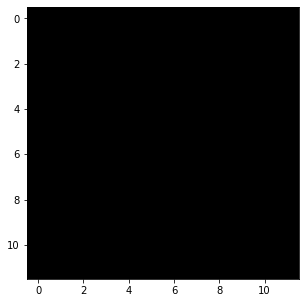

Papaya


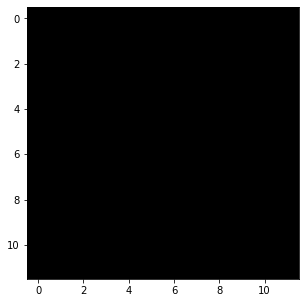

Potato


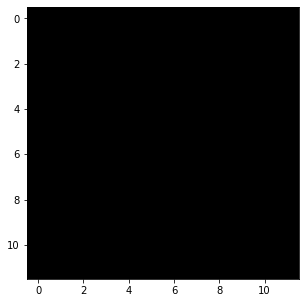

Pumpkin


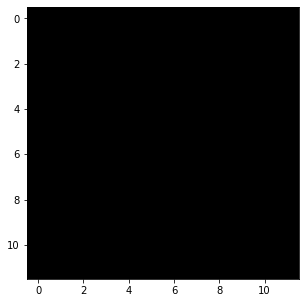

Radish


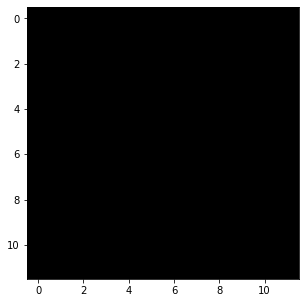

Tomato


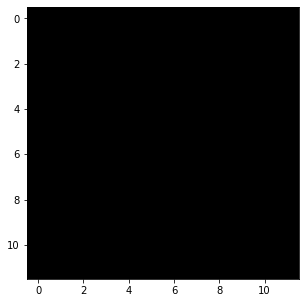

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =16, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.3053880284352, validation cost = 3.083715733104747
Train Accuracy: 28.38323353293413 Validation Accuracy: 7.066666666666667
Epoch 2: training cost = 2.139234980198481, validation cost = 3.2649524268452175
Train Accuracy: 33.77910844976713 Validation Accuracy: 7.199999999999999
Epoch 3: training cost = 2.01068333020183, validation cost = 3.4191450483280077
Train Accuracy: 37.73785761809714 Validation Accuracy: 7.166666666666667
Epoch 4: training cost = 1.9006477344422001, validation cost = 3.5638278411241093
Train Accuracy: 40.87824351297405 Validation Accuracy: 7.2666666666666675
Epoch 5: training cost = 1.8039091372691076, validation cost = 3.7047295113237824
Train Accuracy: 43.9853626081171 Validation Accuracy: 7.000000000000001
Epoch 6: training cost = 1.7153286884092496, validation cost = 3.8425855957737625
Train Accuracy: 46.73985362608117 Validation Accuracy: 7.033333333333333
Epoch 7: training cost = 1.6313917866746217, validation cost = 3.976356886653

              precision    recall  f1-score   support

           0      0.057     0.075     0.065       200
           1      0.014     0.015     0.014       200
           2      0.047     0.045     0.046       200
           3      0.019     0.015     0.017       200
           4      0.028     0.030     0.029       200
           5      0.030     0.045     0.036       200
           6      0.018     0.020     0.019       200
           7      0.034     0.040     0.037       200
           8      0.048     0.030     0.037       200
           9      0.026     0.030     0.028       200
          10      0.036     0.030     0.033       200
          11      0.459     0.505     0.481       200
          12      0.050     0.030     0.037       200
          13      0.008     0.005     0.006       200
          14      0.033     0.035     0.034       200

    accuracy                          0.063      3000
   macro avg      0.060     0.063     0.061      3000
weighted avg      0.060   

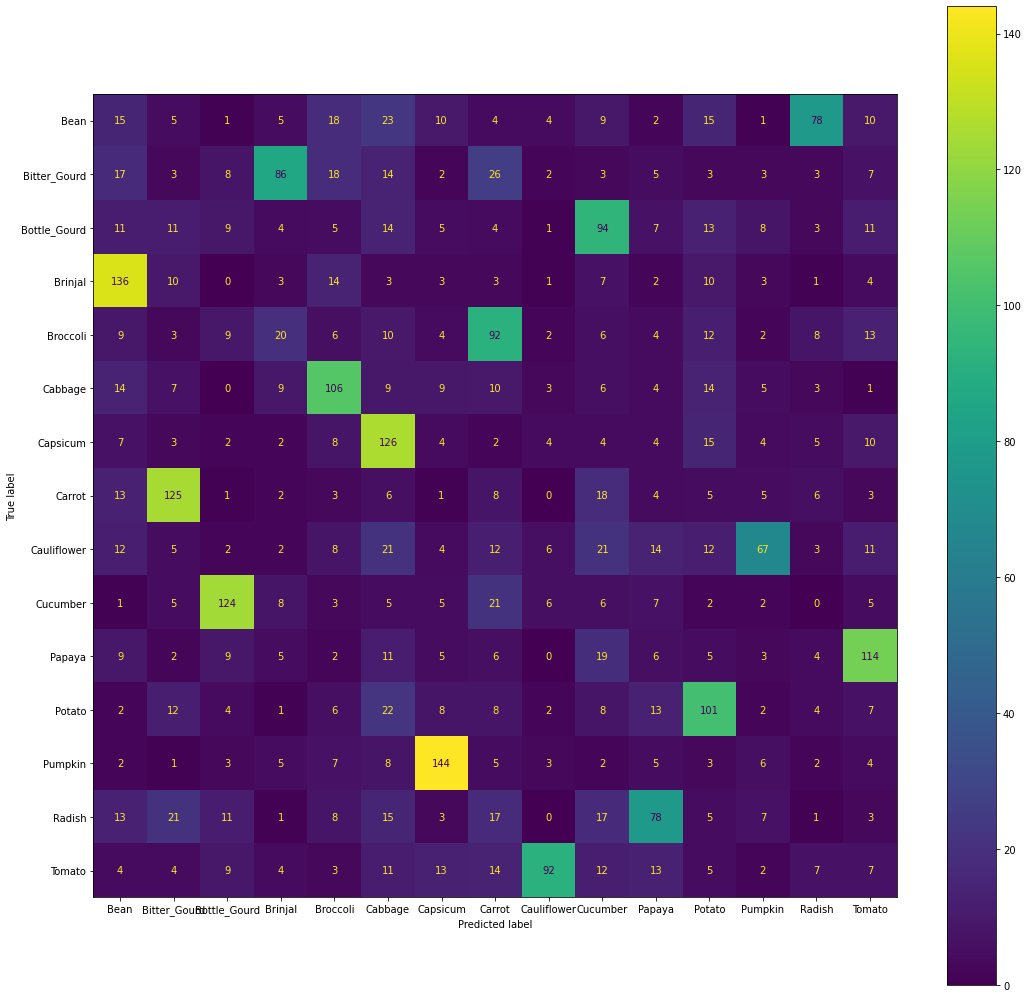

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


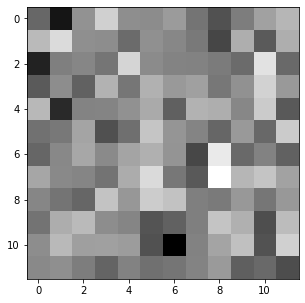

Bitter_Gourd


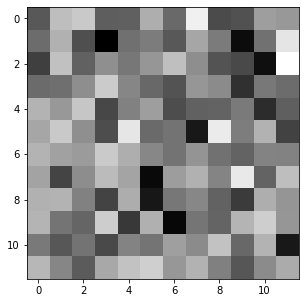

Bottle_Gourd


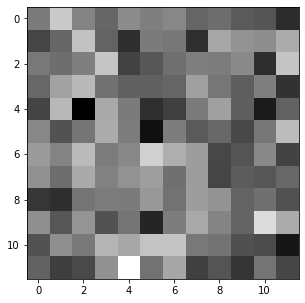

Brinjal


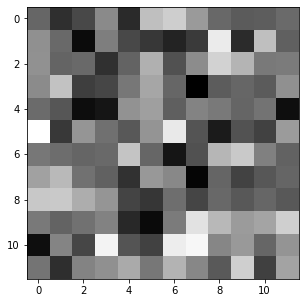

Broccoli


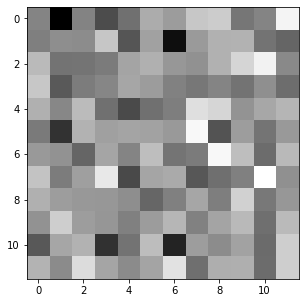

Cabbage


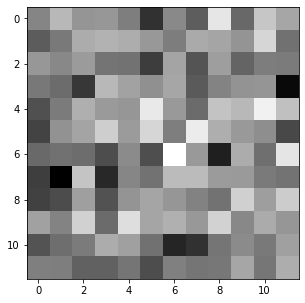

Capsicum


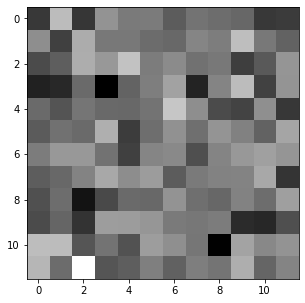

Carrot


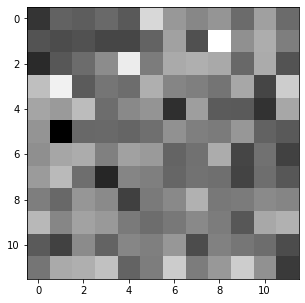

Cauliflower


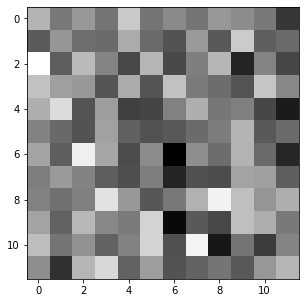

Cucumber


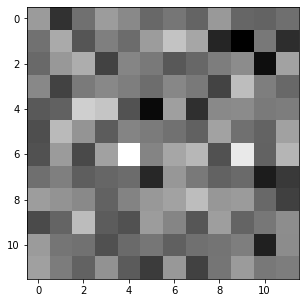

Papaya


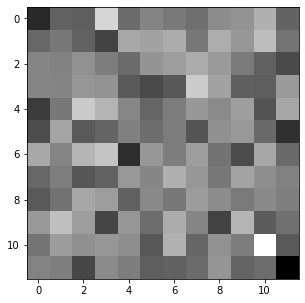

Potato


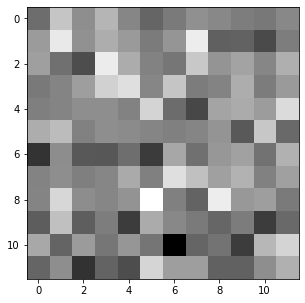

Pumpkin


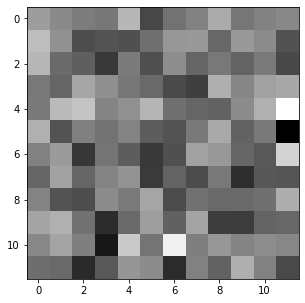

Radish


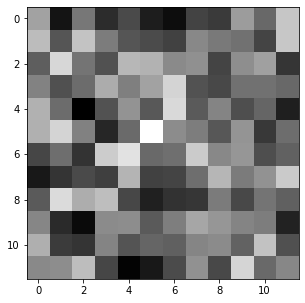

Tomato


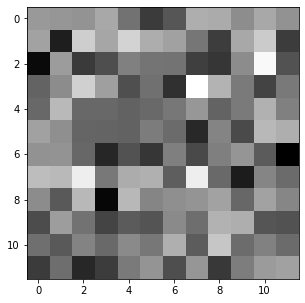

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =32, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6606929001779385, validation cost = 2.7200629030506067
Train Accuracy: 11.02461743180306 Validation Accuracy: 8.433333333333334
Epoch 2: training cost = 2.6307753754833483, validation cost = 2.7263685070073147
Train Accuracy: 13.253493013972056 Validation Accuracy: 8.1
Epoch 3: training cost = 2.6076671558987066, validation cost = 2.7375097969505804
Train Accuracy: 15.355954757152363 Validation Accuracy: 8.166666666666666
Epoch 4: training cost = 2.585341539169801, validation cost = 2.751947876366941
Train Accuracy: 17.391882900864935 Validation Accuracy: 7.333333333333333
Epoch 5: training cost = 2.5655566264872522, validation cost = 2.769840199039844
Train Accuracy: 18.416500332667997 Validation Accuracy: 6.633333333333333
Epoch 6: training cost = 2.5484624395087536, validation cost = 2.7898170537718037
Train Accuracy: 19.16167664670659 Validation Accuracy: 6.366666666666666
Epoch 7: training cost = 2.5340754898467495, validation cost = 2.8083557435459285
T

              precision    recall  f1-score   support

           0      0.037     0.020     0.026       200
           1      0.025     0.050     0.033       200
           2      0.070     0.070     0.070       200
           3      0.032     0.030     0.031       200
           4      0.042     0.055     0.048       200
           5      0.032     0.050     0.039       200
           6      0.026     0.015     0.019       200
           7      0.000     0.000     0.000       200
           8      0.107     0.125     0.115       200
           9      0.067     0.015     0.024       200
          10      0.050     0.015     0.023       200
          11      0.197     0.525     0.287       200
          12      0.037     0.030     0.033       200
          13      0.129     0.090     0.106       200
          14      0.050     0.025     0.033       200

    accuracy                          0.074      3000
   macro avg      0.060     0.074     0.059      3000
weighted avg      0.060   

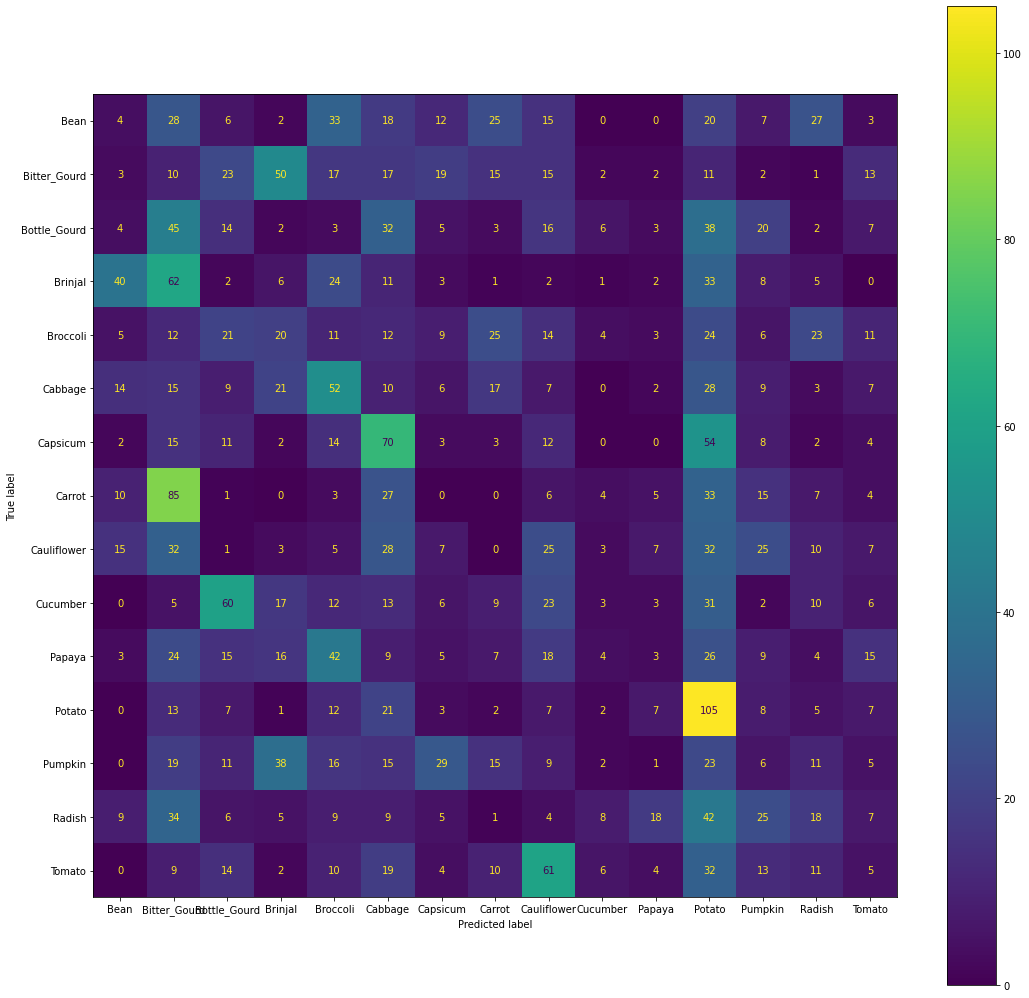

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


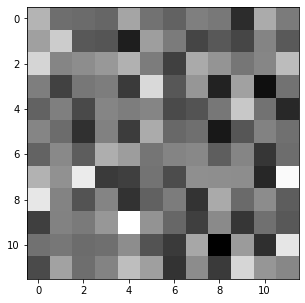

Bitter_Gourd


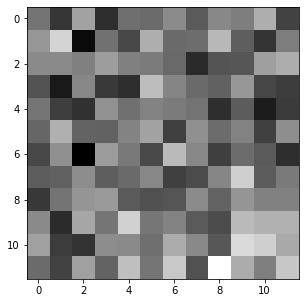

Bottle_Gourd


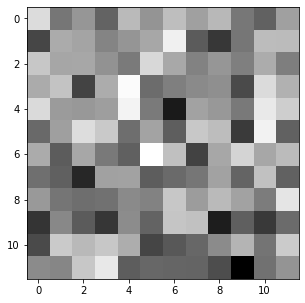

Brinjal


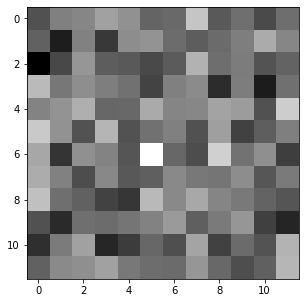

Broccoli


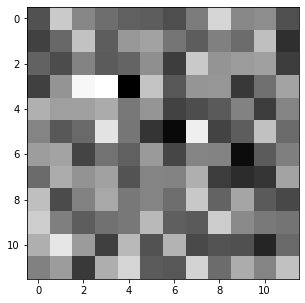

Cabbage


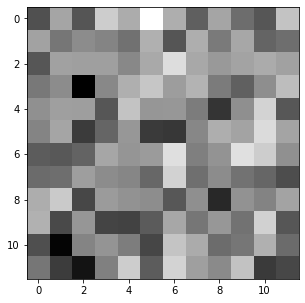

Capsicum


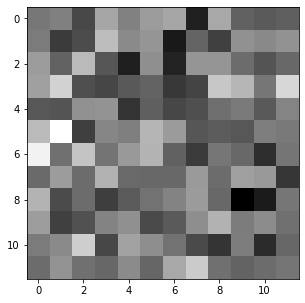

Carrot


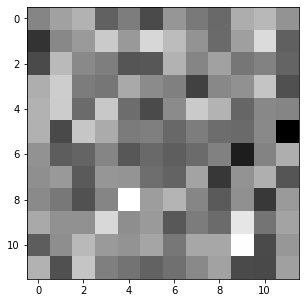

Cauliflower


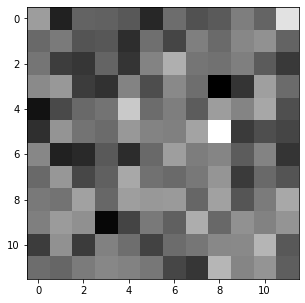

Cucumber


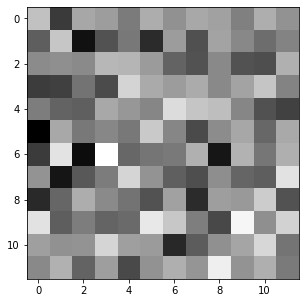

Papaya


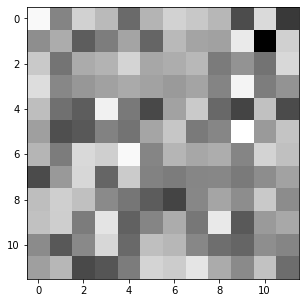

Potato


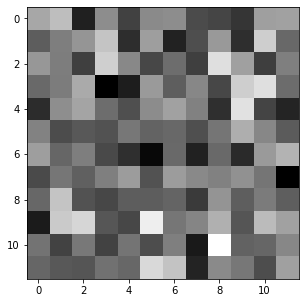

Pumpkin


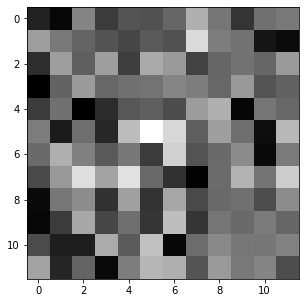

Radish


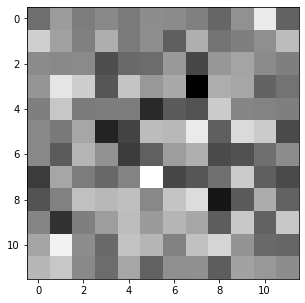

Tomato


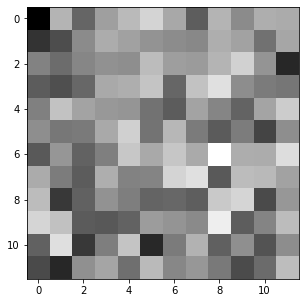

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =32, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

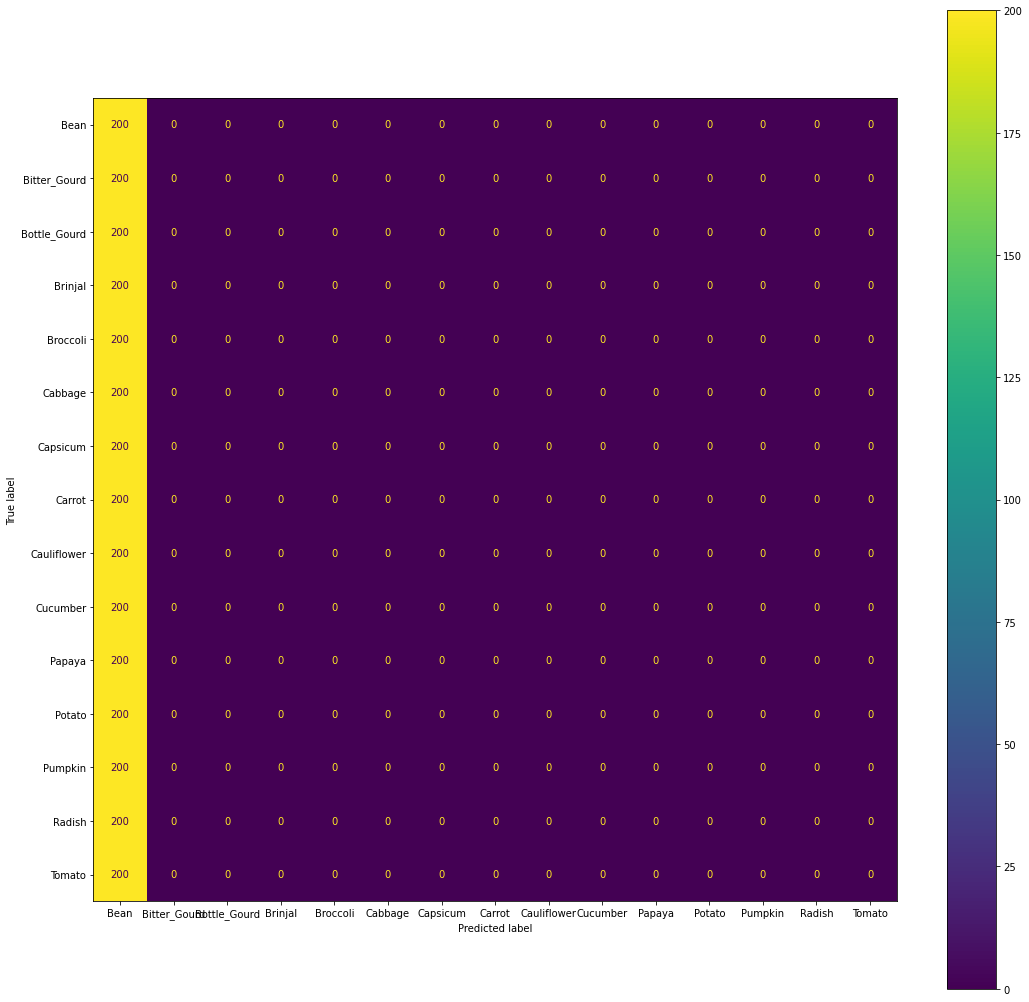

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


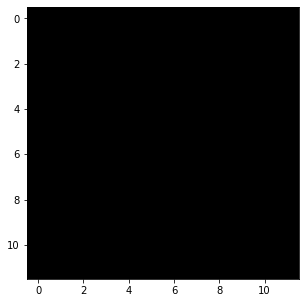

Bitter_Gourd


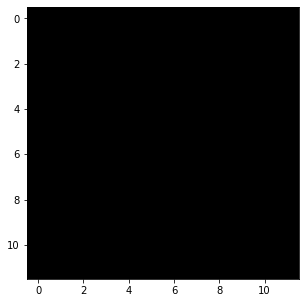

Bottle_Gourd


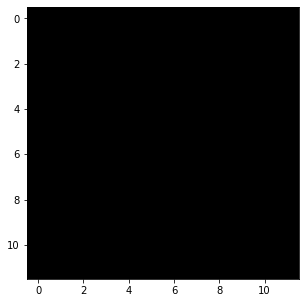

Brinjal


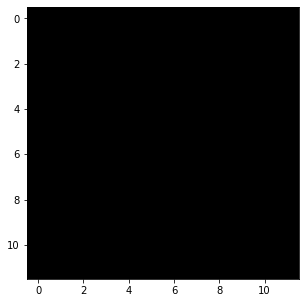

Broccoli


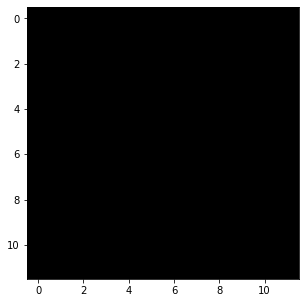

Cabbage


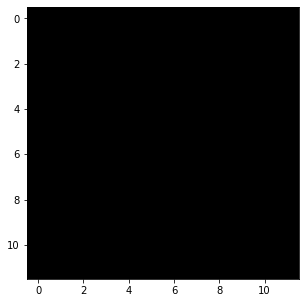

Capsicum


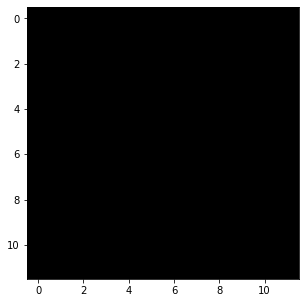

Carrot


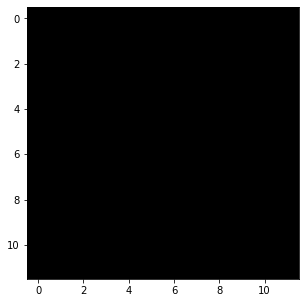

Cauliflower


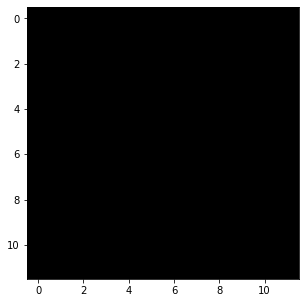

Cucumber


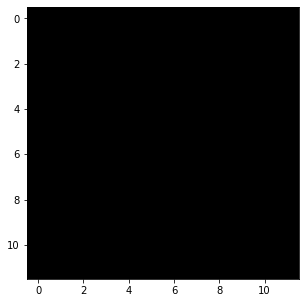

Papaya


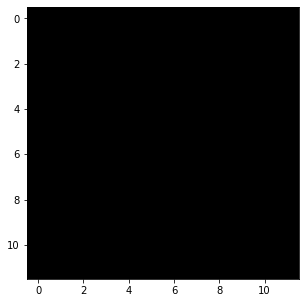

Potato


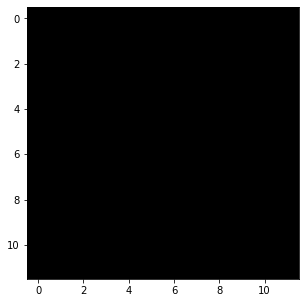

Pumpkin


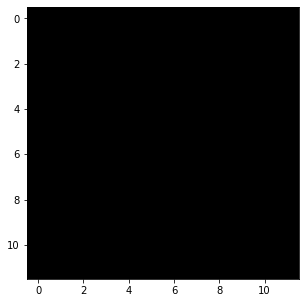

Radish


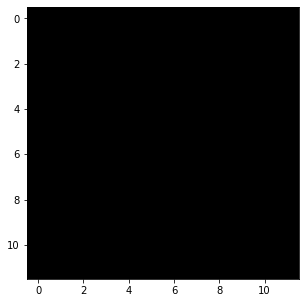

Tomato


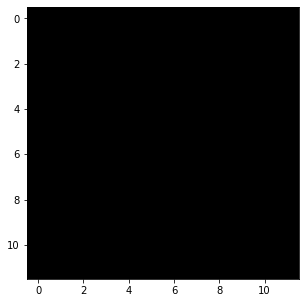

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =32, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.405221721270762, validation cost = 2.9477229526606217
Train Accuracy: 23.759148369926812 Validation Accuracy: 7.633333333333334
Epoch 2: training cost = 2.2757631783489893, validation cost = 3.1002054843464033
Train Accuracy: 28.89554224883566 Validation Accuracy: 7.366666666666667
Epoch 3: training cost = 2.1820828996538433, validation cost = 3.212260852721693
Train Accuracy: 32.18230206254159 Validation Accuracy: 7.199999999999999
Epoch 4: training cost = 2.101837902037174, validation cost = 3.309271332259776
Train Accuracy: 34.8502994011976 Validation Accuracy: 7.366666666666667
Epoch 5: training cost = 2.030635789752168, validation cost = 3.398316188581202
Train Accuracy: 36.93280106453759 Validation Accuracy: 7.233333333333333
Epoch 6: training cost = 1.9657113881498725, validation cost = 3.482121951066477
Train Accuracy: 39.16167664670659 Validation Accuracy: 7.133333333333333
Epoch 7: training cost = 1.905223699219575, validation cost = 3.5619960537521

              precision    recall  f1-score   support

           0      0.031     0.025     0.028       200
           1      0.038     0.065     0.048       200
           2      0.081     0.145     0.104       200
           3      0.020     0.015     0.017       200
           4      0.022     0.015     0.018       200
           5      0.038     0.035     0.036       200
           6      0.034     0.050     0.040       200
           7      0.017     0.020     0.018       200
           8      0.040     0.030     0.034       200
           9      0.020     0.015     0.017       200
          10      0.068     0.075     0.072       200
          11      0.473     0.490     0.482       200
          12      0.031     0.020     0.024       200
          13      0.029     0.015     0.020       200
          14      0.023     0.020     0.022       200

    accuracy                          0.069      3000
   macro avg      0.064     0.069     0.065      3000
weighted avg      0.064   

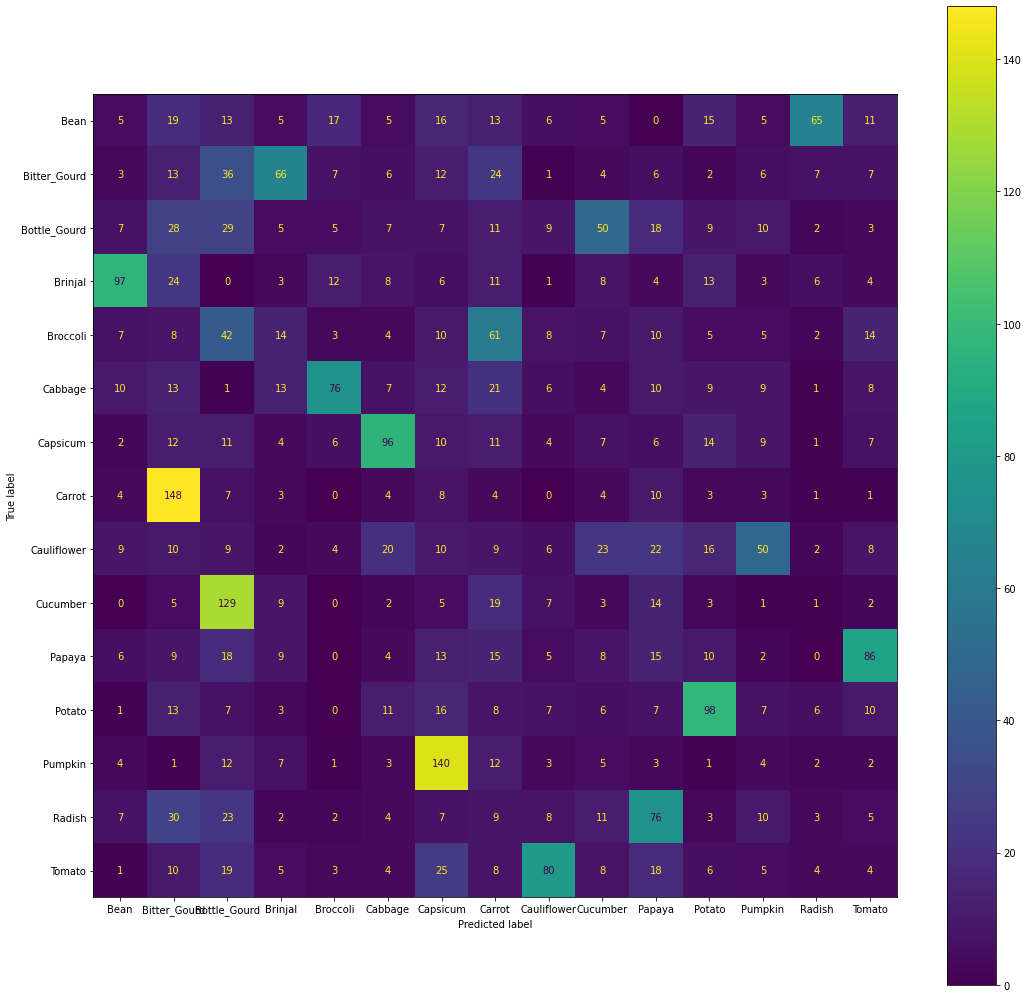

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


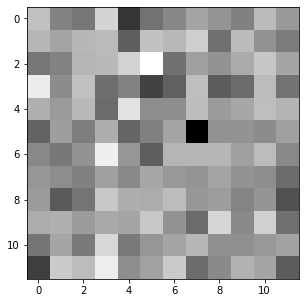

Bitter_Gourd


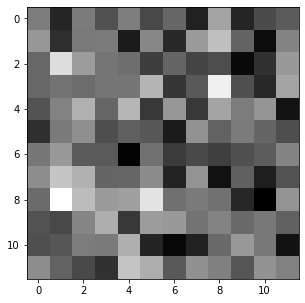

Bottle_Gourd


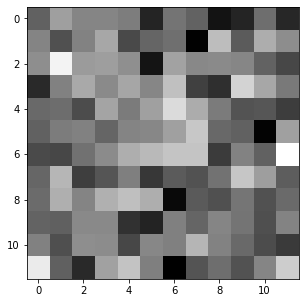

Brinjal


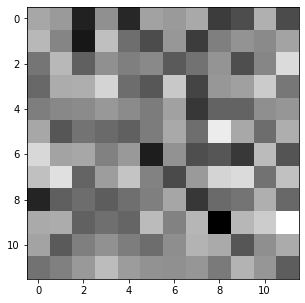

Broccoli


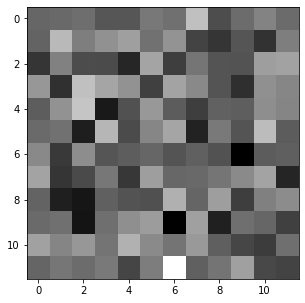

Cabbage


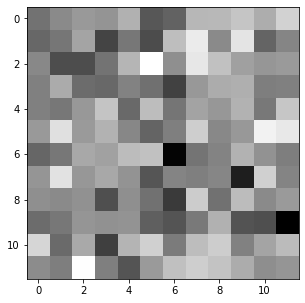

Capsicum


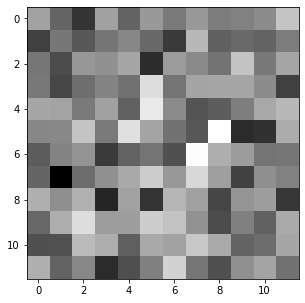

Carrot


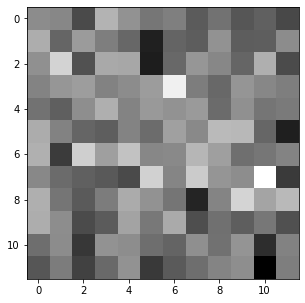

Cauliflower


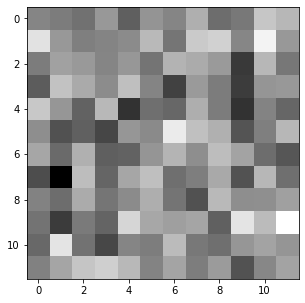

Cucumber


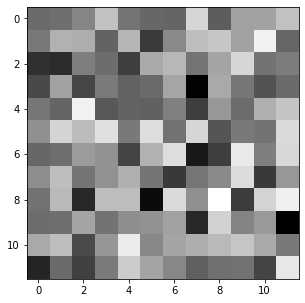

Papaya


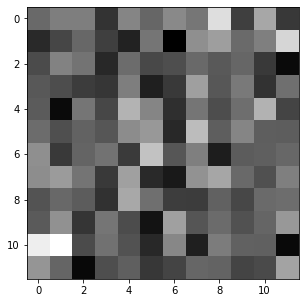

Potato


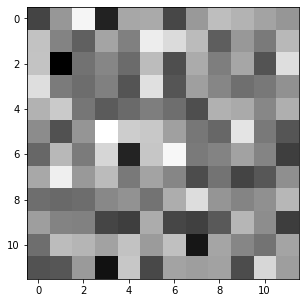

Pumpkin


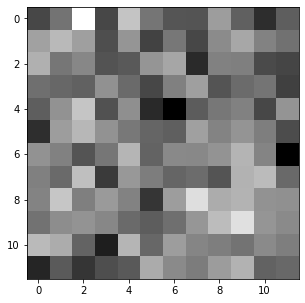

Radish


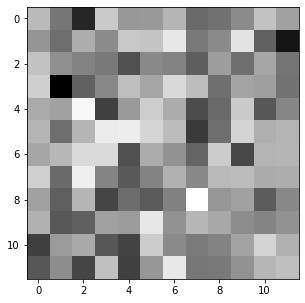

Tomato


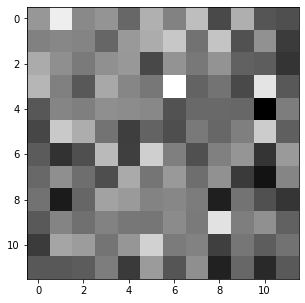

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =64, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6827423779098623, validation cost = 2.7150804299335545
Train Accuracy: 8.91550232867598 Validation Accuracy: 8.266666666666666
Epoch 2: training cost = 2.6696601305552705, validation cost = 2.718548677869319
Train Accuracy: 10.978043912175648 Validation Accuracy: 8.433333333333334
Epoch 3: training cost = 2.6565303082174365, validation cost = 2.721794921216258
Train Accuracy: 12.694610778443113 Validation Accuracy: 8.3
Epoch 4: training cost = 2.6460452179122913, validation cost = 2.724876213439523
Train Accuracy: 14.238190286094476 Validation Accuracy: 7.7
Epoch 5: training cost = 2.6361985108910764, validation cost = 2.7263058043661172
Train Accuracy: 14.896872920825016 Validation Accuracy: 7.233333333333333
Epoch 6: training cost = 2.629298928226282, validation cost = 2.726629361128635
Train Accuracy: 15.75515635395875 Validation Accuracy: 7.666666666666666
Epoch 7: training cost = 2.622625339432769, validation cost = 2.727463040382741
Train Accuracy: 16.5

              precision    recall  f1-score   support

           0      0.033     0.015     0.021       200
           1      0.024     0.035     0.029       200
           2      0.000     0.000     0.000       200
           3      0.027     0.025     0.026       200
           4      0.032     0.015     0.020       200
           5      0.057     0.085     0.068       200
           6      0.087     0.020     0.033       200
           7      0.021     0.025     0.023       200
           8      0.179     0.140     0.157       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.132     0.525     0.210       200
          12      0.038     0.025     0.030       200
          13      0.143     0.020     0.035       200
          14      0.047     0.140     0.070       200

    accuracy                          0.071      3000
   macro avg      0.055     0.071     0.048      3000
weighted avg      0.055   

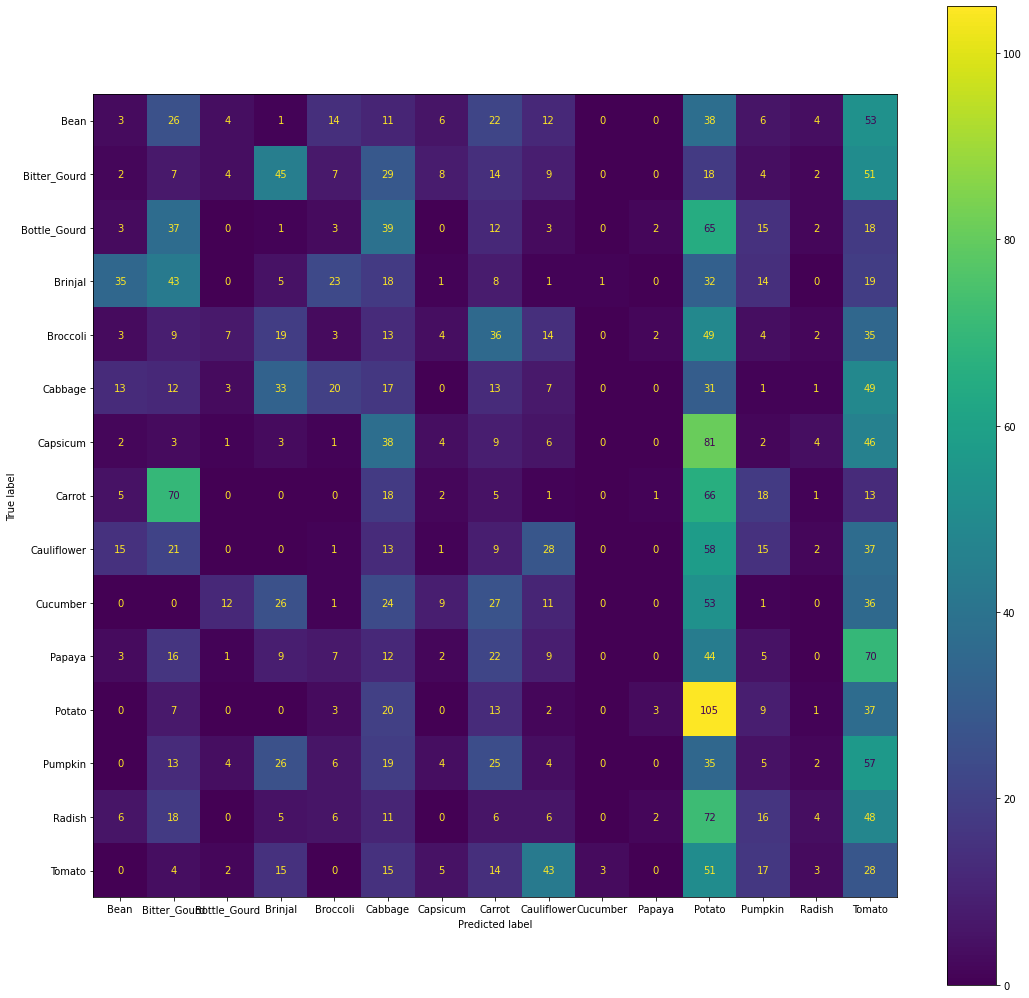

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


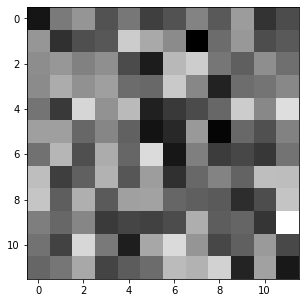

Bitter_Gourd


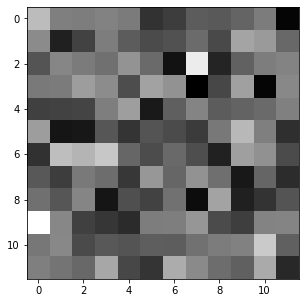

Bottle_Gourd


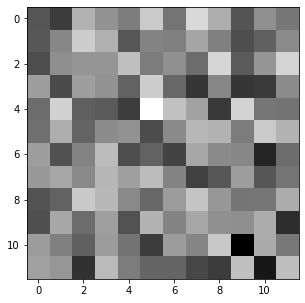

Brinjal


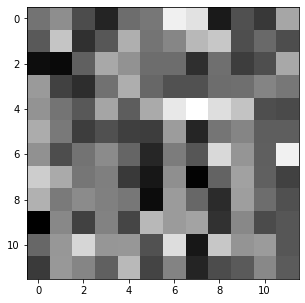

Broccoli


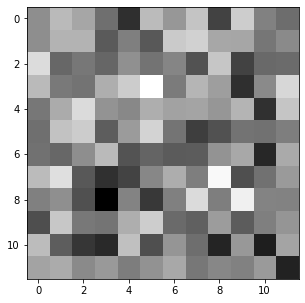

Cabbage


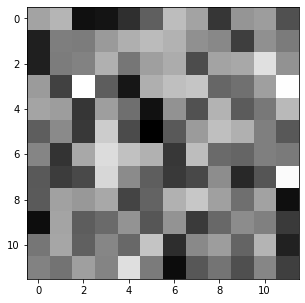

Capsicum


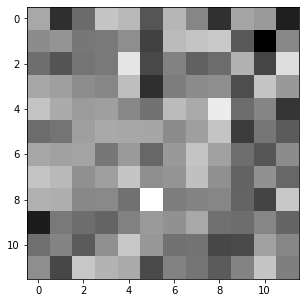

Carrot


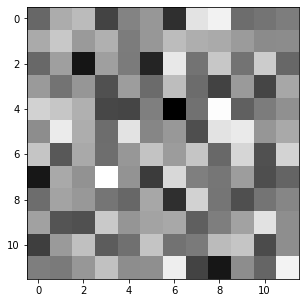

Cauliflower


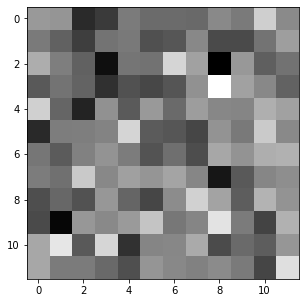

Cucumber


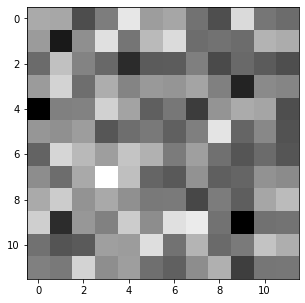

Papaya


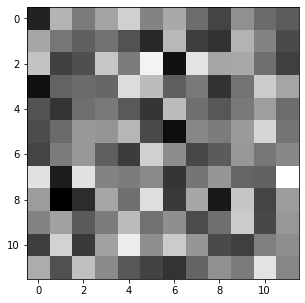

Potato


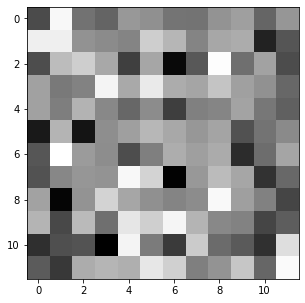

Pumpkin


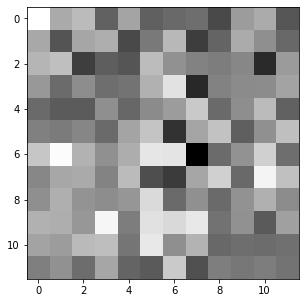

Radish


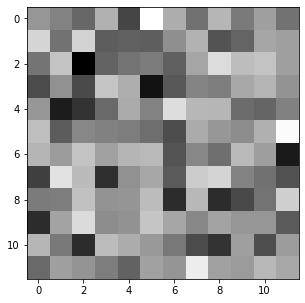

Tomato


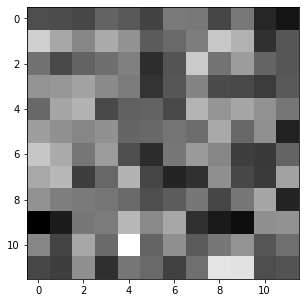

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =64, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

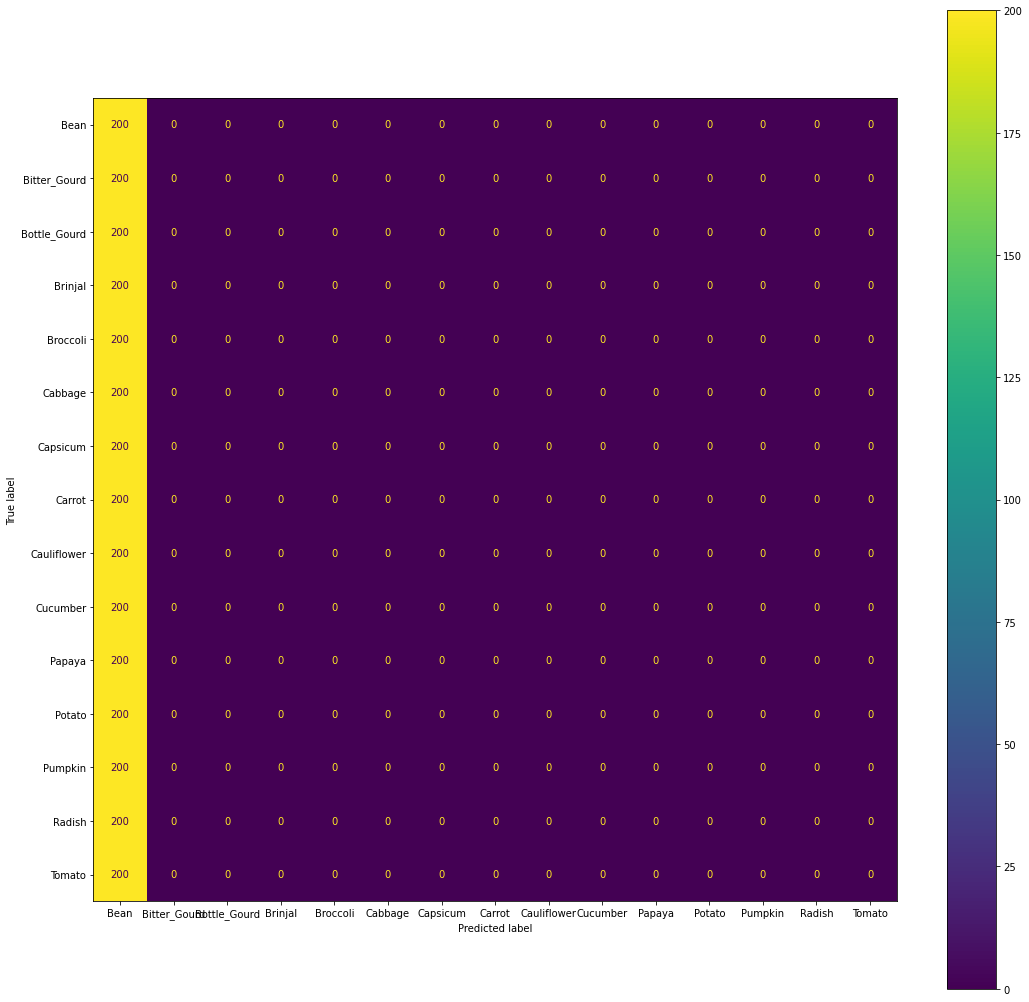

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


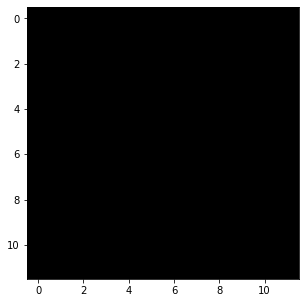

Bitter_Gourd


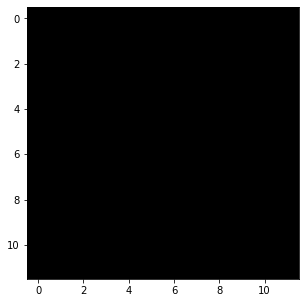

Bottle_Gourd


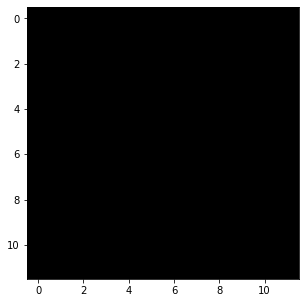

Brinjal


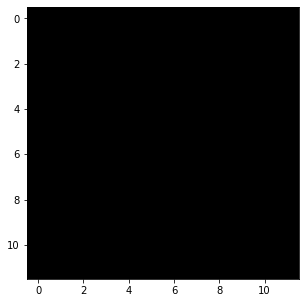

Broccoli


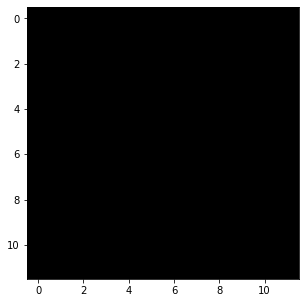

Cabbage


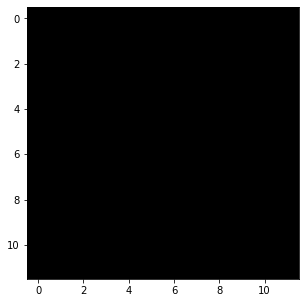

Capsicum


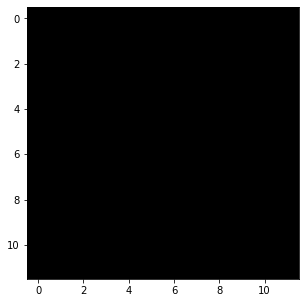

Carrot


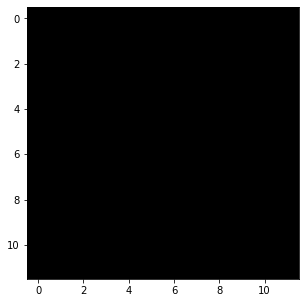

Cauliflower


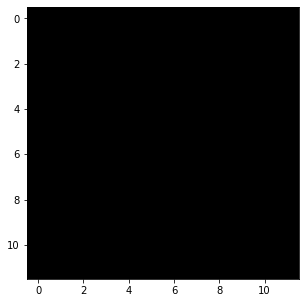

Cucumber


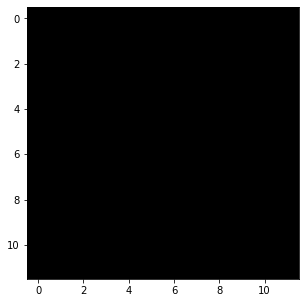

Papaya


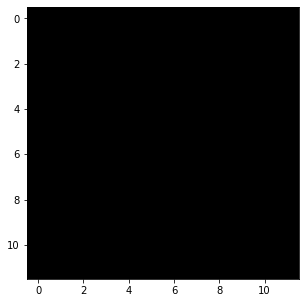

Potato


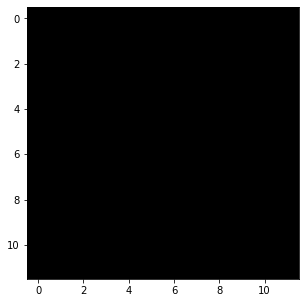

Pumpkin


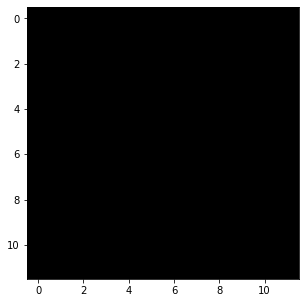

Radish


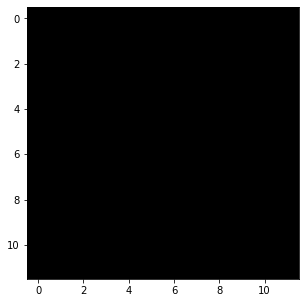

Tomato


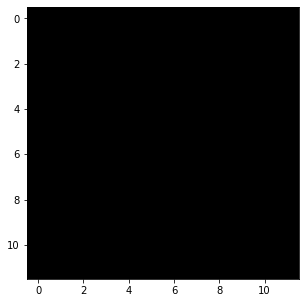

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =64, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.5201960866785322, validation cost = 2.842312357692499
Train Accuracy: 17.298735861610112 Validation Accuracy: 7.1
Epoch 2: training cost = 2.413593972958782, validation cost = 2.923429628643188
Train Accuracy: 22.827677977378578 Validation Accuracy: 6.9
Epoch 3: training cost = 2.339861332428896, validation cost = 3.0001729749526103
Train Accuracy: 26.34730538922156 Validation Accuracy: 6.7
Epoch 4: training cost = 2.2799201512822562, validation cost = 3.067968461187474
Train Accuracy: 28.66932801064538 Validation Accuracy: 6.9
Epoch 5: training cost = 2.228191011034994, validation cost = 3.128215035603386
Train Accuracy: 30.76513639387891 Validation Accuracy: 7.066666666666667
Epoch 6: training cost = 2.1820045340133984, validation cost = 3.1824831121421084
Train Accuracy: 32.50831669993347 Validation Accuracy: 7.3999999999999995
Epoch 7: training cost = 2.139638416704724, validation cost = 3.232529362369578
Train Accuracy: 33.81902860944777 Validation Accur

              precision    recall  f1-score   support

           0      0.041     0.050     0.045       200
           1      0.031     0.040     0.035       200
           2      0.059     0.065     0.062       200
           3      0.015     0.010     0.012       200
           4      0.041     0.035     0.038       200
           5      0.036     0.040     0.038       200
           6      0.036     0.035     0.036       200
           7      0.050     0.055     0.053       200
           8      0.019     0.015     0.017       200
           9      0.018     0.010     0.013       200
          10      0.071     0.110     0.086       200
          11      0.336     0.400     0.365       200
          12      0.028     0.025     0.026       200
          13      0.030     0.020     0.024       200
          14      0.067     0.070     0.068       200

    accuracy                          0.065      3000
   macro avg      0.059     0.065     0.061      3000
weighted avg      0.059   

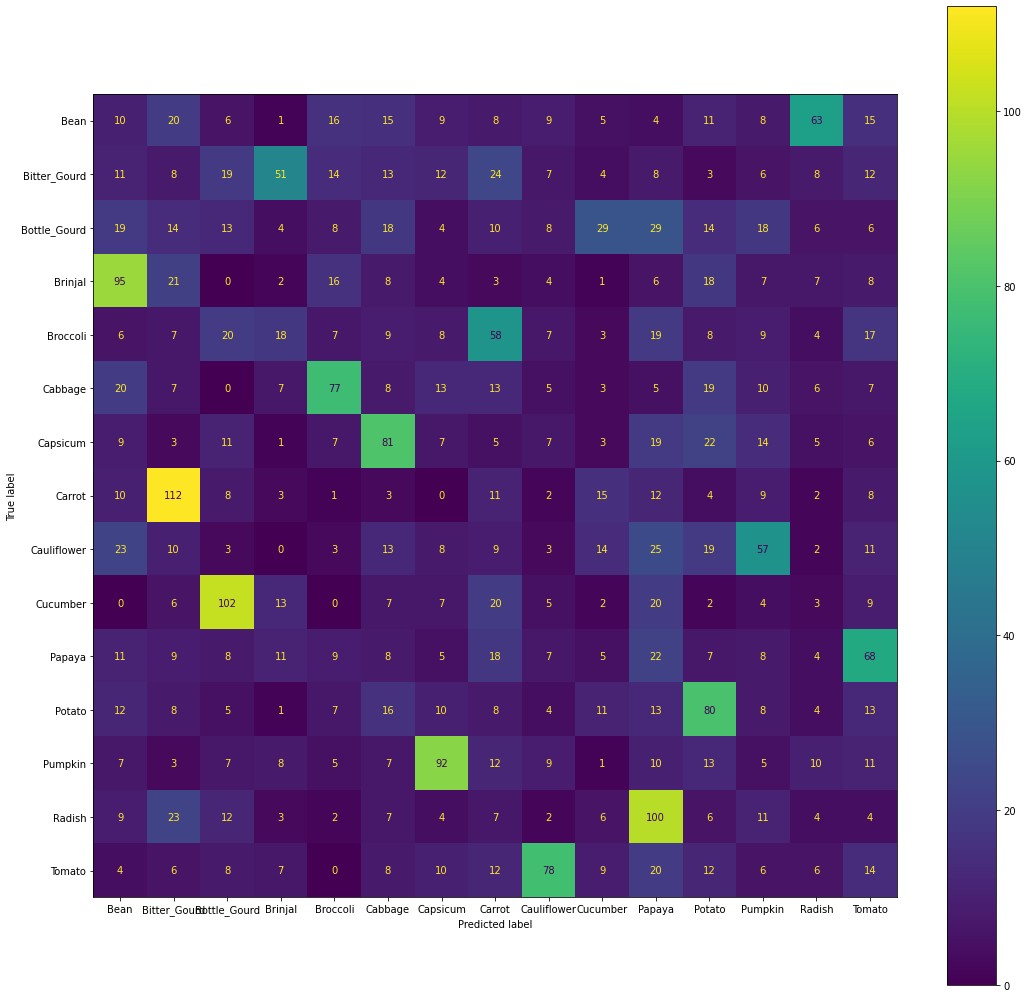

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


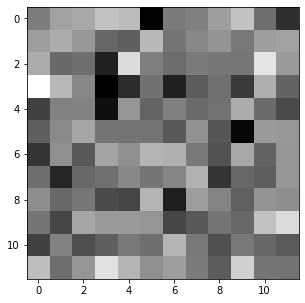

Bitter_Gourd


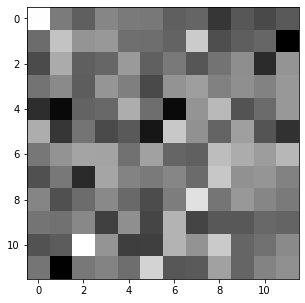

Bottle_Gourd


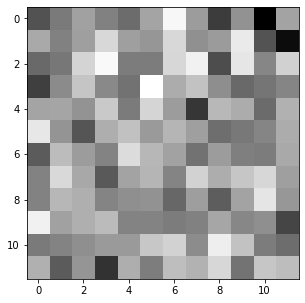

Brinjal


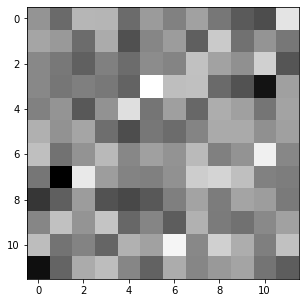

Broccoli


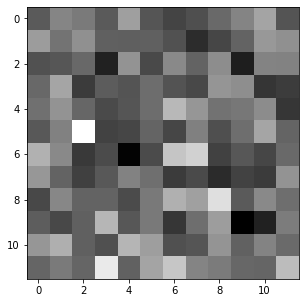

Cabbage


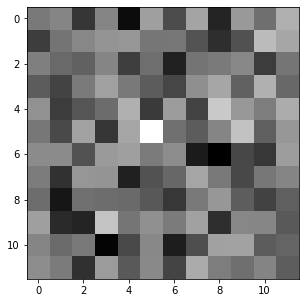

Capsicum


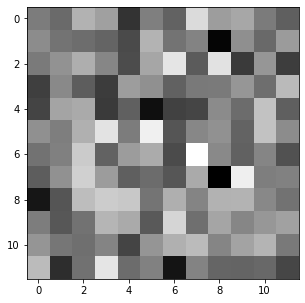

Carrot


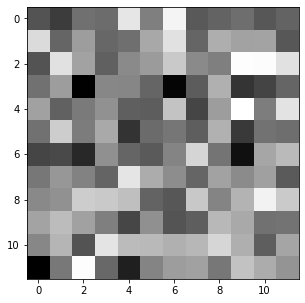

Cauliflower


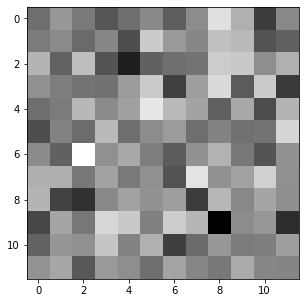

Cucumber


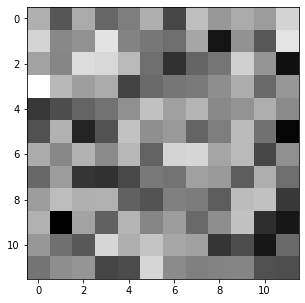

Papaya


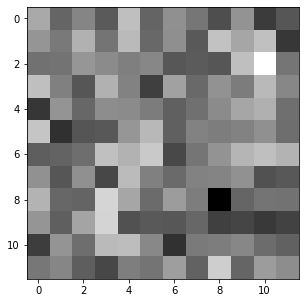

Potato


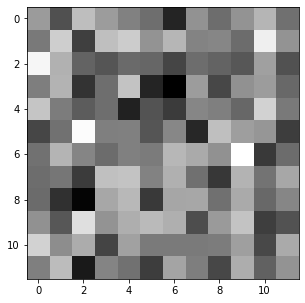

Pumpkin


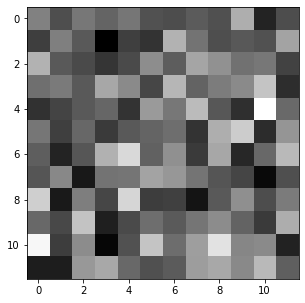

Radish


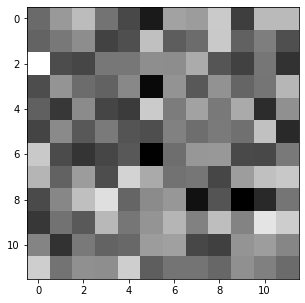

Tomato


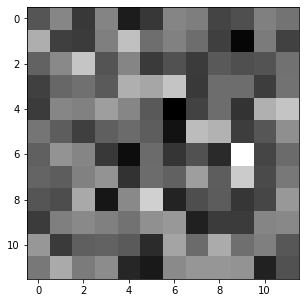

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =128, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.689632627950659, validation cost = 2.7137360562819617
Train Accuracy: 8.729208250166334 Validation Accuracy: 7.1
Epoch 2: training cost = 2.6769744088641056, validation cost = 2.713497779506182
Train Accuracy: 11.630073186959414 Validation Accuracy: 7.8
Epoch 3: training cost = 2.669825787912727, validation cost = 2.714093806491329
Train Accuracy: 13.679308050565536 Validation Accuracy: 7.633333333333334
Epoch 4: training cost = 2.663881152255487, validation cost = 2.714256481992129
Train Accuracy: 14.930139720558882 Validation Accuracy: 7.5
Epoch 5: training cost = 2.6570777566697337, validation cost = 2.71487567003952
Train Accuracy: 16.03459747172322 Validation Accuracy: 7.466666666666668
Epoch 6: training cost = 2.6493918557820835, validation cost = 2.7165374995875076
Train Accuracy: 17.252162341982704 Validation Accuracy: 7.433333333333334
Epoch 7: training cost = 2.6413481458923664, validation cost = 2.7183911400923217
Train Accuracy: 18.190286094477713

              precision    recall  f1-score   support

           0      0.034     0.020     0.025       200
           1      0.022     0.050     0.030       200
           2      0.043     0.020     0.027       200
           3      0.040     0.075     0.053       200
           4      0.074     0.110     0.089       200
           5      0.046     0.055     0.050       200
           6      0.063     0.055     0.059       200
           7      0.000     0.000     0.000       200
           8      0.105     0.045     0.063       200
           9      0.042     0.005     0.009       200
          10      0.053     0.015     0.023       200
          11      0.140     0.420     0.210       200
          12      0.047     0.035     0.040       200
          13      0.021     0.005     0.008       200
          14      0.043     0.055     0.048       200

    accuracy                          0.064      3000
   macro avg      0.052     0.064     0.049      3000
weighted avg      0.052   

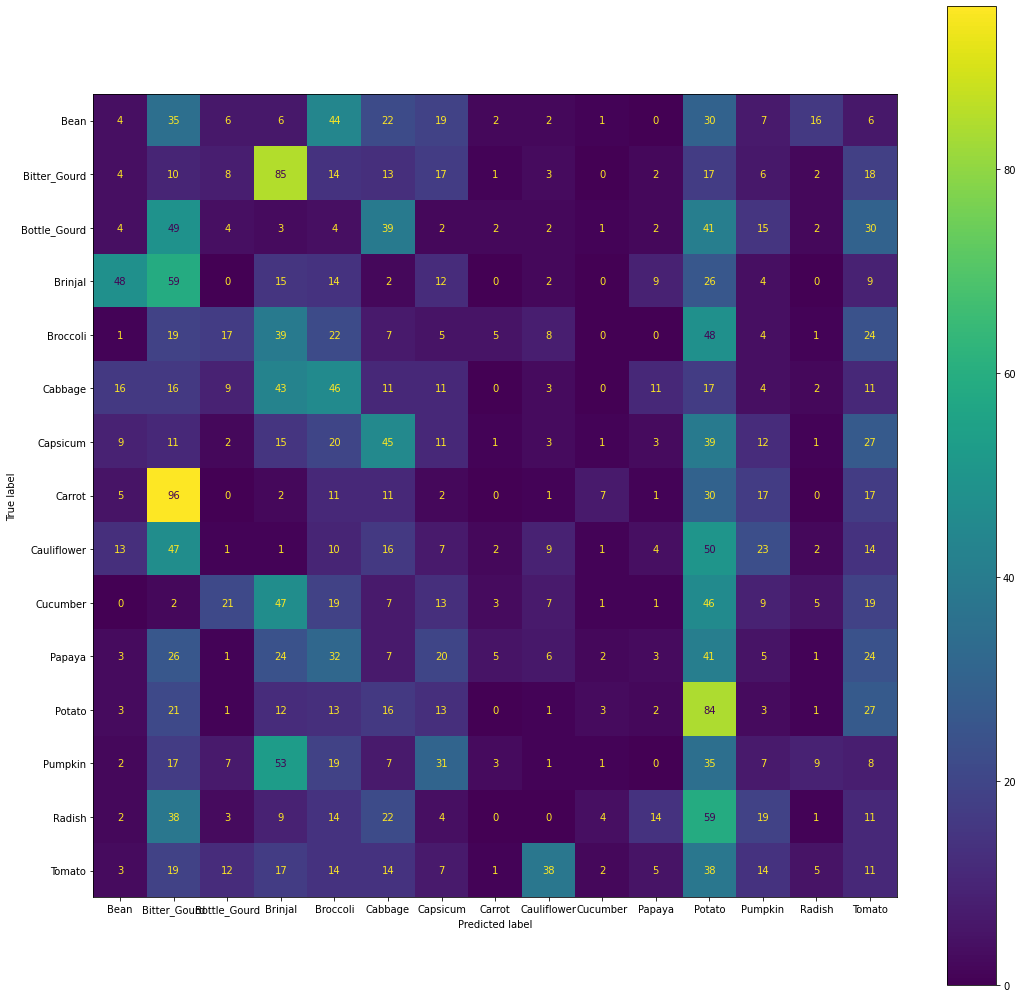

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


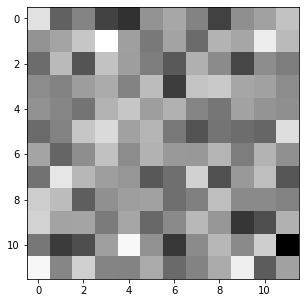

Bitter_Gourd


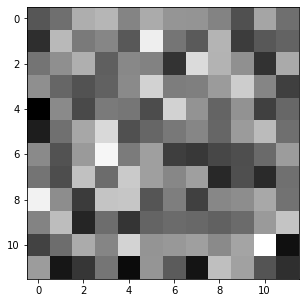

Bottle_Gourd


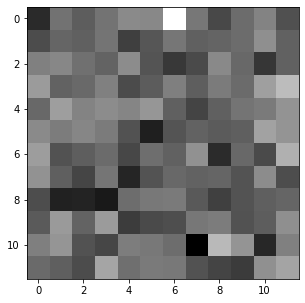

Brinjal


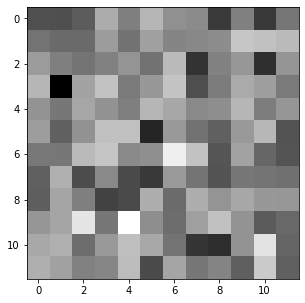

Broccoli


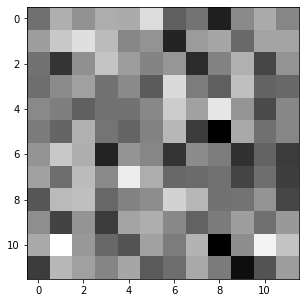

Cabbage


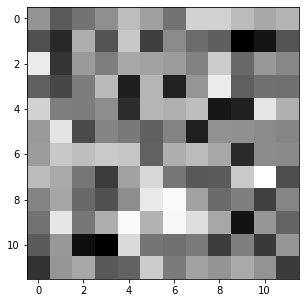

Capsicum


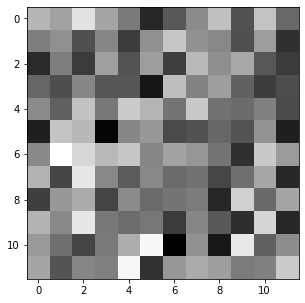

Carrot


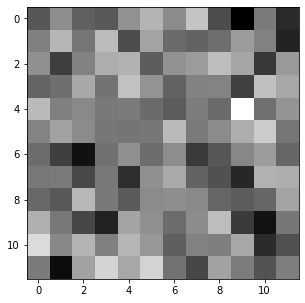

Cauliflower


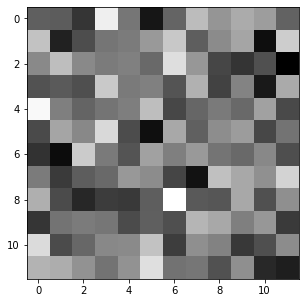

Cucumber


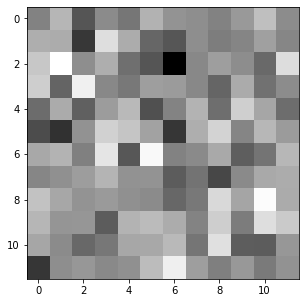

Papaya


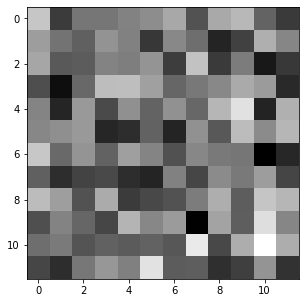

Potato


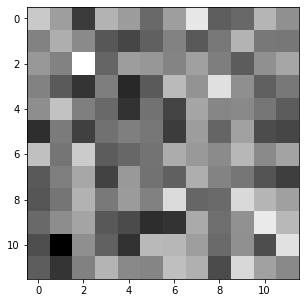

Pumpkin


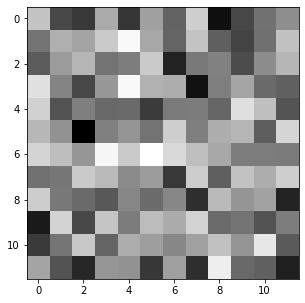

Radish


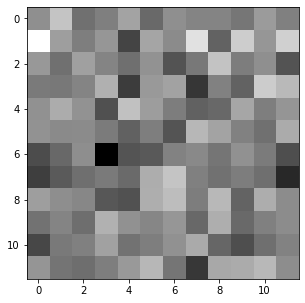

Tomato


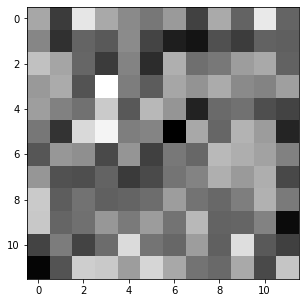

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =128, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.585175136098768, validation cost = 3.100886982970136
Train Accuracy: 14.491017964071856 Validation Accuracy: 4.9
Epoch 2: training cost = 2.5548840451164345, validation cost = 3.2420406539166797
Train Accuracy: 16.726546906187625 Validation Accuracy: 5.533333333333333
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

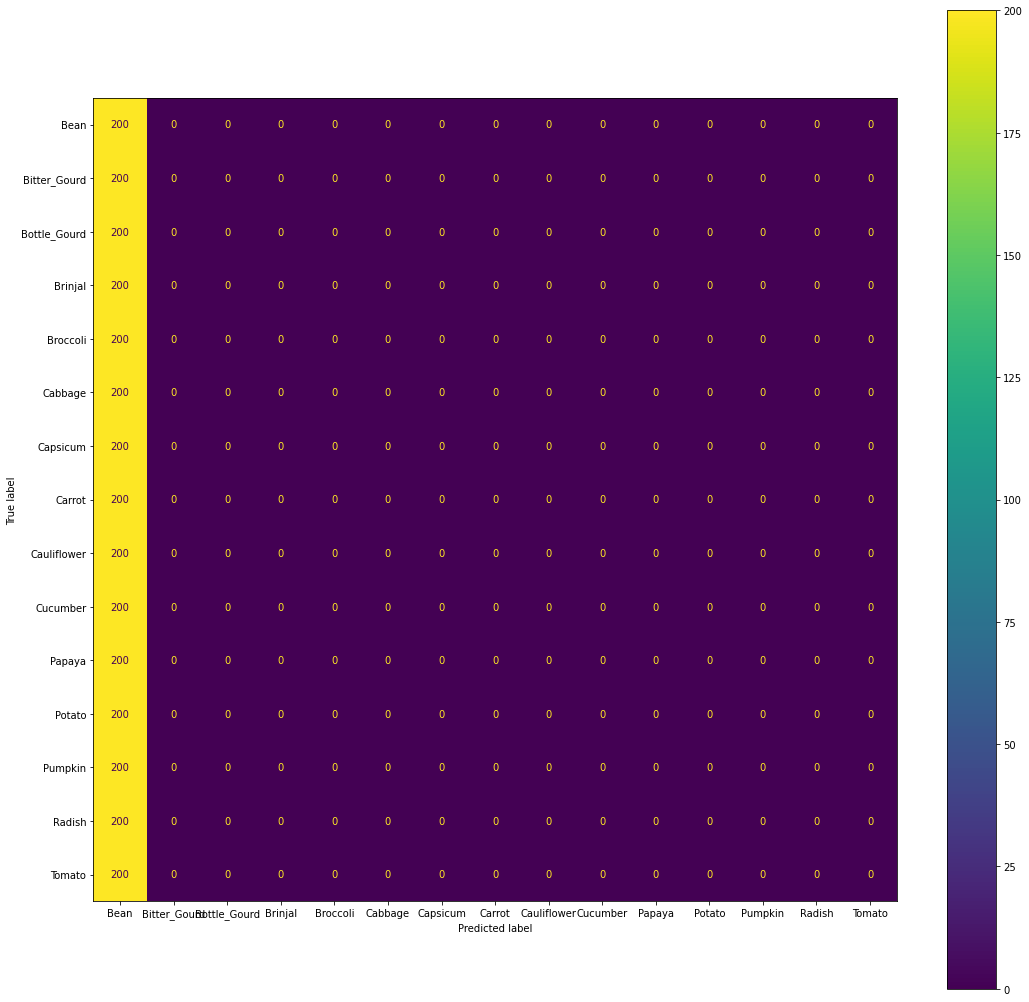

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


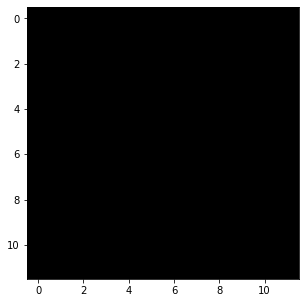

Bitter_Gourd


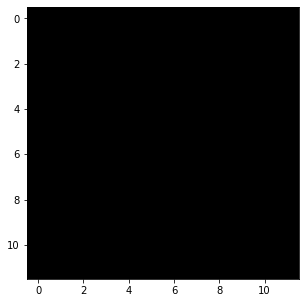

Bottle_Gourd


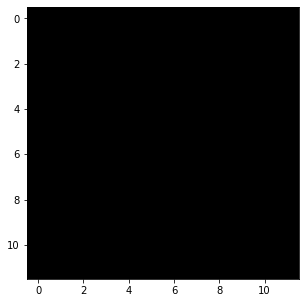

Brinjal


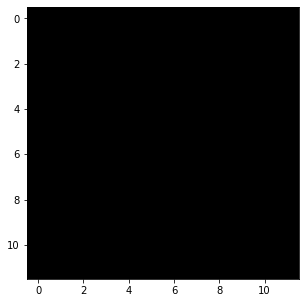

Broccoli


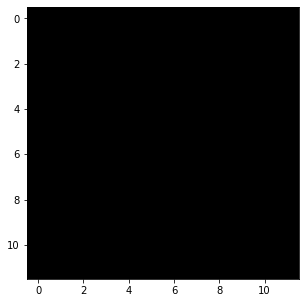

Cabbage


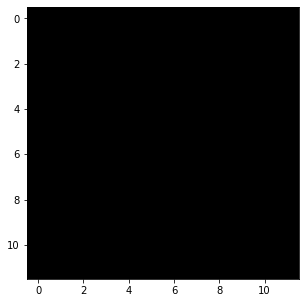

Capsicum


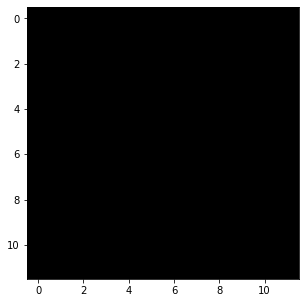

Carrot


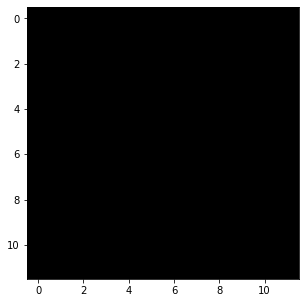

Cauliflower


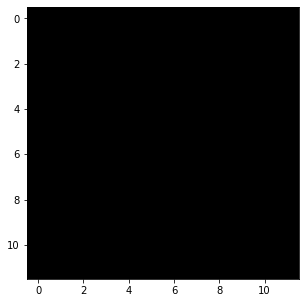

Cucumber


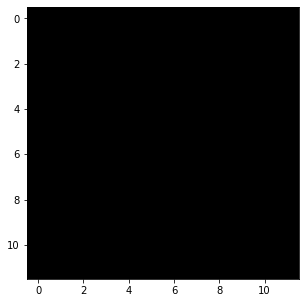

Papaya


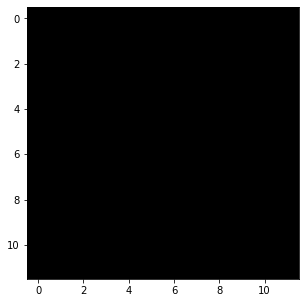

Potato


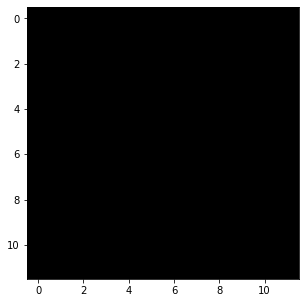

Pumpkin


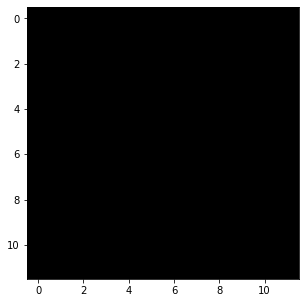

Radish


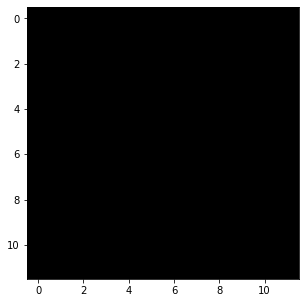

Tomato


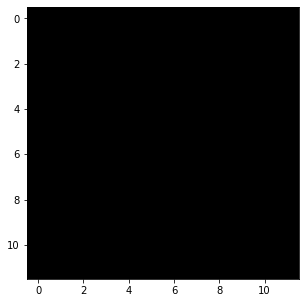

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.01, batch_size =128, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6139099718583827, validation cost = 2.8214909492150047
Train Accuracy: 13.419827012641383 Validation Accuracy: 7.566666666666666
Epoch 2: training cost = 2.5221907459616295, validation cost = 2.846595518875194
Train Accuracy: 17.81104457751164 Validation Accuracy: 7.966666666666667
Epoch 3: training cost = 2.460524249128733, validation cost = 2.8820044175574946
Train Accuracy: 21.124417831004656 Validation Accuracy: 8.133333333333333
Epoch 4: training cost = 2.4140065286383314, validation cost = 2.9195365688513197
Train Accuracy: 23.699268130405855 Validation Accuracy: 8.1
Epoch 5: training cost = 2.3747775222677885, validation cost = 2.9571851240804885
Train Accuracy: 25.45575515635396 Validation Accuracy: 8.166666666666666
Epoch 6: training cost = 2.3403542039455156, validation cost = 2.993354316952426
Train Accuracy: 26.88622754491018 Validation Accuracy: 8.066666666666666
Epoch 7: training cost = 2.309524936421561, validation cost = 3.0264999362847282
Tra

              precision    recall  f1-score   support

           0      0.026     0.030     0.028       200
           1      0.024     0.035     0.029       200
           2      0.117     0.130     0.123       200
           3      0.023     0.020     0.022       200
           4      0.027     0.030     0.028       200
           5      0.044     0.040     0.042       200
           6      0.044     0.040     0.042       200
           7      0.030     0.035     0.032       200
           8      0.094     0.080     0.086       200
           9      0.026     0.015     0.019       200
          10      0.073     0.095     0.082       200
          11      0.278     0.345     0.308       200
          12      0.049     0.035     0.041       200
          13      0.032     0.020     0.025       200
          14      0.059     0.060     0.060       200

    accuracy                          0.067      3000
   macro avg      0.063     0.067     0.064      3000
weighted avg      0.063   

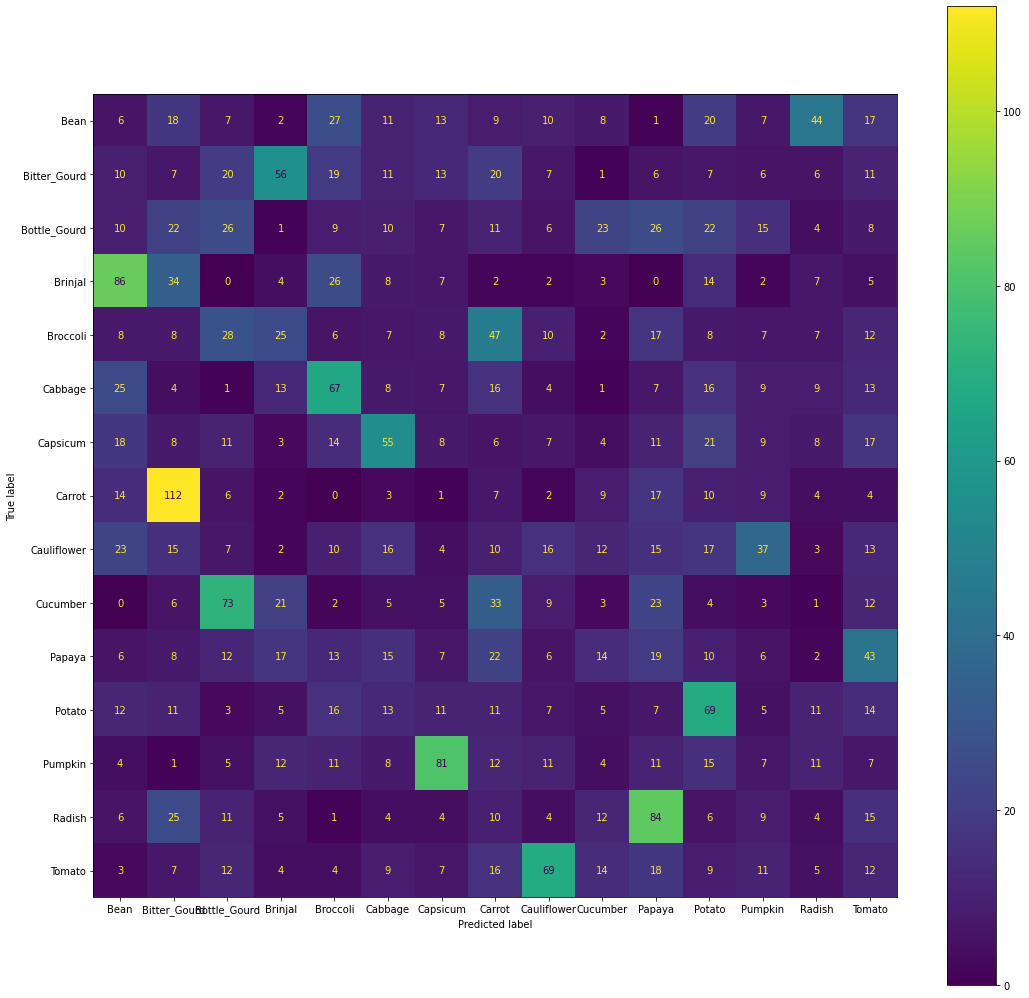

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


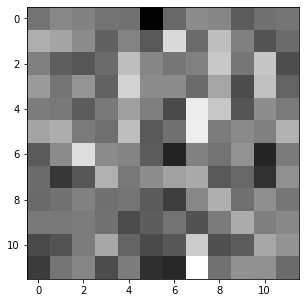

Bitter_Gourd


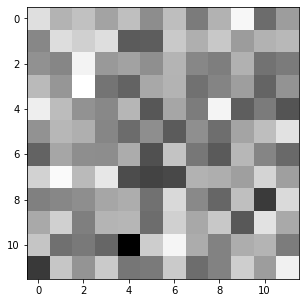

Bottle_Gourd


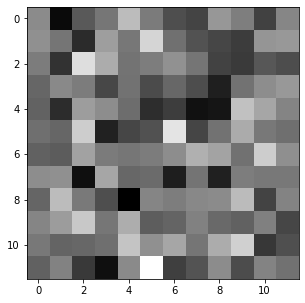

Brinjal


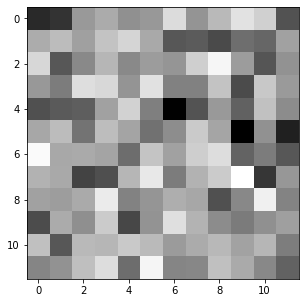

Broccoli


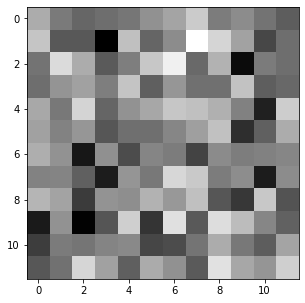

Cabbage


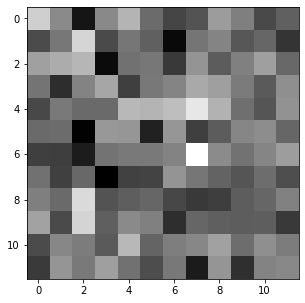

Capsicum


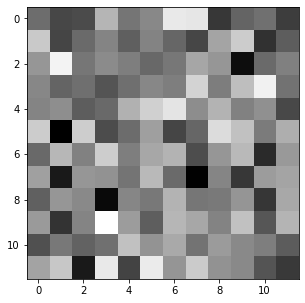

Carrot


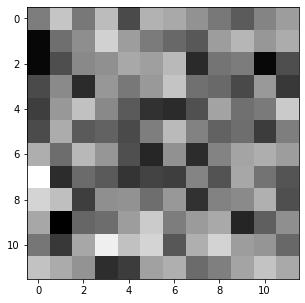

Cauliflower


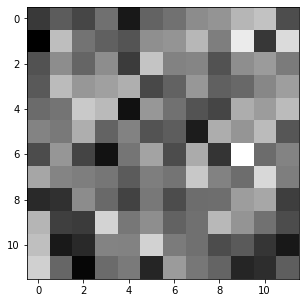

Cucumber


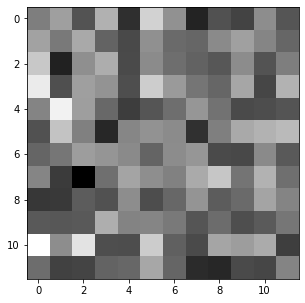

Papaya


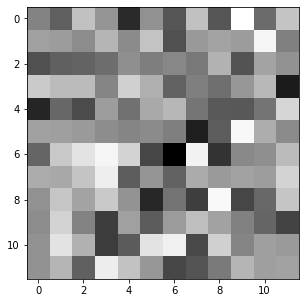

Potato


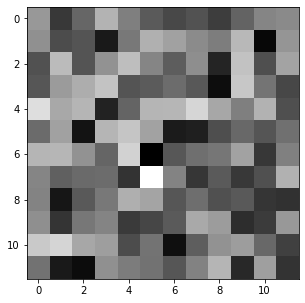

Pumpkin


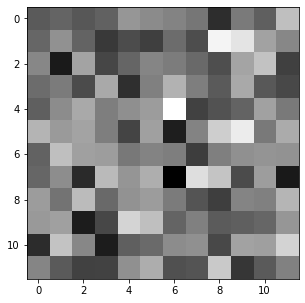

Radish


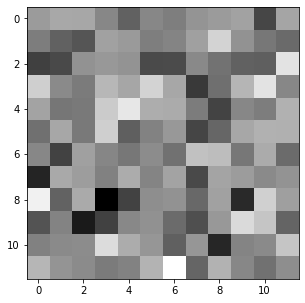

Tomato


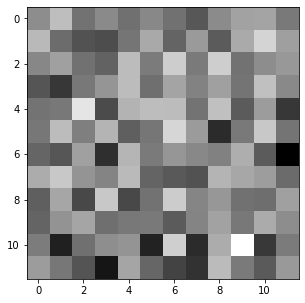

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =16, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6075209836392355, validation cost = 2.7561865661839886
Train Accuracy: 14.737192282102463 Validation Accuracy: 7.566666666666666
Epoch 2: training cost = 2.551664734512714, validation cost = 2.830798214970639
Train Accuracy: 17.890884896872922 Validation Accuracy: 6.5
Epoch 3: training cost = 2.5078806326960295, validation cost = 2.9014962555611286
Train Accuracy: 19.660678642714572 Validation Accuracy: 6.233333333333333
Epoch 4: training cost = 2.4808266418624765, validation cost = 2.955683291788265
Train Accuracy: 18.86892880904857 Validation Accuracy: 6.533333333333332
Epoch 5: training cost = 2.485893945001293, validation cost = 2.9716257186262203
Train Accuracy: 17.7977378576181 Validation Accuracy: 6.0
Epoch 6: training cost = 2.4927206171607494, validation cost = 2.9841510137297
Train Accuracy: 18.08383233532934 Validation Accuracy: 5.566666666666667
Epoch 7: training cost = 2.498843313471683, validation cost = 2.9897645444467984
Train Accuracy: 18.130

              precision    recall  f1-score   support

           0      0.039     0.020     0.026       200
           1      0.041     0.055     0.047       200
           2      0.000     0.000     0.000       200
           3      0.125     0.060     0.081       200
           4      0.039     0.055     0.046       200
           5      0.048     0.160     0.073       200
           6      0.037     0.040     0.038       200
           7      0.017     0.010     0.013       200
           8      0.138     0.165     0.150       200
           9      0.032     0.010     0.015       200
          10      0.046     0.025     0.032       200
          11      0.150     0.495     0.230       200
          12      0.000     0.000     0.000       200
          13      0.186     0.065     0.096       200
          14      0.083     0.005     0.009       200

    accuracy                          0.078      3000
   macro avg      0.065     0.078     0.057      3000
weighted avg      0.065   

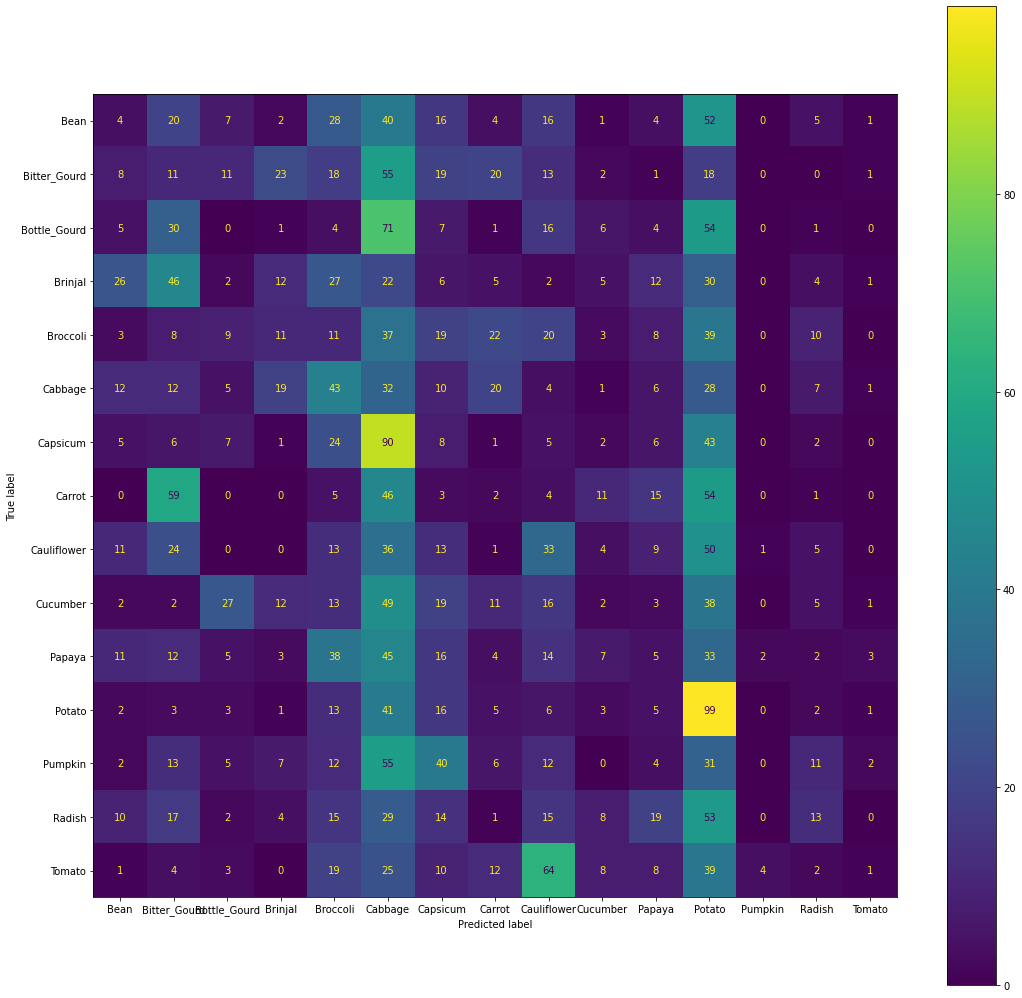

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


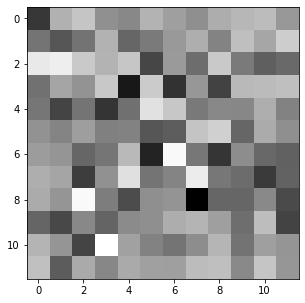

Bitter_Gourd


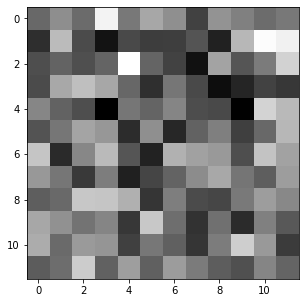

Bottle_Gourd


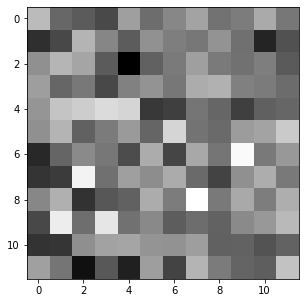

Brinjal


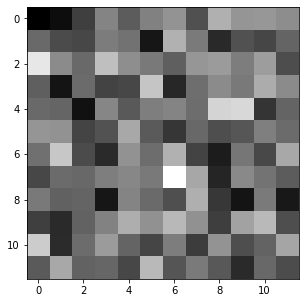

Broccoli


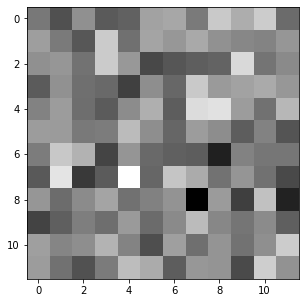

Cabbage


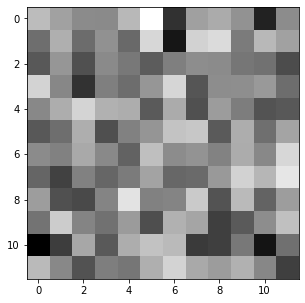

Capsicum


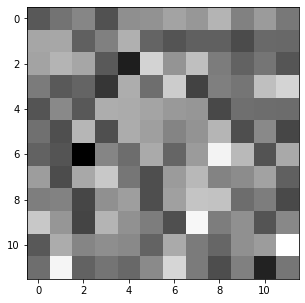

Carrot


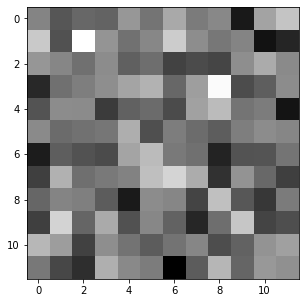

Cauliflower


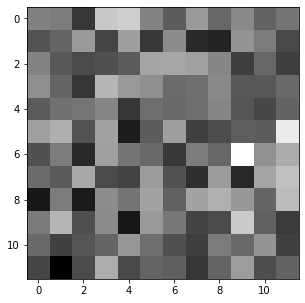

Cucumber


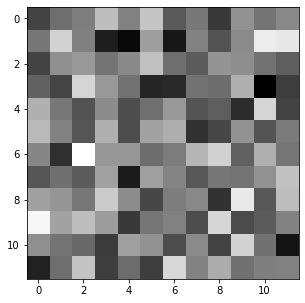

Papaya


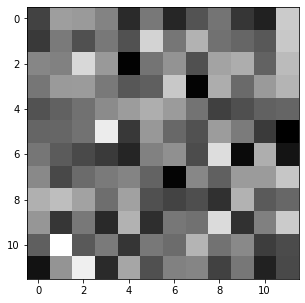

Potato


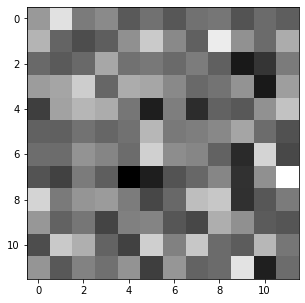

Pumpkin


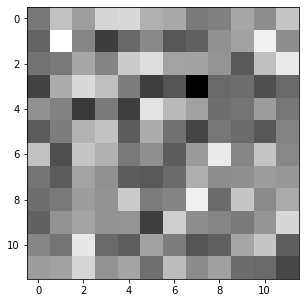

Radish


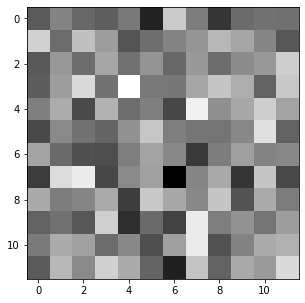

Tomato


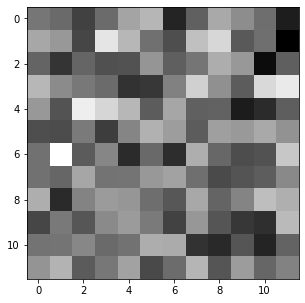

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =16, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

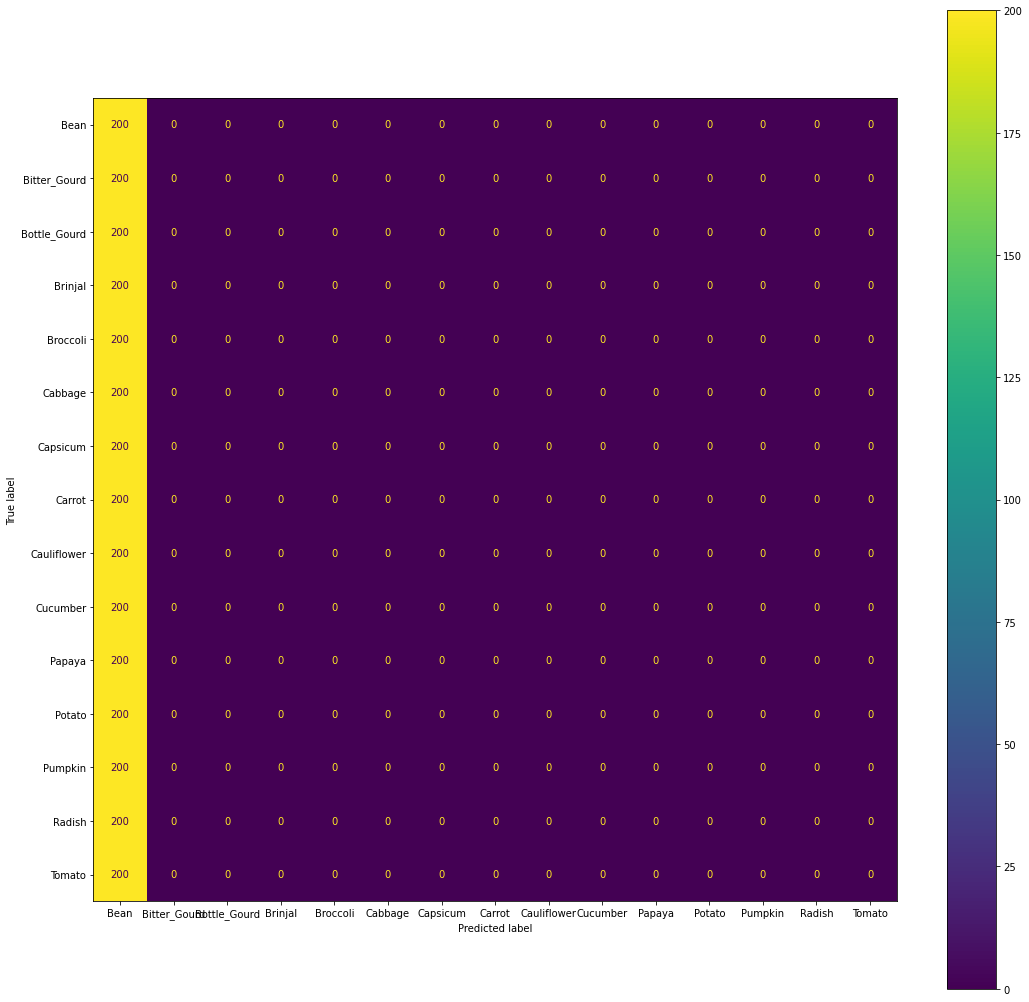

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


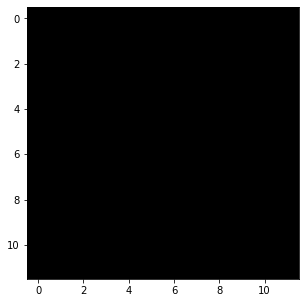

Bitter_Gourd


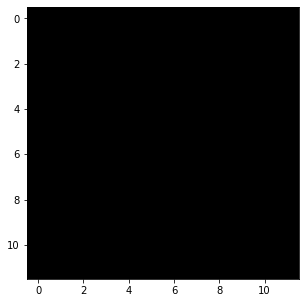

Bottle_Gourd


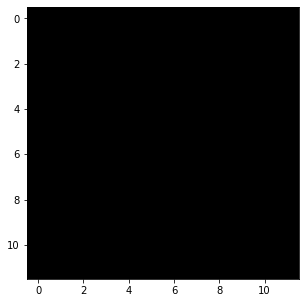

Brinjal


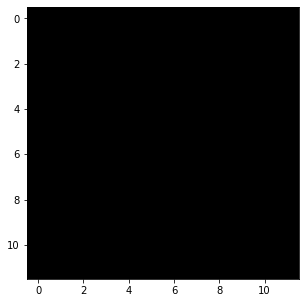

Broccoli


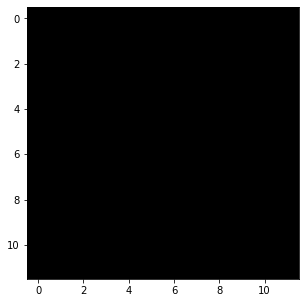

Cabbage


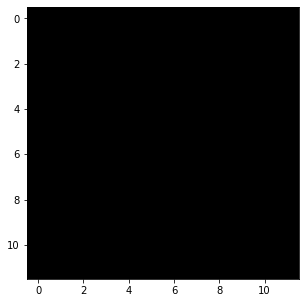

Capsicum


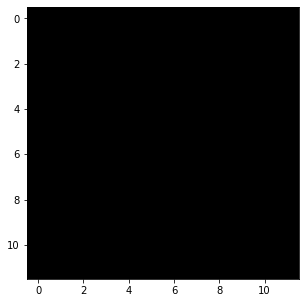

Carrot


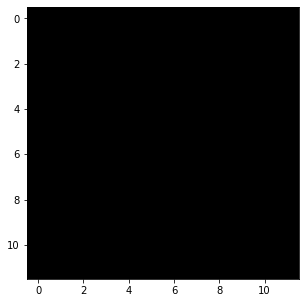

Cauliflower


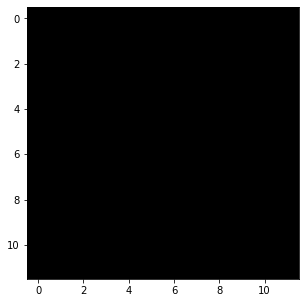

Cucumber


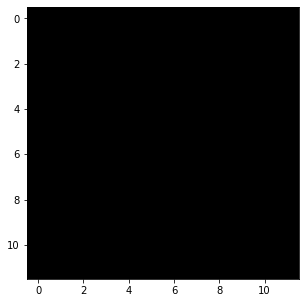

Papaya


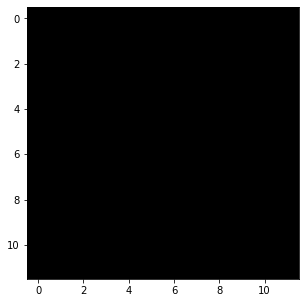

Potato


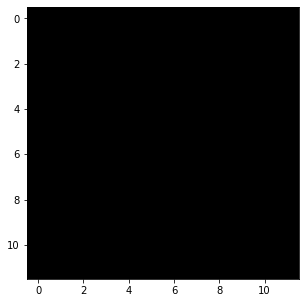

Pumpkin


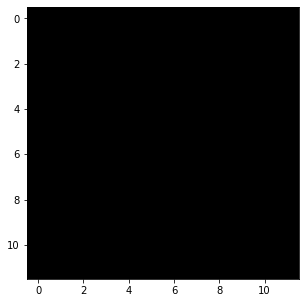

Radish


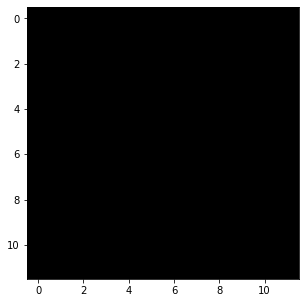

Tomato


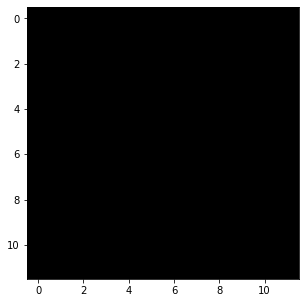

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =16, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.285247576683252, validation cost = 3.254053797477867
Train Accuracy: 25.023286759813708 Validation Accuracy: 6.5
Epoch 2: training cost = 2.098102557921291, validation cost = 3.5295682161555266
Train Accuracy: 32.18230206254159 Validation Accuracy: 7.333333333333333
Epoch 3: training cost = 1.9378846241281709, validation cost = 3.7446081298415397
Train Accuracy: 37.78443113772455 Validation Accuracy: 7.5
Epoch 4: training cost = 1.8000909071414883, validation cost = 3.9584564675940843
Train Accuracy: 42.481703260146375 Validation Accuracy: 7.566666666666666
Epoch 5: training cost = 1.6717559421679573, validation cost = 4.179292246036039
Train Accuracy: 46.73985362608117 Validation Accuracy: 7.533333333333333
Epoch 6: training cost = 1.551394524779901, validation cost = 4.388920441571997
Train Accuracy: 50.56553559547572 Validation Accuracy: 7.166666666666667
Epoch 7: training cost = 1.4319667444843756, validation cost = 4.583083137202071
Train Accuracy: 54.62

              precision    recall  f1-score   support

           0      0.049     0.035     0.041       200
           1      0.015     0.015     0.015       200
           2      0.044     0.050     0.047       200
           3      0.030     0.040     0.034       200
           4      0.053     0.055     0.054       200
           5      0.033     0.050     0.040       200
           6      0.006     0.005     0.005       200
           7      0.022     0.015     0.018       200
           8      0.032     0.035     0.033       200
           9      0.030     0.045     0.036       200
          10      0.054     0.025     0.034       200
          11      0.358     0.680     0.469       200
          12      0.037     0.015     0.021       200
          13      0.024     0.020     0.022       200
          14      0.000     0.000     0.000       200

    accuracy                          0.072      3000
   macro avg      0.052     0.072     0.058      3000
weighted avg      0.052   

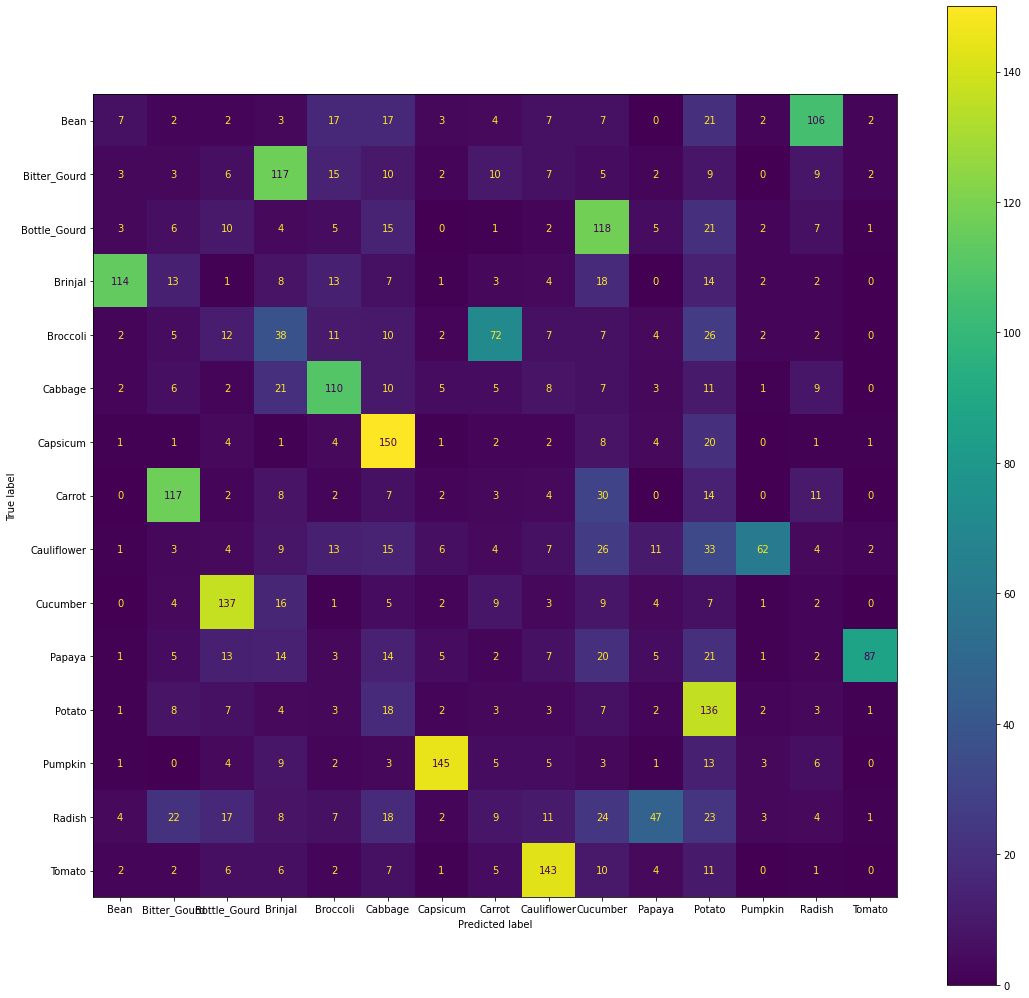

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


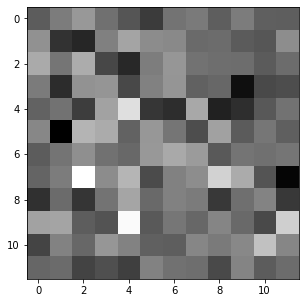

Bitter_Gourd


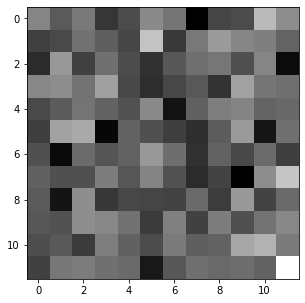

Bottle_Gourd


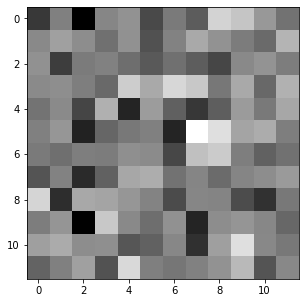

Brinjal


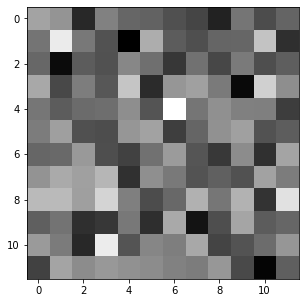

Broccoli


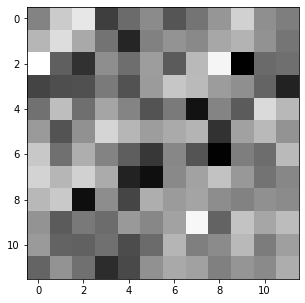

Cabbage


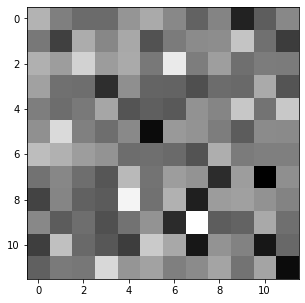

Capsicum


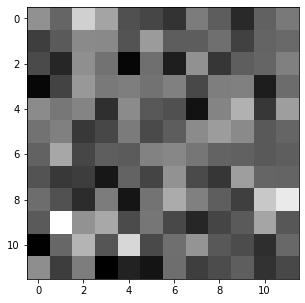

Carrot


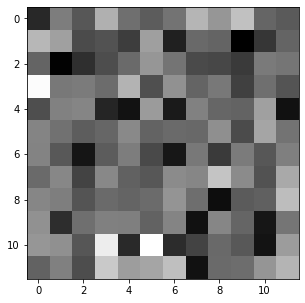

Cauliflower


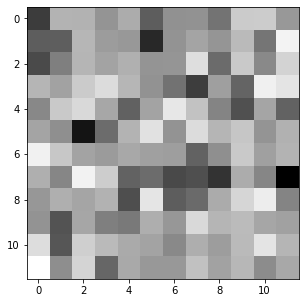

Cucumber


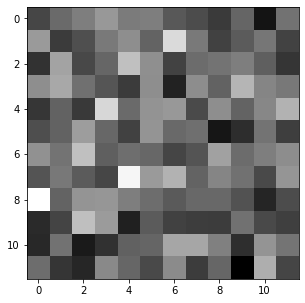

Papaya


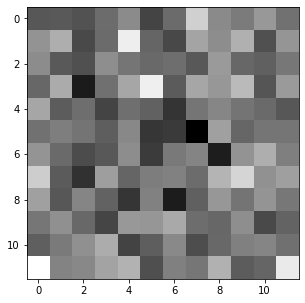

Potato


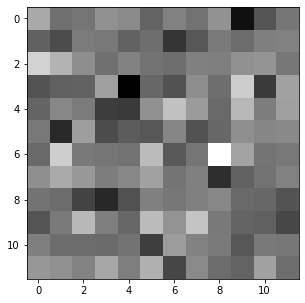

Pumpkin


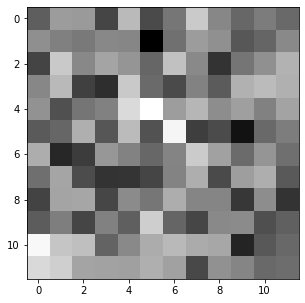

Radish


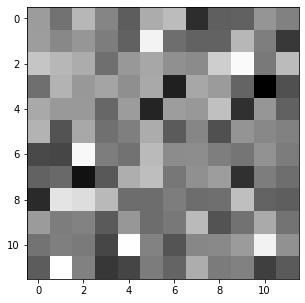

Tomato


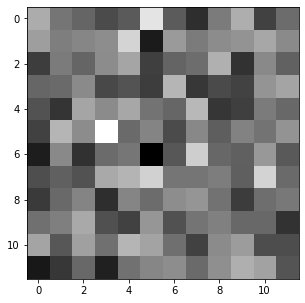

In [ ]:
model.visualize_weights(12)

In [ ]:
model.save_mode()

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =32, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6442150583496917, validation cost = 2.73500278954326
Train Accuracy: 12.029274783765802 Validation Accuracy: 7.833333333333334
Epoch 2: training cost = 2.6098444387868796, validation cost = 2.7532706402620217
Train Accuracy: 13.04723885562209 Validation Accuracy: 7.2666666666666675
Epoch 3: training cost = 2.5865516477789363, validation cost = 2.776350225510411
Train Accuracy: 15.302727877578176 Validation Accuracy: 6.766666666666667
Epoch 4: training cost = 2.5763199838153055, validation cost = 2.7880721235969927
Train Accuracy: 16.640053226879576 Validation Accuracy: 6.133333333333333
Epoch 5: training cost = 2.5712807021163853, validation cost = 2.7954250331061665
Train Accuracy: 16.487025948103792 Validation Accuracy: 7.033333333333333
Epoch 6: training cost = 2.5694689319272612, validation cost = 2.7991089979301966
Train Accuracy: 15.961410512308715 Validation Accuracy: 7.133333333333333
Epoch 7: training cost = 2.565558965479357, validation cost = 2.809

              precision    recall  f1-score   support

           0      0.059     0.010     0.017       200
           1      0.026     0.030     0.028       200
           2      0.000     0.000     0.000       200
           3      0.022     0.005     0.008       200
           4      0.000     0.000     0.000       200
           5      0.065     0.675     0.119       200
           6      0.000     0.000     0.000       200
           7      0.048     0.085     0.061       200
           8      0.134     0.115     0.124       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.061      3000
   macro avg      0.024     0.061     0.024      3000
weighted avg      0.024   

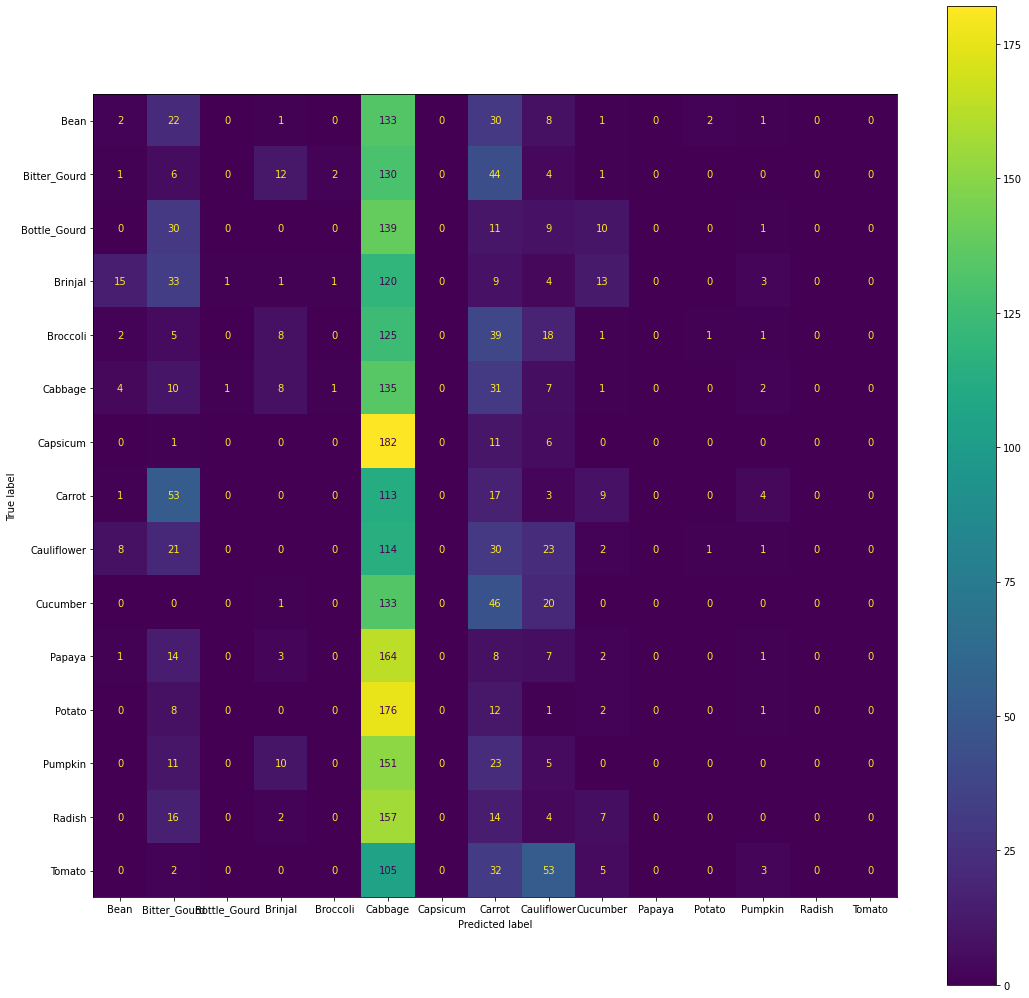

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


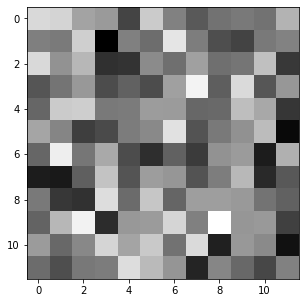

Bitter_Gourd


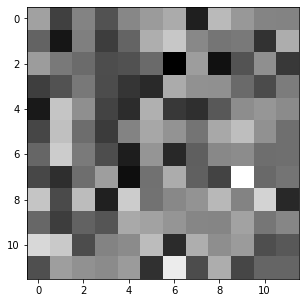

Bottle_Gourd


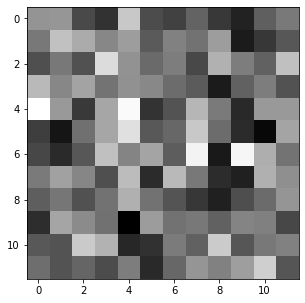

Brinjal


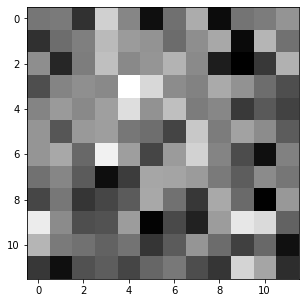

Broccoli


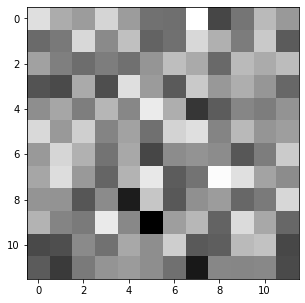

Cabbage


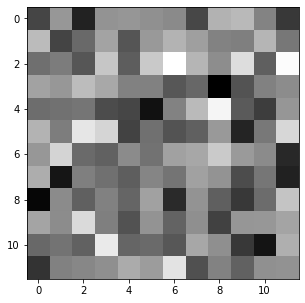

Capsicum


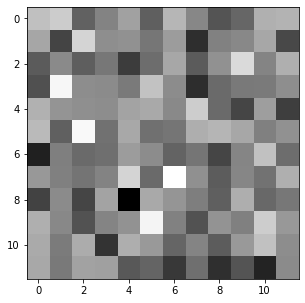

Carrot


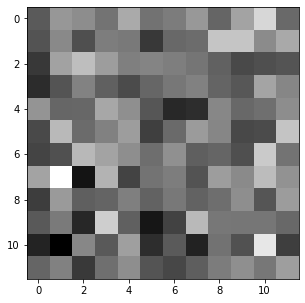

Cauliflower


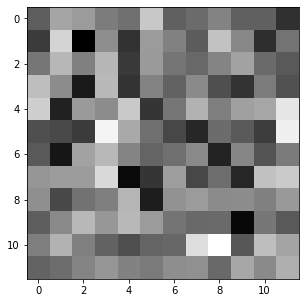

Cucumber


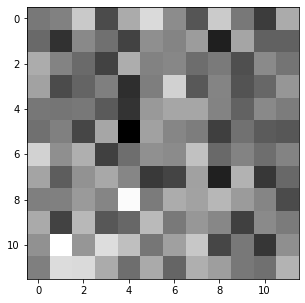

Papaya


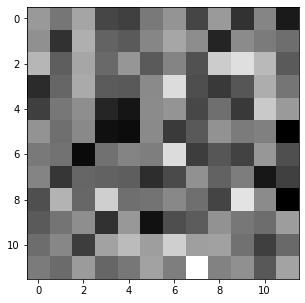

Potato


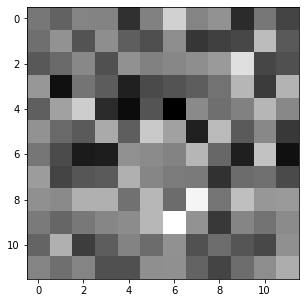

Pumpkin


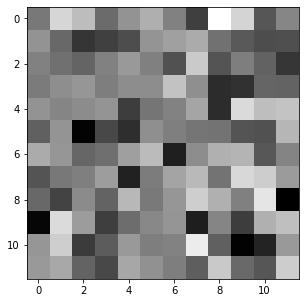

Radish


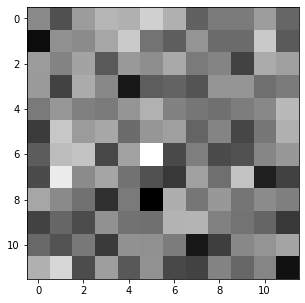

Tomato


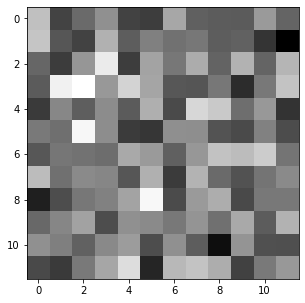

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =32, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

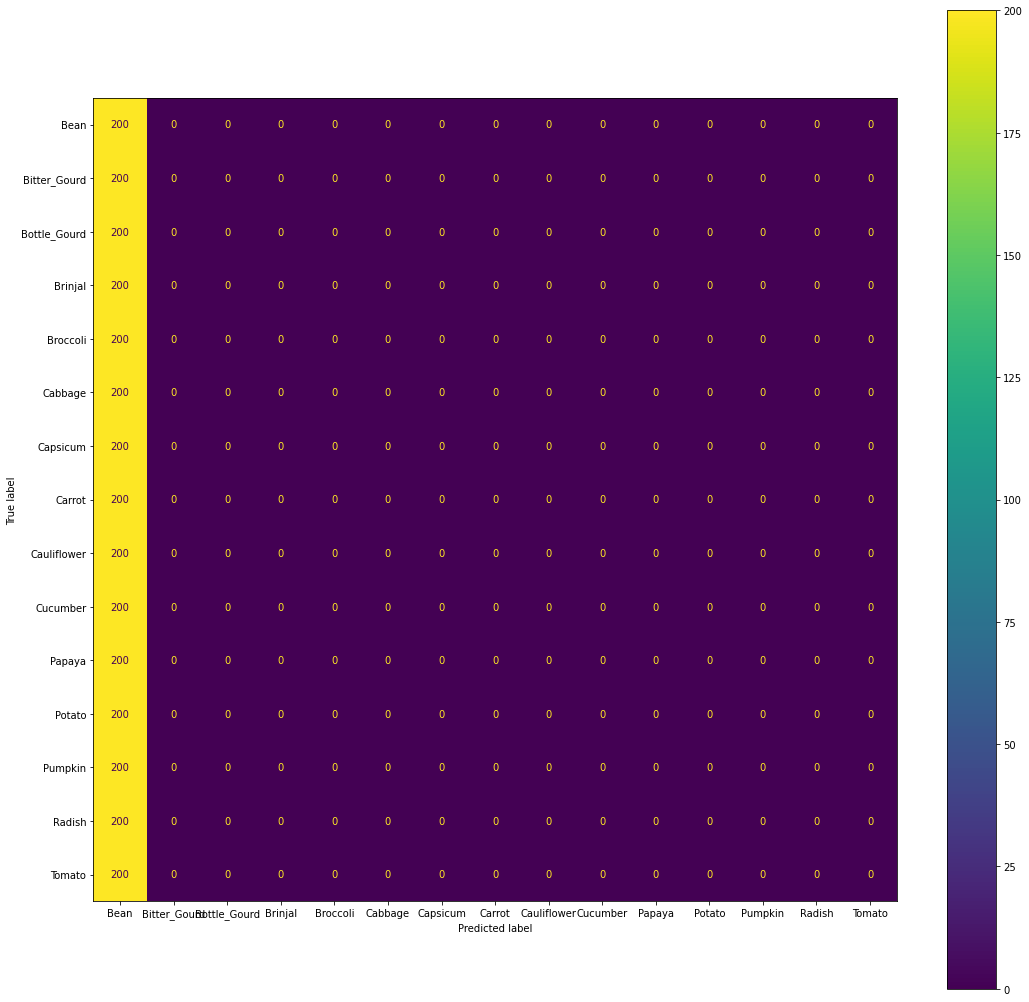

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


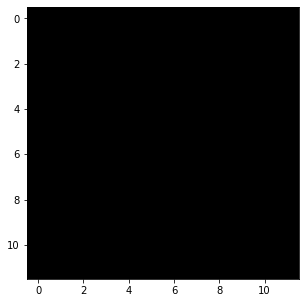

Bitter_Gourd


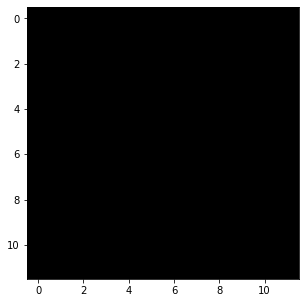

Bottle_Gourd


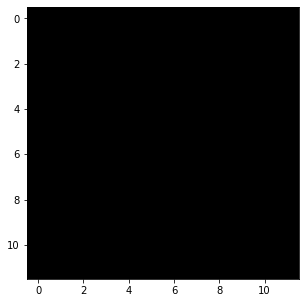

Brinjal


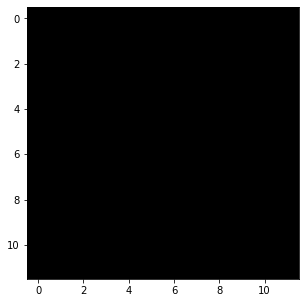

Broccoli


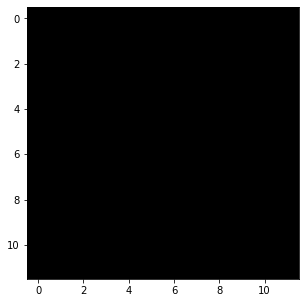

Cabbage


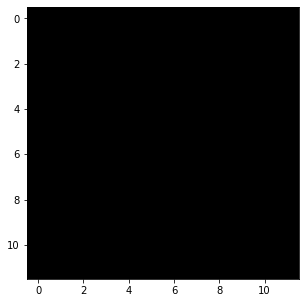

Capsicum


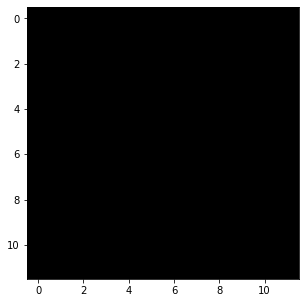

Carrot


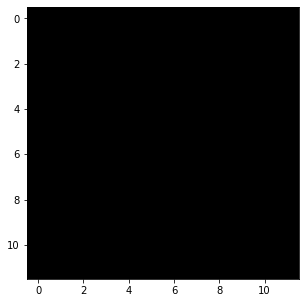

Cauliflower


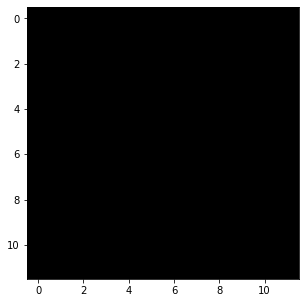

Cucumber


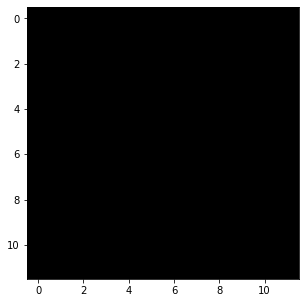

Papaya


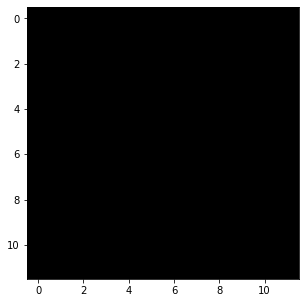

Potato


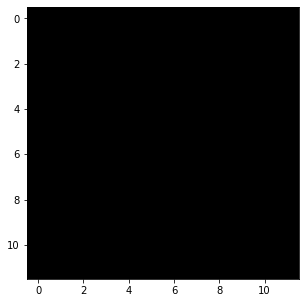

Pumpkin


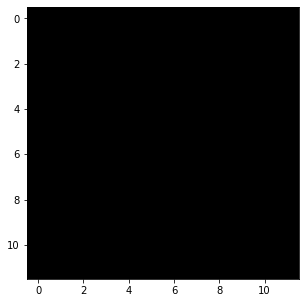

Radish


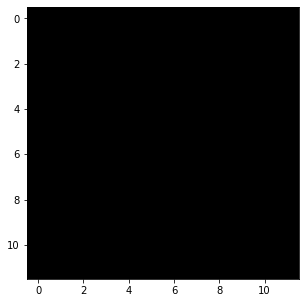

Tomato


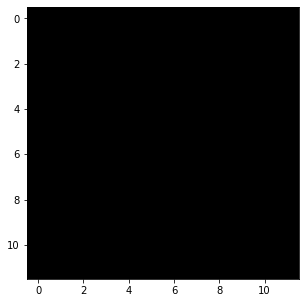

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =32, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.327349774683249, validation cost = 3.0664009893933204
Train Accuracy: 26.646706586826348 Validation Accuracy: 6.833333333333333
Epoch 2: training cost = 2.1753762094353024, validation cost = 3.262832057236882
Train Accuracy: 32.02927478376581 Validation Accuracy: 6.433333333333334
Epoch 3: training cost = 2.0555374715506147, validation cost = 3.4204072452700856
Train Accuracy: 35.87491683300066 Validation Accuracy: 6.800000000000001
Epoch 4: training cost = 1.953304190596012, validation cost = 3.568598566114897
Train Accuracy: 38.8356620093147 Validation Accuracy: 7.066666666666667
Epoch 5: training cost = 1.86055989170434, validation cost = 3.7099130156495215
Train Accuracy: 41.62341982701264 Validation Accuracy: 7.233333333333333
Epoch 6: training cost = 1.7733963206728711, validation cost = 3.8445393225959203
Train Accuracy: 44.41783100465735 Validation Accuracy: 7.333333333333333
Epoch 7: training cost = 1.6893407619542573, validation cost = 3.97215105435

              precision    recall  f1-score   support

           0      0.036     0.030     0.033       200
           1      0.023     0.035     0.027       200
           2      0.089     0.200     0.123       200
           3      0.052     0.060     0.056       200
           4      0.029     0.015     0.020       200
           5      0.056     0.055     0.055       200
           6      0.034     0.045     0.039       200
           7      0.019     0.020     0.019       200
           8      0.016     0.010     0.012       200
           9      0.010     0.010     0.010       200
          10      0.026     0.020     0.022       200
          11      0.507     0.545     0.525       200
          12      0.025     0.015     0.019       200
          13      0.026     0.015     0.019       200
          14      0.014     0.010     0.012       200

    accuracy                          0.072      3000
   macro avg      0.064     0.072     0.066      3000
weighted avg      0.064   

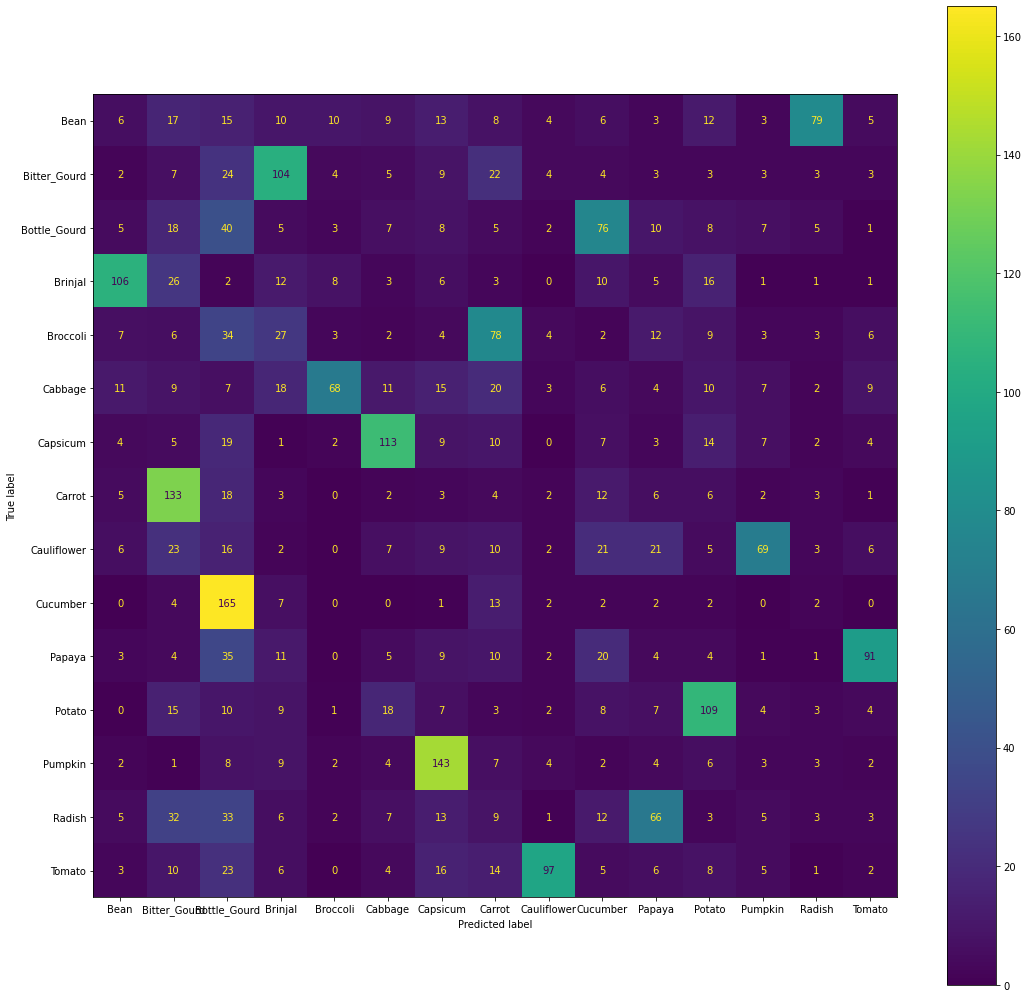

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


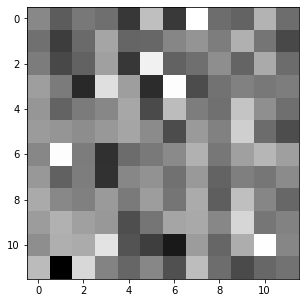

Bitter_Gourd


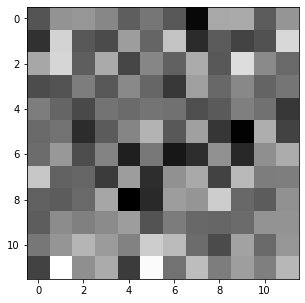

Bottle_Gourd


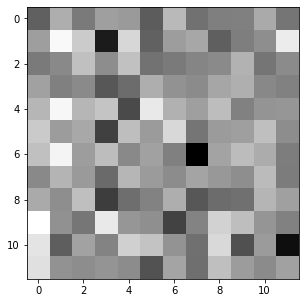

Brinjal


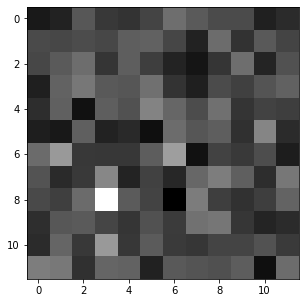

Broccoli


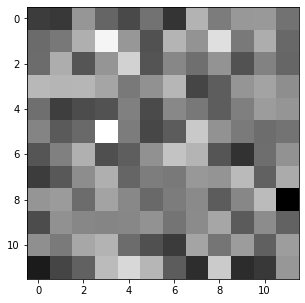

Cabbage


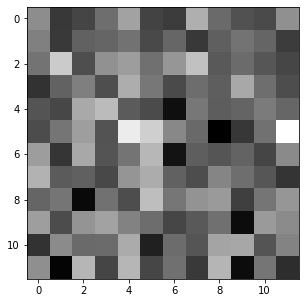

Capsicum


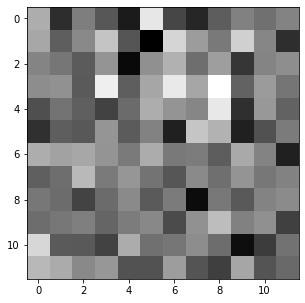

Carrot


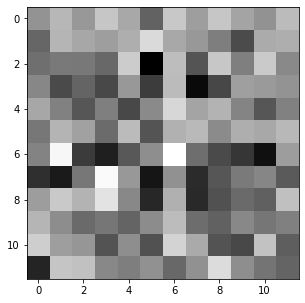

Cauliflower


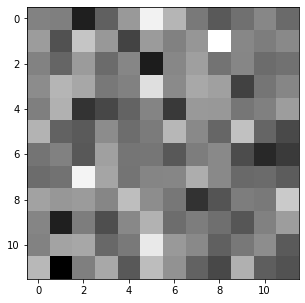

Cucumber


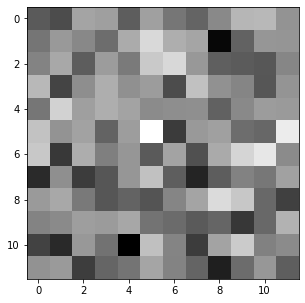

Papaya


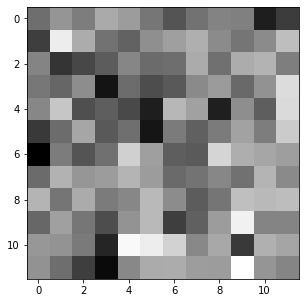

Potato


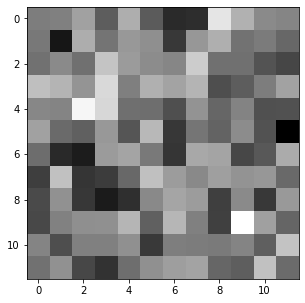

Pumpkin


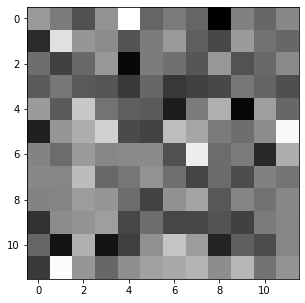

Radish


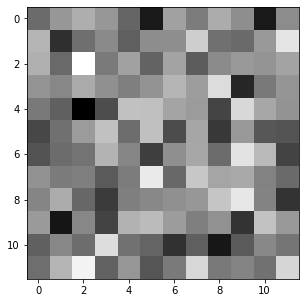

Tomato


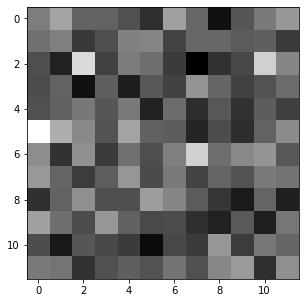

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =64, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.664686912864435, validation cost = 2.7230465402936423
Train Accuracy: 10.232867598137059 Validation Accuracy: 6.800000000000001
Epoch 2: training cost = 2.633961483605681, validation cost = 2.7271812654050622
Train Accuracy: 14.477711244178309 Validation Accuracy: 7.433333333333334
Epoch 3: training cost = 2.6088587168292086, validation cost = 2.7352286389308453
Train Accuracy: 16.61343978709248 Validation Accuracy: 8.1
Epoch 4: training cost = 2.5885338403499647, validation cost = 2.7472543140613124
Train Accuracy: 16.932801064537593 Validation Accuracy: 8.6
Epoch 5: training cost = 2.568839170222282, validation cost = 2.765236135026801
Train Accuracy: 17.53160345974717 Validation Accuracy: 8.5
Epoch 6: training cost = 2.548784013826992, validation cost = 2.7885061783395466
Train Accuracy: 18.862275449101794 Validation Accuracy: 7.166666666666667
Epoch 7: training cost = 2.530360807483927, validation cost = 2.813497071617549
Train Accuracy: 19.98669328010645

              precision    recall  f1-score   support

           0      0.012     0.005     0.007       200
           1      0.030     0.055     0.039       200
           2      0.074     0.085     0.079       200
           3      0.043     0.030     0.035       200
           4      0.047     0.075     0.057       200
           5      0.025     0.025     0.025       200
           6      0.055     0.050     0.052       200
           7      0.008     0.005     0.006       200
           8      0.160     0.115     0.134       200
           9      0.050     0.035     0.041       200
          10      0.089     0.040     0.055       200
          11      0.175     0.445     0.251       200
          12      0.042     0.015     0.022       200
          13      0.029     0.005     0.009       200
          14      0.045     0.080     0.058       200

    accuracy                          0.071      3000
   macro avg      0.059     0.071     0.058      3000
weighted avg      0.059   

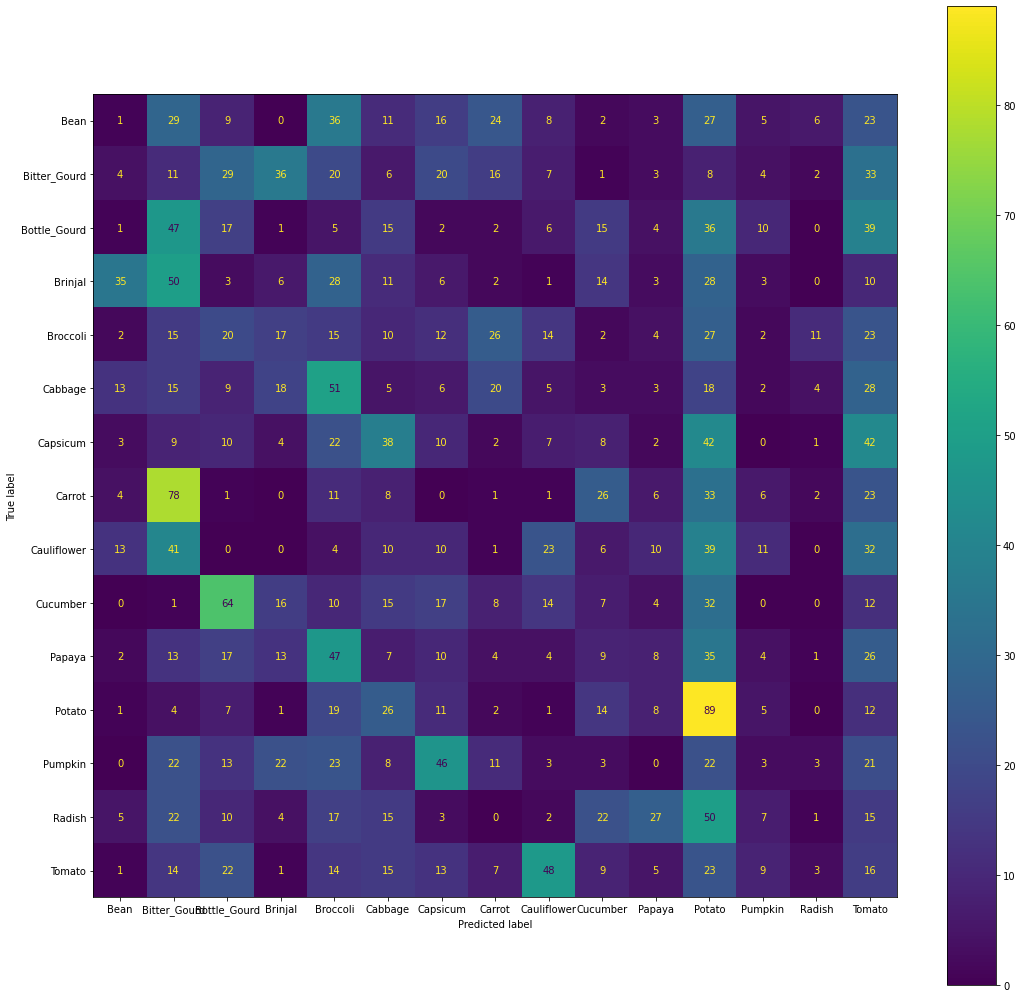

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


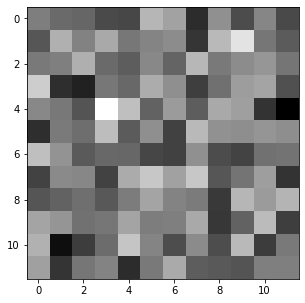

Bitter_Gourd


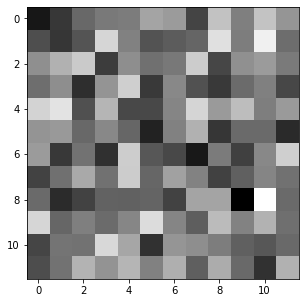

Bottle_Gourd


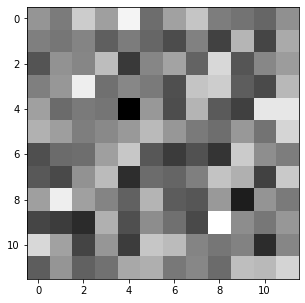

Brinjal


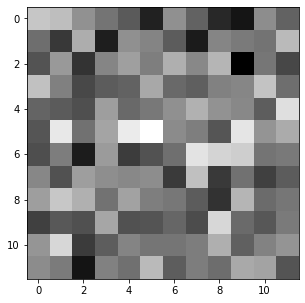

Broccoli


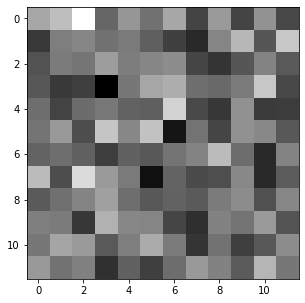

Cabbage


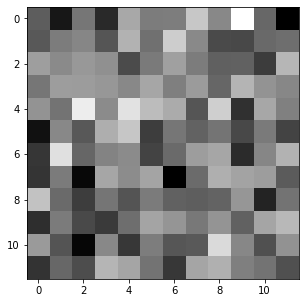

Capsicum


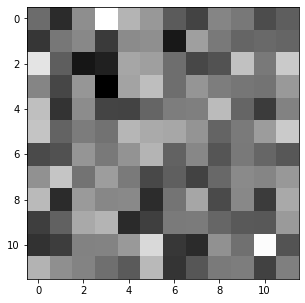

Carrot


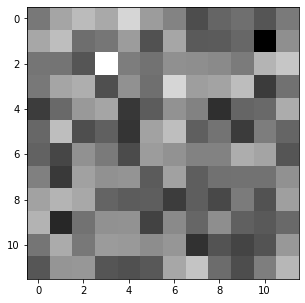

Cauliflower


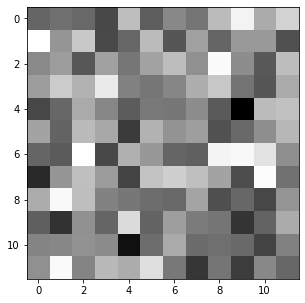

Cucumber


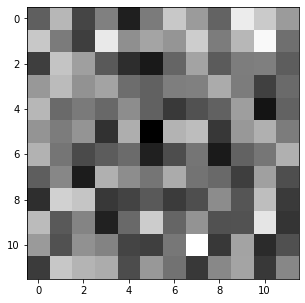

Papaya


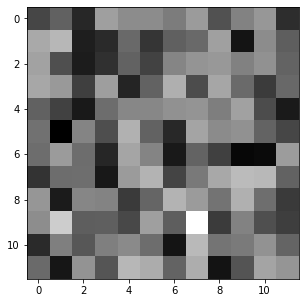

Potato


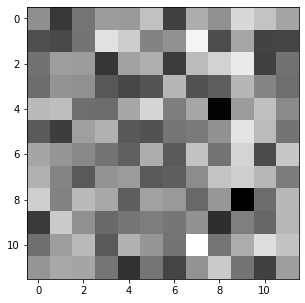

Pumpkin


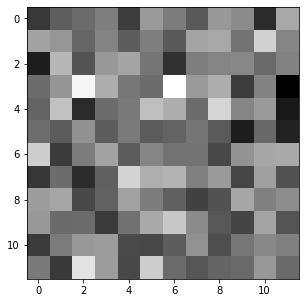

Radish


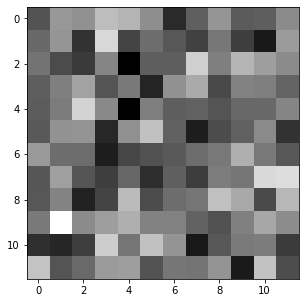

Tomato


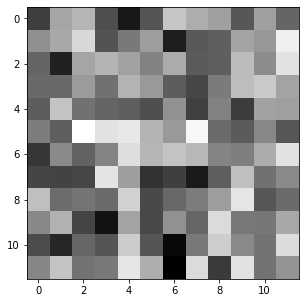

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =64, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

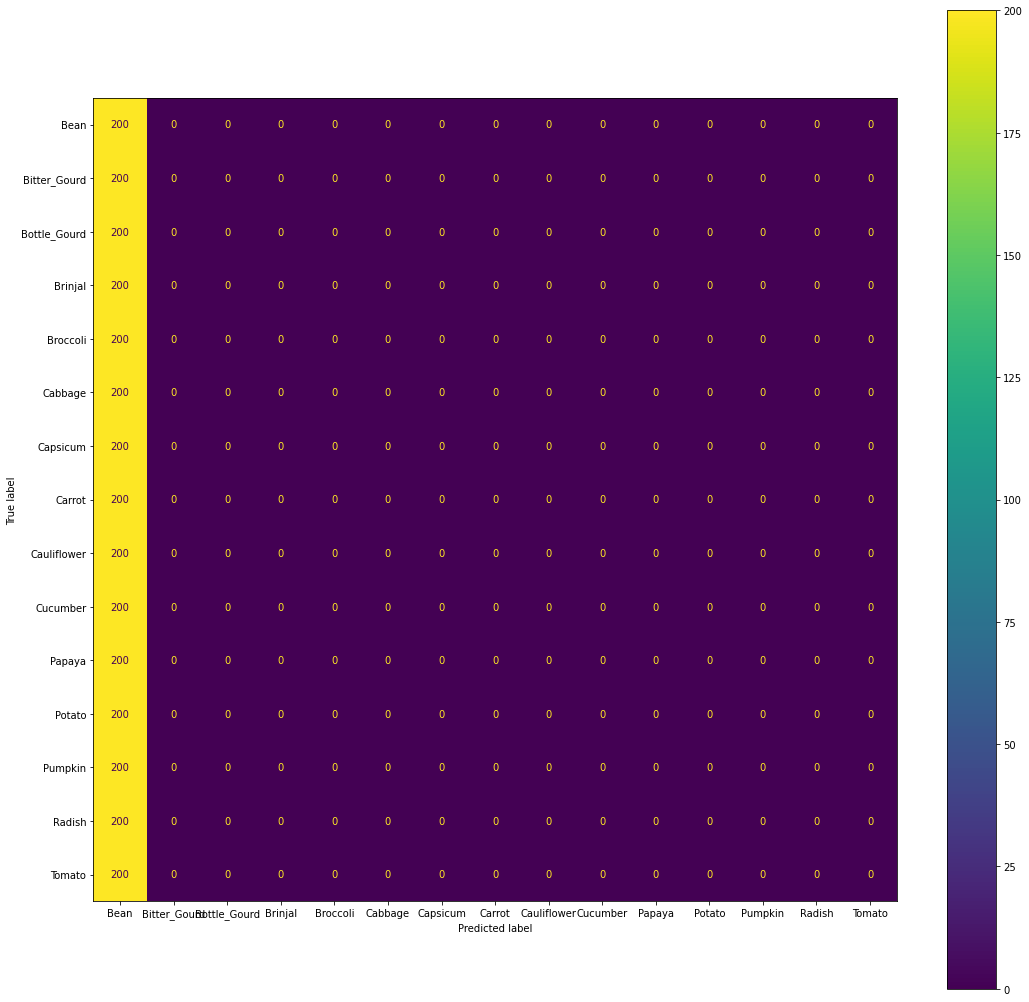

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


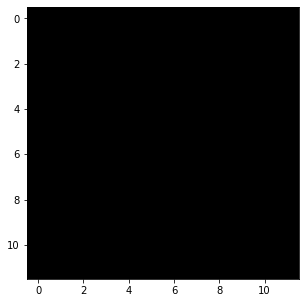

Bitter_Gourd


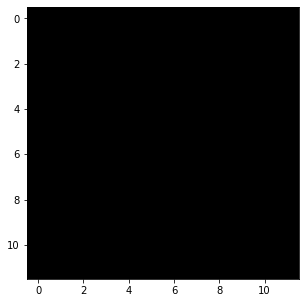

Bottle_Gourd


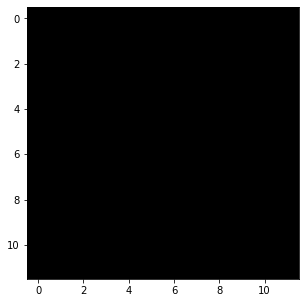

Brinjal


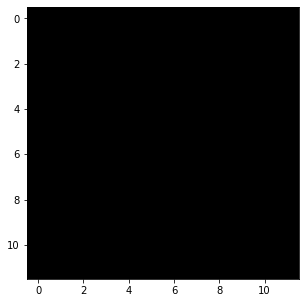

Broccoli


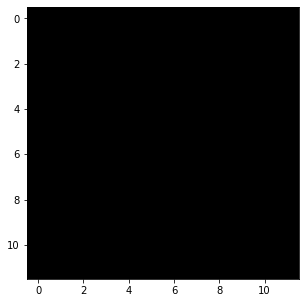

Cabbage


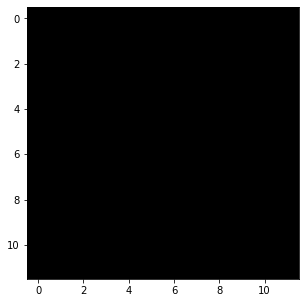

Capsicum


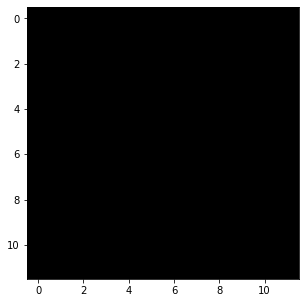

Carrot


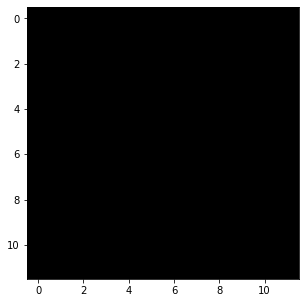

Cauliflower


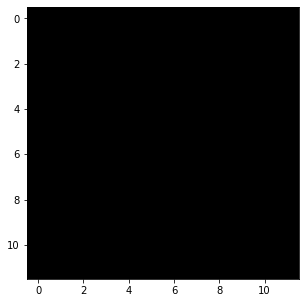

Cucumber


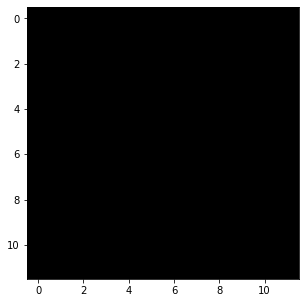

Papaya


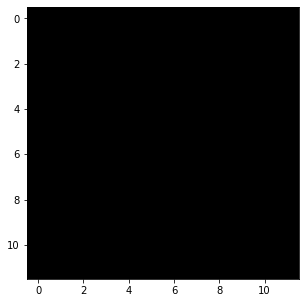

Potato


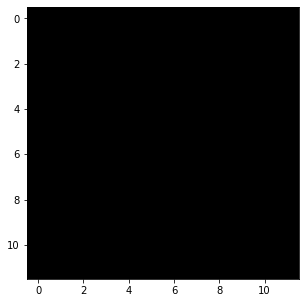

Pumpkin


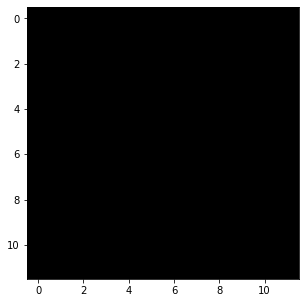

Radish


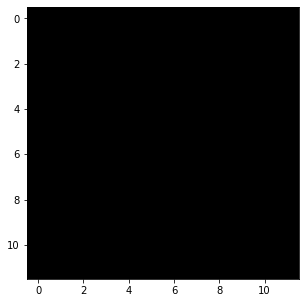

Tomato


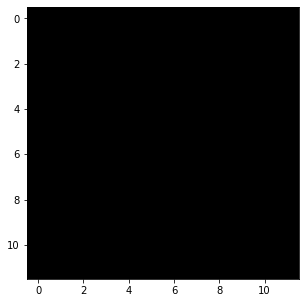

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =64, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.4169128516304452, validation cost = 2.9608724015339773
Train Accuracy: 22.4750499001996 Validation Accuracy: 8.1
Epoch 2: training cost = 2.2926145143825813, validation cost = 3.0853575772197037
Train Accuracy: 28.47638057218895 Validation Accuracy: 8.133333333333333
Epoch 3: training cost = 2.1999175526053834, validation cost = 3.180499637235602
Train Accuracy: 31.949434464404526 Validation Accuracy: 8.133333333333333
Epoch 4: training cost = 2.119803331014063, validation cost = 3.2643028870067834
Train Accuracy: 34.39787092481703 Validation Accuracy: 7.566666666666666
Epoch 5: training cost = 2.0472968787859656, validation cost = 3.3438020286923176
Train Accuracy: 36.833000665335994 Validation Accuracy: 7.333333333333333
Epoch 6: training cost = 1.9810526197076632, validation cost = 3.4202815774945465
Train Accuracy: 38.98203592814371 Validation Accuracy: 7.333333333333333
Epoch 7: training cost = 1.9196635158241238, validation cost = 3.494453270958361
Trai

              precision    recall  f1-score   support

           0      0.073     0.080     0.076       200
           1      0.026     0.030     0.028       200
           2      0.057     0.045     0.050       200
           3      0.036     0.030     0.033       200
           4      0.033     0.030     0.031       200
           5      0.033     0.025     0.029       200
           6      0.042     0.045     0.044       200
           7      0.038     0.075     0.050       200
           8      0.045     0.045     0.045       200
           9      0.008     0.005     0.006       200
          10      0.077     0.120     0.094       200
          11      0.537     0.365     0.435       200
          12      0.044     0.045     0.044       200
          13      0.017     0.010     0.013       200
          14      0.028     0.025     0.026       200

    accuracy                          0.065      3000
   macro avg      0.073     0.065     0.067      3000
weighted avg      0.073   

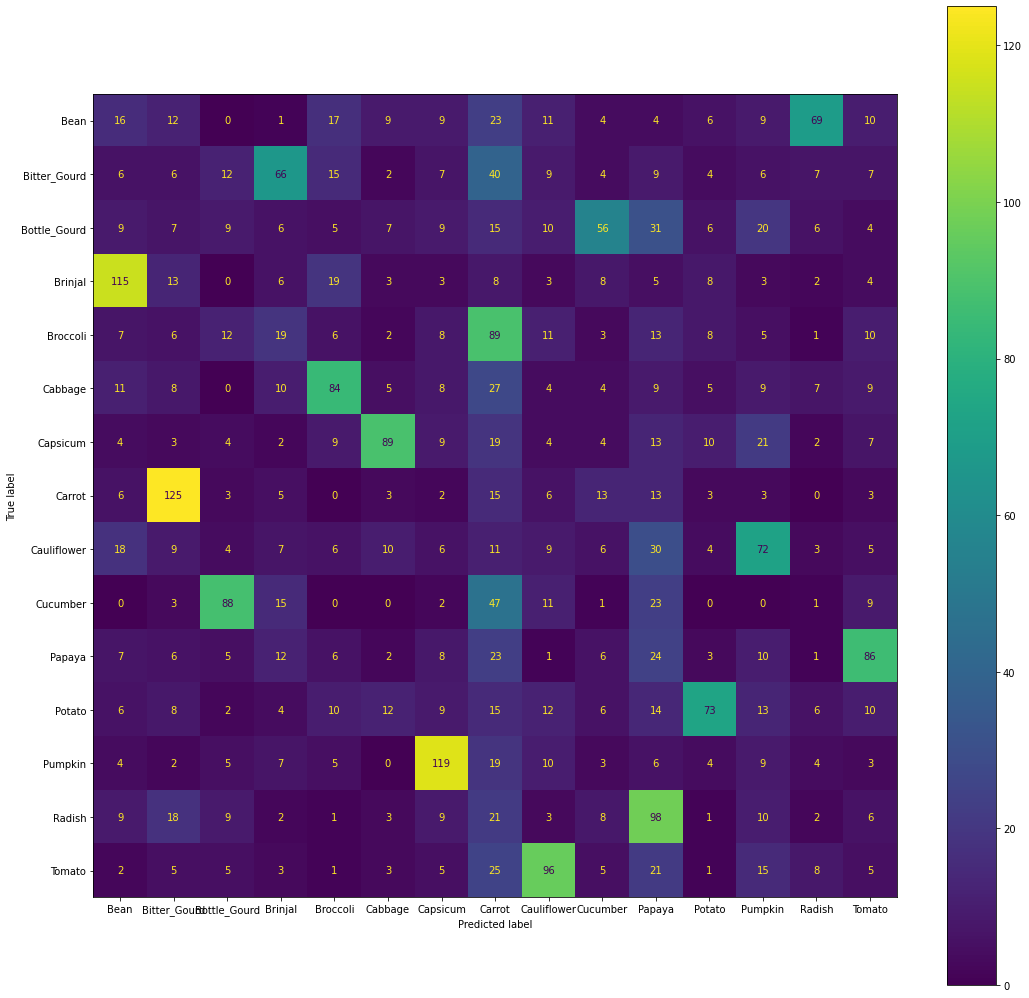

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


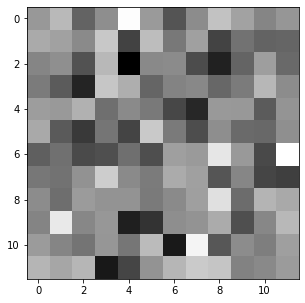

Bitter_Gourd


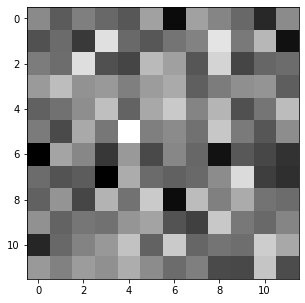

Bottle_Gourd


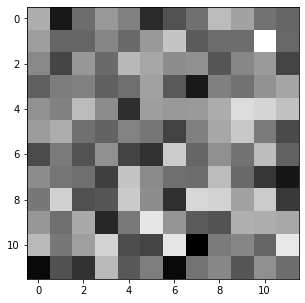

Brinjal


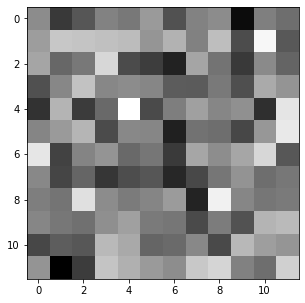

Broccoli


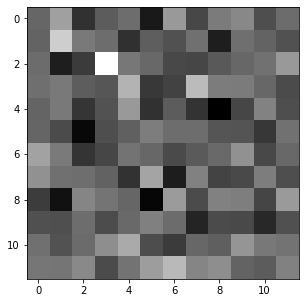

Cabbage


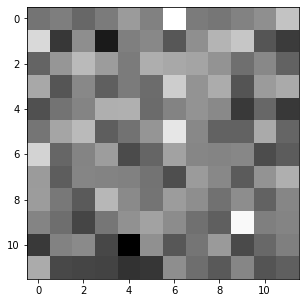

Capsicum


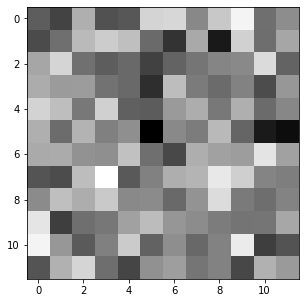

Carrot


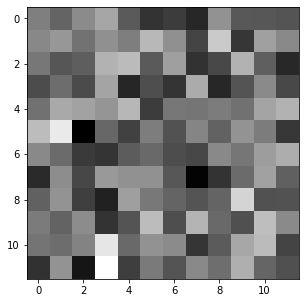

Cauliflower


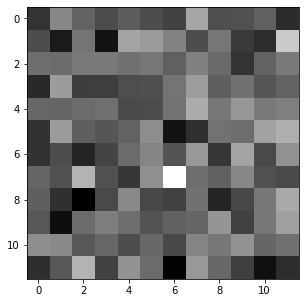

Cucumber


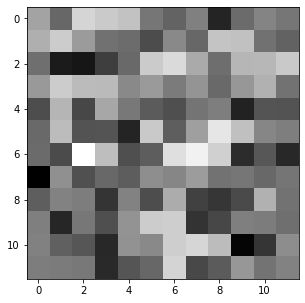

Papaya


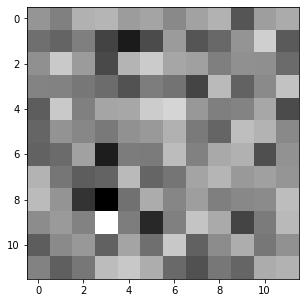

Potato


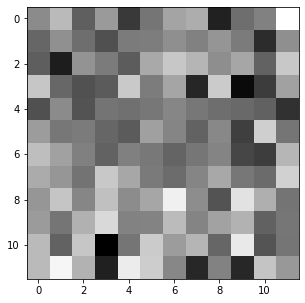

Pumpkin


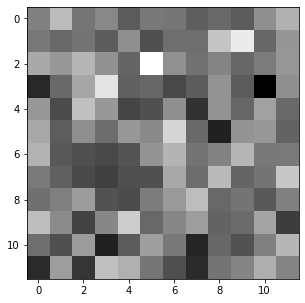

Radish


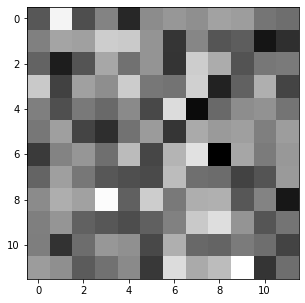

Tomato


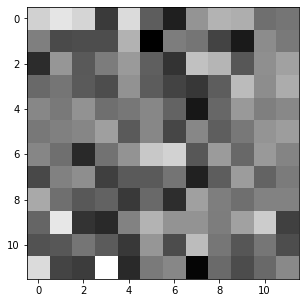

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =128, activ_func = ["sigmoid","sigmoid" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.6758668940573695, validation cost = 2.719516200823039
Train Accuracy: 10.272787757817698 Validation Accuracy: 6.333333333333334
Epoch 2: training cost = 2.660565520160795, validation cost = 2.723647187445272
Train Accuracy: 12.70791749833666 Validation Accuracy: 6.433333333333334
Epoch 3: training cost = 2.646195915369414, validation cost = 2.725759096275665
Train Accuracy: 13.652694610778443 Validation Accuracy: 6.1
Epoch 4: training cost = 2.6332187168415646, validation cost = 2.7276940003566352
Train Accuracy: 15.13639387890885 Validation Accuracy: 6.2
Epoch 5: training cost = 2.6228067632687235, validation cost = 2.7312027459231545
Train Accuracy: 15.854956753160346 Validation Accuracy: 6.266666666666667
Epoch 6: training cost = 2.613335560425715, validation cost = 2.736016502733324
Train Accuracy: 16.294078509647374 Validation Accuracy: 6.0
Epoch 7: training cost = 2.603857118294553, validation cost = 2.7424413467948714
Train Accuracy: 16.32734530938124 

              precision    recall  f1-score   support

           0      0.056     0.015     0.024       200
           1      0.027     0.045     0.034       200
           2      0.023     0.015     0.018       200
           3      0.034     0.035     0.035       200
           4      0.022     0.025     0.023       200
           5      0.039     0.060     0.048       200
           6      0.077     0.060     0.068       200
           7      0.006     0.005     0.005       200
           8      0.205     0.085     0.120       200
           9      0.033     0.010     0.015       200
          10      0.107     0.060     0.077       200
          11      0.160     0.455     0.236       200
          12      0.035     0.020     0.025       200
          13      0.040     0.025     0.031       200
          14      0.040     0.070     0.051       200

    accuracy                          0.066      3000
   macro avg      0.060     0.066     0.054      3000
weighted avg      0.060   

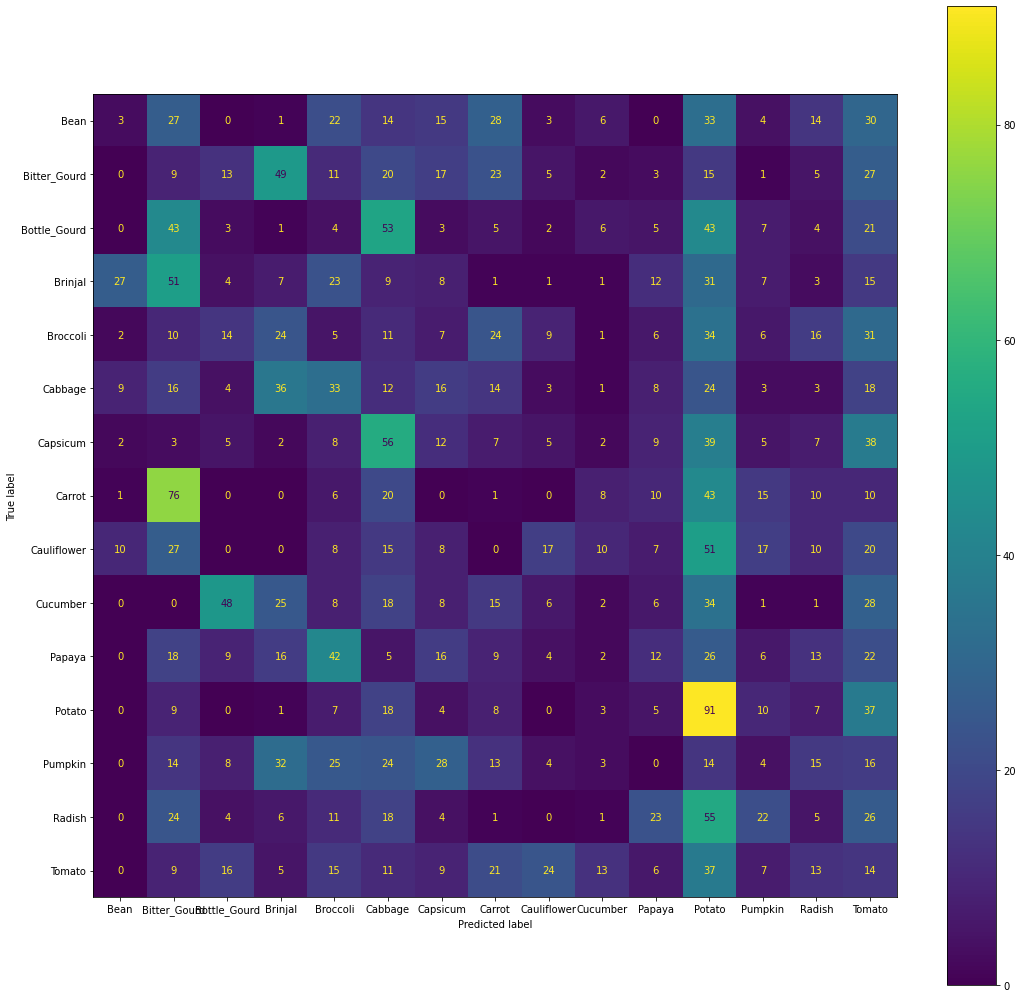

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


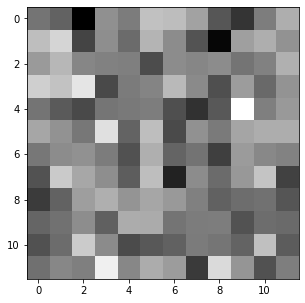

Bitter_Gourd


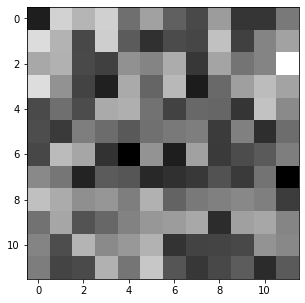

Bottle_Gourd


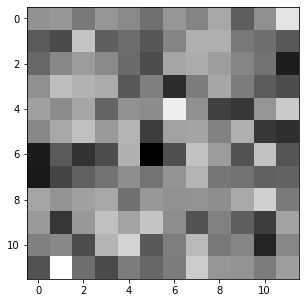

Brinjal


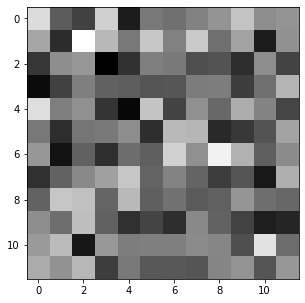

Broccoli


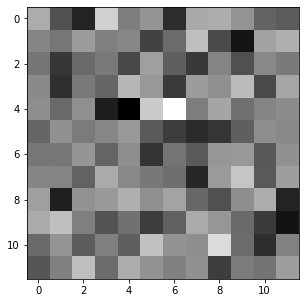

Cabbage


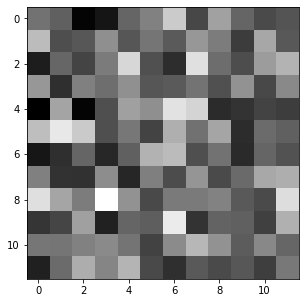

Capsicum


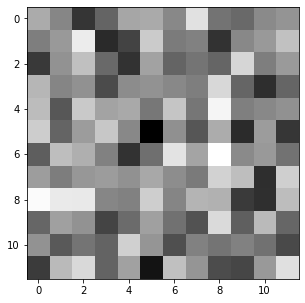

Carrot


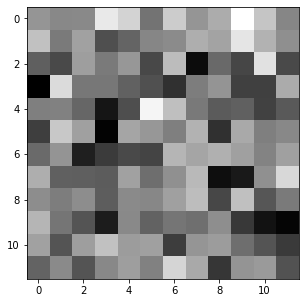

Cauliflower


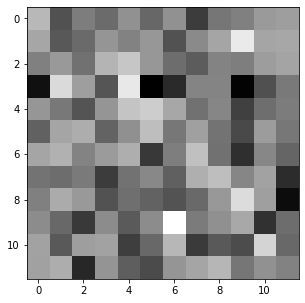

Cucumber


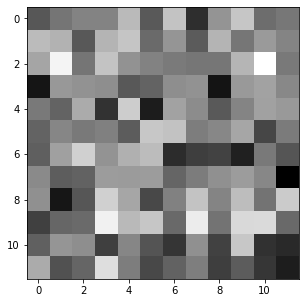

Papaya


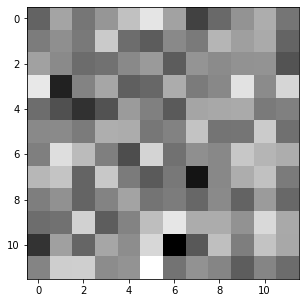

Potato


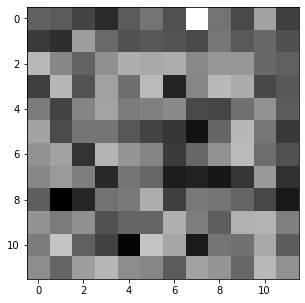

Pumpkin


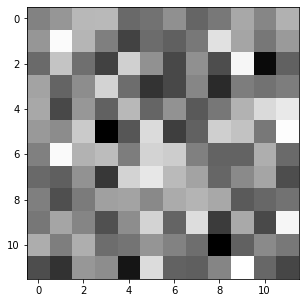

Radish


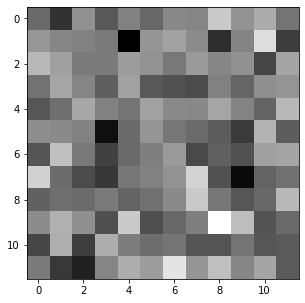

Tomato


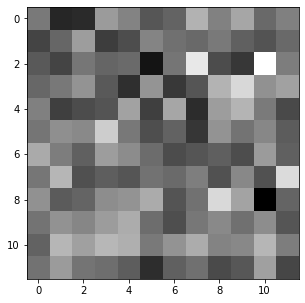

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =128, activ_func = ["relu","relu" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

<ipython-input-9-59d7f83656a8>:125: RuntimeWarning: overflow encountered in exp
  expZ = np.exp(self.z)
<ipython-input-9-59d7f83656a8>:126: RuntimeWarning: invalid value encountered in true_divide
  return expZ/(np.sum(expZ, 0))


Epoch 1: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 2: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 3: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 4: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 5: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 6: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 7: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 8: training cost = nan, validation cost = nan
Train Accuracy: 6.65335994677312 Validation Accuracy: 6.666666666666667
Epoch 9:

              precision    recall  f1-score   support

           0      0.067     1.000     0.125       200
           1      0.000     0.000     0.000       200
           2      0.000     0.000     0.000       200
           3      0.000     0.000     0.000       200
           4      0.000     0.000     0.000       200
           5      0.000     0.000     0.000       200
           6      0.000     0.000     0.000       200
           7      0.000     0.000     0.000       200
           8      0.000     0.000     0.000       200
           9      0.000     0.000     0.000       200
          10      0.000     0.000     0.000       200
          11      0.000     0.000     0.000       200
          12      0.000     0.000     0.000       200
          13      0.000     0.000     0.000       200
          14      0.000     0.000     0.000       200

    accuracy                          0.067      3000
   macro avg      0.004     0.067     0.008      3000
weighted avg      0.004   

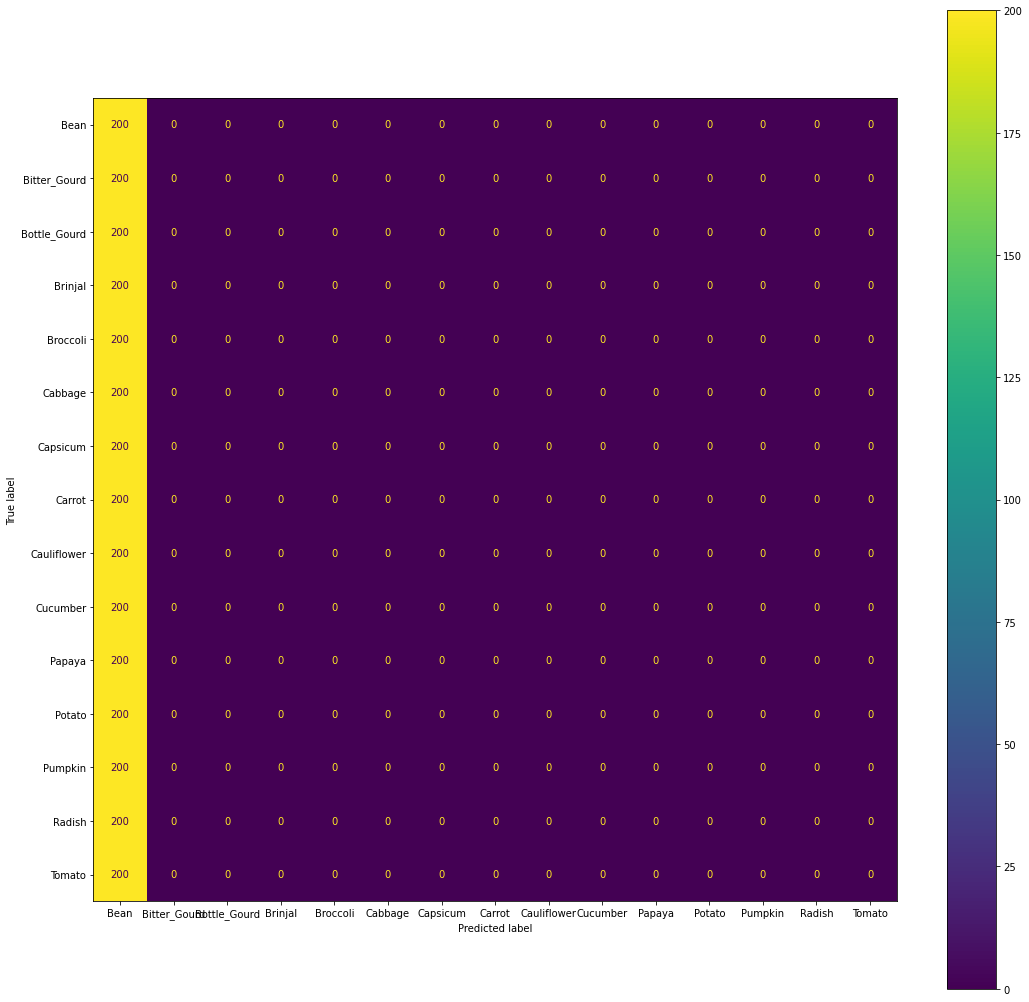

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


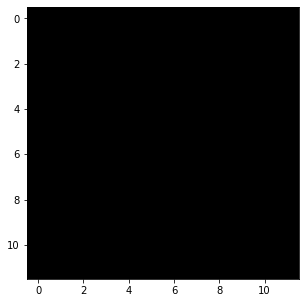

Bitter_Gourd


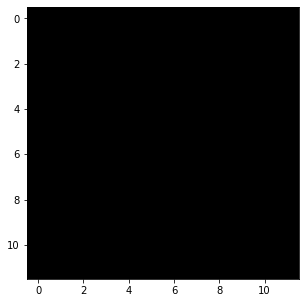

Bottle_Gourd


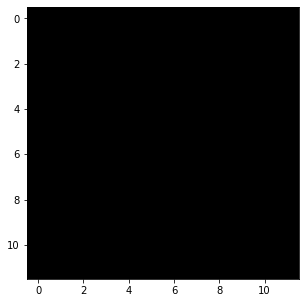

Brinjal


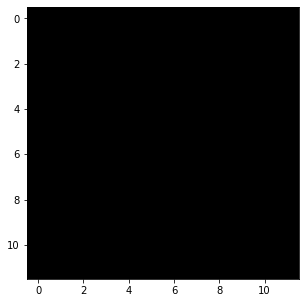

Broccoli


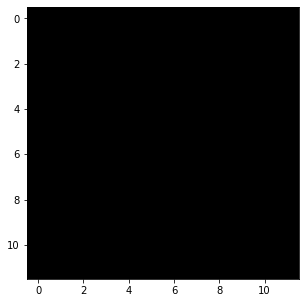

Cabbage


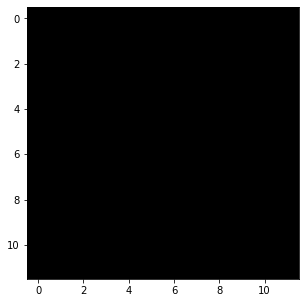

Capsicum


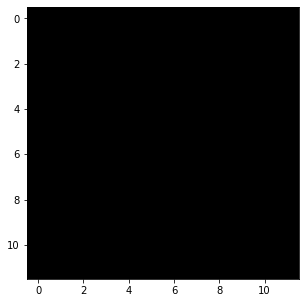

Carrot


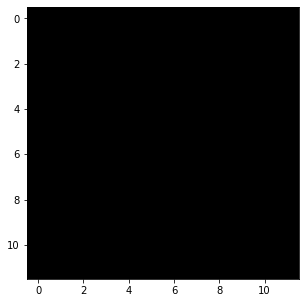

Cauliflower


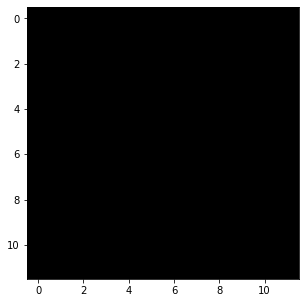

Cucumber


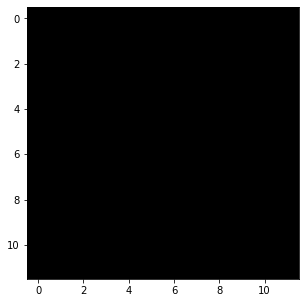

Papaya


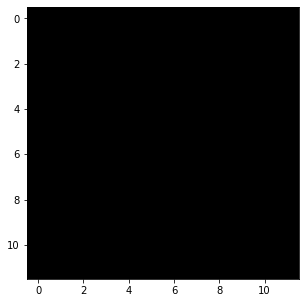

Potato


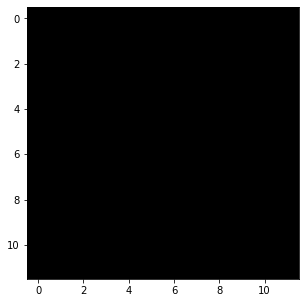

Pumpkin


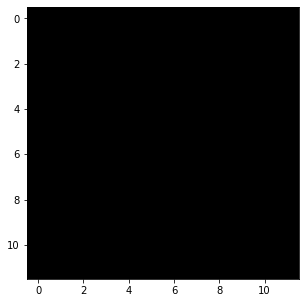

Radish


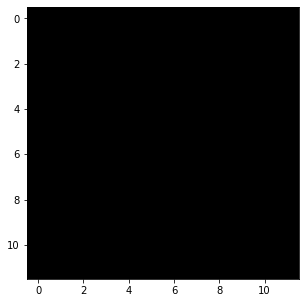

Tomato


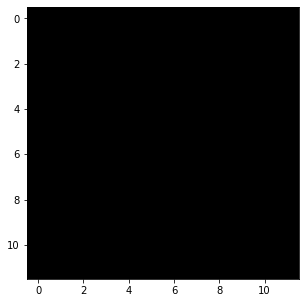

In [ ]:
model.visualize_weights(12)

In [ ]:
model = Neural_Network(hiden_layers = 2, node_sizes = [3600, 256,144, 15], LR = 0.02, batch_size =128, activ_func = ["tanh","tanh" ,"softmax"] , epoch =15)
model.train(X_train= X_train,Y_train = Y_train, X_val = X_val, Y_val =Y_val, early_stopping = False)

Epoch 1: training cost = 2.516320866960924, validation cost = 2.831738035893828
Train Accuracy: 18.20359281437126 Validation Accuracy: 8.833333333333334
Epoch 2: training cost = 2.4100829160088755, validation cost = 2.9158986977690926
Train Accuracy: 23.41317365269461 Validation Accuracy: 8.266666666666666
Epoch 3: training cost = 2.3367273076758197, validation cost = 2.992275068669904
Train Accuracy: 26.42049234863606 Validation Accuracy: 8.033333333333333
Epoch 4: training cost = 2.2782992821348844, validation cost = 3.0580744663593102
Train Accuracy: 28.868928809048573 Validation Accuracy: 7.2666666666666675
Epoch 5: training cost = 2.226633886296143, validation cost = 3.1173606789737933
Train Accuracy: 31.0645375914837 Validation Accuracy: 7.133333333333333
Epoch 6: training cost = 2.1803081904110275, validation cost = 3.1719911135102126
Train Accuracy: 32.70126413838989 Validation Accuracy: 6.933333333333333
Epoch 7: training cost = 2.137612426104282, validation cost = 3.223195652

              precision    recall  f1-score   support

           0      0.049     0.050     0.049       200
           1      0.023     0.025     0.024       200
           2      0.063     0.065     0.064       200
           3      0.039     0.025     0.030       200
           4      0.028     0.025     0.026       200
           5      0.046     0.065     0.054       200
           6      0.028     0.030     0.029       200
           7      0.035     0.050     0.041       200
           8      0.040     0.030     0.034       200
           9      0.011     0.005     0.007       200
          10      0.079     0.130     0.098       200
          11      0.362     0.440     0.397       200
          12      0.044     0.035     0.039       200
          13      0.049     0.030     0.037       200
          14      0.028     0.025     0.027       200

    accuracy                          0.069      3000
   macro avg      0.061     0.069     0.064      3000
weighted avg      0.061   

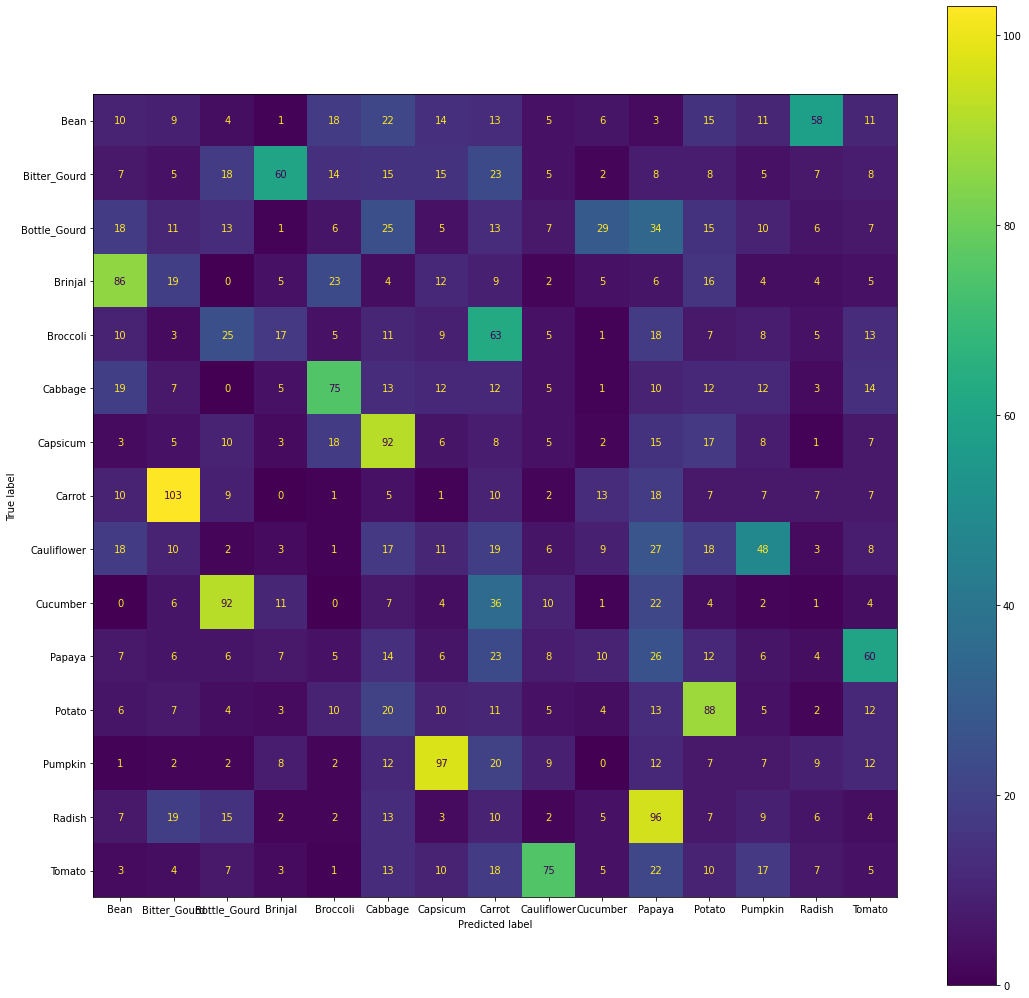

In [ ]:
model.confusion_m(X_test, Y_test)

Bean


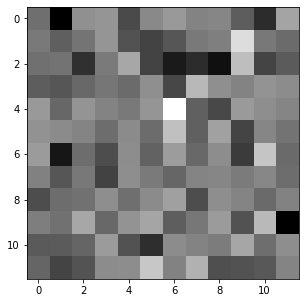

Bitter_Gourd


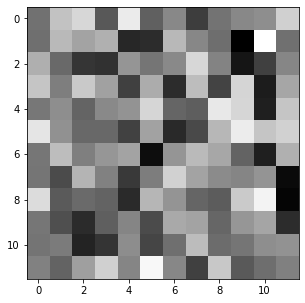

Bottle_Gourd


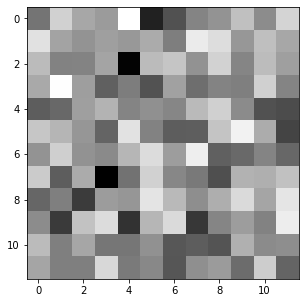

Brinjal


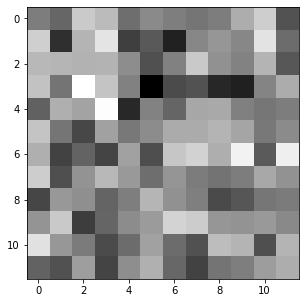

Broccoli


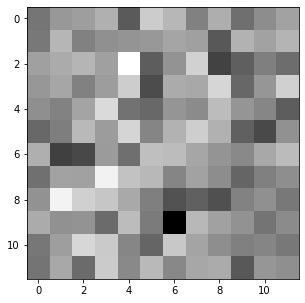

Cabbage


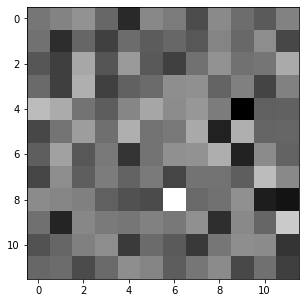

Capsicum


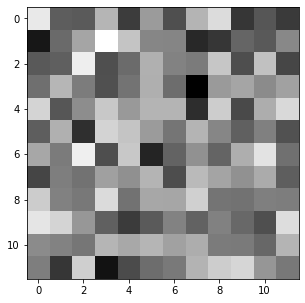

Carrot


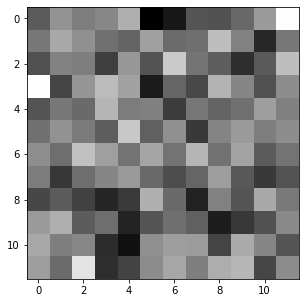

Cauliflower


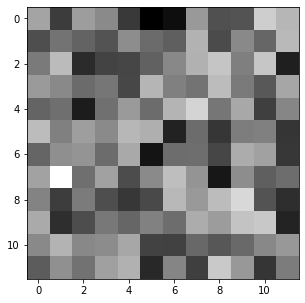

Cucumber


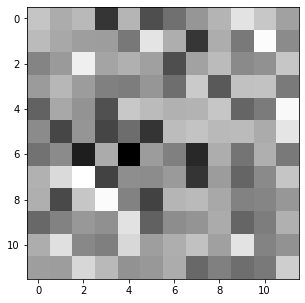

Papaya


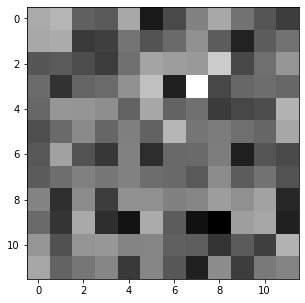

Potato


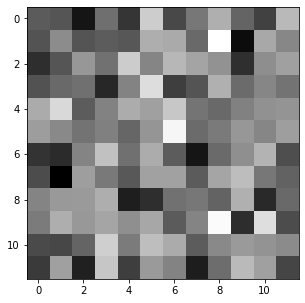

Pumpkin


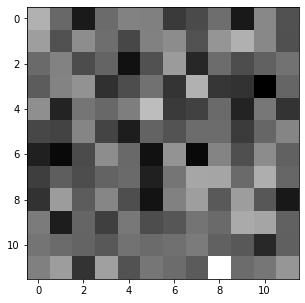

Radish


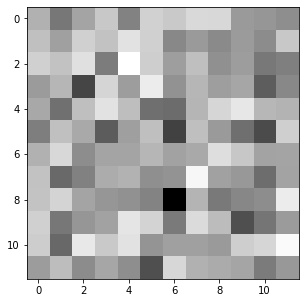

Tomato


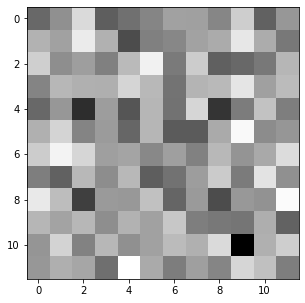

In [ ]:
model.visualize_weights(12)